In [1]:
from src.data.data_utils import query_mlb_db

In [43]:
kukuchi = 579328
jones = 683003

pitcher = kukuchi

In [80]:
query_str = f'''
    SELECT pitch_number, strikes, balls, outs_when_up,
        CASE
            when stand='R' then 1
            else 0
        END AS stand,
        CASE
            when on_1b is not null then 1
            else 0
        END AS on_1b,
        CASE
            when on_2b is not null then 1
            else 0
        END AS on_2b,
        CASE
            when on_3b is not null then 1
            else 0
        END AS on_3b,
        CASE
            when fld_score - bat_score > 0 then 1
            when fld_score - bat_score = 0 then 0
            else -1
        END AS is_winning,
        pitch_type,
        LAG(pitch_type) OVER (PARTITION BY game_pk, pitcher, at_bat_number ORDER BY pitch_number) AS prev_pitch,
        ROW_NUMBER() OVER (PARTITION BY game_pk, pitcher ORDER BY at_bat_number, pitch_number) AS cumulative_pitch_number
    FROM Statcast
    WHERE pitcher = {pitcher}
        AND pitch_type IS NOT NULL
        and pitch_type <> 'PO'
        AND game_type <> 'E' || 'S'
    ORDER BY game_pk, at_bat_number, pitch_number
'''
df = query_mlb_db(query_str)



In [81]:
df

,pitch_number,strikes,balls,outs_when_up,stand,on_1b,on_2b,on_3b,is_winning,pitch_type,prev_pitch,cumulative_pitch_number
0,1,0,0,0,1,0,0,0,1,FF,None,1
1,2,1,0,0,1,0,0,0,1,FF,FF,2
2,3,2,0,0,1,0,0,0,1,CU,FF,3
3,1,0,0,1,1,0,0,0,1,FF,None,4
4,2,0,1,1,1,0,0,0,1,FF,FF,5
...,...,...,...,...,...,...,...,...,...,...,...,...
11751,2,1,0,0,1,0,0,0,-1,FF,CU,17
11752,1,0,0,1,0,0,0,0,-1,FF,None,18
11753,2,0,1,1,0,0,0,0,-1,SL,FF,19
11754,3,0,2,1,0,0,0,0,-1,SL,SL,20


In [84]:
query_str = f'''
    select pitch_type, woba_value, type from Statcast where batter = 665742
'''

df = query_mlb_db(query_str)

In [85]:
df

,pitch_type,woba_value,type
0,CH,0.0,X
1,CU,NaN,B
2,FF,0.9,X
3,CH,NaN,B
4,CU,0.7,B
...,...,...,...
15340,FF,NaN,S
15341,FS,NaN,B
15342,FS,NaN,B
15343,FF,NaN,S


In [92]:
filtered_df = df.dropna(subset=['woba_value'])

pitch_type_stats = filtered_df.groupby('pitch_type').agg({'woba_value': 'mean', 'pitch_type': 'count'})
pitch_type_stats.columns = ['average_woba', 'pitch_count']

print(pitch_type_stats)

            average_woba  pitch_count
pitch_type                           
CH              0.349042          522
CU              0.335650          223
FA              1.000000            2
FC              0.397584          269
FF              0.478646         1152
FO              0.000000            1
FS              0.408911          101
KC              0.353448           87
SI              0.432488          651
SL              0.343423          555
ST              0.404478           67
SV              0.100000           14


In [90]:
average_woba_by_type = filtered_df.groupby('type')['woba_value'].mean()
average_woba_by_type

type
B    0.694607
S    0.001084
X    0.439458
Name: woba_value, dtype: float64

In [47]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

h2o_df = h2o.H2OFrame(df)

target_col = 'pitch_type'
feature_cols = df.columns.tolist()
feature_cols.remove(target_col)

train, valid = h2o_df.split_frame(ratios=[0.8])

aml = H2OAutoML(max_models=10, seed=42, sort_metric='logloss')
aml.train(x=feature_cols, y=target_col, training_frame=train)


leaderboard = aml.leaderboard
print(leaderboard)

best_model = aml.leader
predictions = best_model.predict(valid)
print(predictions)

#h2o.save_model(best_model, 'best_model')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,8 mins 17 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 26 days
H2O_cluster_name:,H2O_from_python_reece_eq833i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.822 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
19:35:30.110: GLM_1_AutoML_2_20240509_193521 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 16 out of bounds for length 16

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                   logloss    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_1_AutoML_2_20240509_193521       1.26834                0.760986  0.684627  0.468714
StackedEnsemble_BestOfFamily_1_AutoML_2_20240509_193521    1.26865                0.761537  0.684889  0.469074
XGBoost_3_AutoML_2_20240509_193521                         1.27359                0.749761  0.680969  0.463719
GBM_1_AutoML_2_20240509_193521                             1.2906                 0.747105  0.686436  0.471195
XGBoost_1_AutoML_2_20240509_193521                         1.30166                0.745723  0.684197  0.46812

In [54]:
best_model = aml.leader
predictions = best_model.predict(valid)
print(predictions)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
predict           CH         CU          FC        FF           PO        SL
FF         0.314897   0.0749382  0.0389145   0.380325  0.000190269  0.190734
FF         0.27164    0.0624759  0.0468151   0.402698  0.000210327  0.216161
FF         0.0690768  0.135158   0.119988    0.482443  0.00020777   0.193127
FF         0.164163   0.0828601  0.0249187   0.430231  0.000206893  0.297621
FF         0.0353871  0.166388   0.121204    0.531709  0.000213912  0.145098
FF         0.0723905  0.104124   0.109179    0.358994  0.0001697    0.355143
FF         0.0718151  0.14471    0.0802761   0.550955  0.000215365  0.152028
FF         0.110266   0.151048   0.0931702   0.452791  0.000209596  0.192515
FF         0.167714   0.137908   0.00982448  0.47652   0.000171127  0.207862
FF         0.335057   0.0580882  0.0533555   0.428658  0.000193864  0.124647
[2419 rows x 7 columns]



In [71]:

pred_df = h2o.as_list(predictions)
pred_df['predict'].value_counts() / 2419


/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


predict
FF    0.820587
SL    0.112030
FC    0.049607
CH    0.017776
Name: count, dtype: float64

In [77]:
test_df = query_mlb_db('''
select pitch_type, count(*)
as num from Statcast
where pitcher=579328
and pitch_type is not null
and pitch_type <> 'PO'
group by pitch_type
order by num desc;
''')

In [79]:
test_df['num'] / test_df['num'].sum()
test_df

,pitch_type,num
0,FF,5173
1,SL,2890
2,FC,1364
3,CU,1186
4,CH,1143


In [49]:
best_model = leaderboard[0, 'model_id']
model = h2o.get_model(best_model)

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_2_20240509_193521

CH,CU,FC,FF,PO,SL,Error,Rate
117.0,0.0,9.0,951.0,0.0,66.0,0.8976378,"1,026 / 1,143"
5.0,0.0,0.0,1110.0,0.0,71.0,1.0,"1,186 / 1,186"
13.0,0.0,376.0,870.0,0.0,105.0,0.7243402,"988 / 1,364"
73.0,0.0,117.0,4607.0,0.0,376.0,0.1094143,"566 / 5,173"
0.0,0.0,0.0,2.0,0.0,0.0,1.0,2 / 2
41.0,0.0,44.0,2085.0,0.0,720.0,0.7508651,"2,170 / 2,890"
249.0,0.0,546.0,9625.0,0.0,1338.0,0.5050179,"5,938 / 11,758"


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

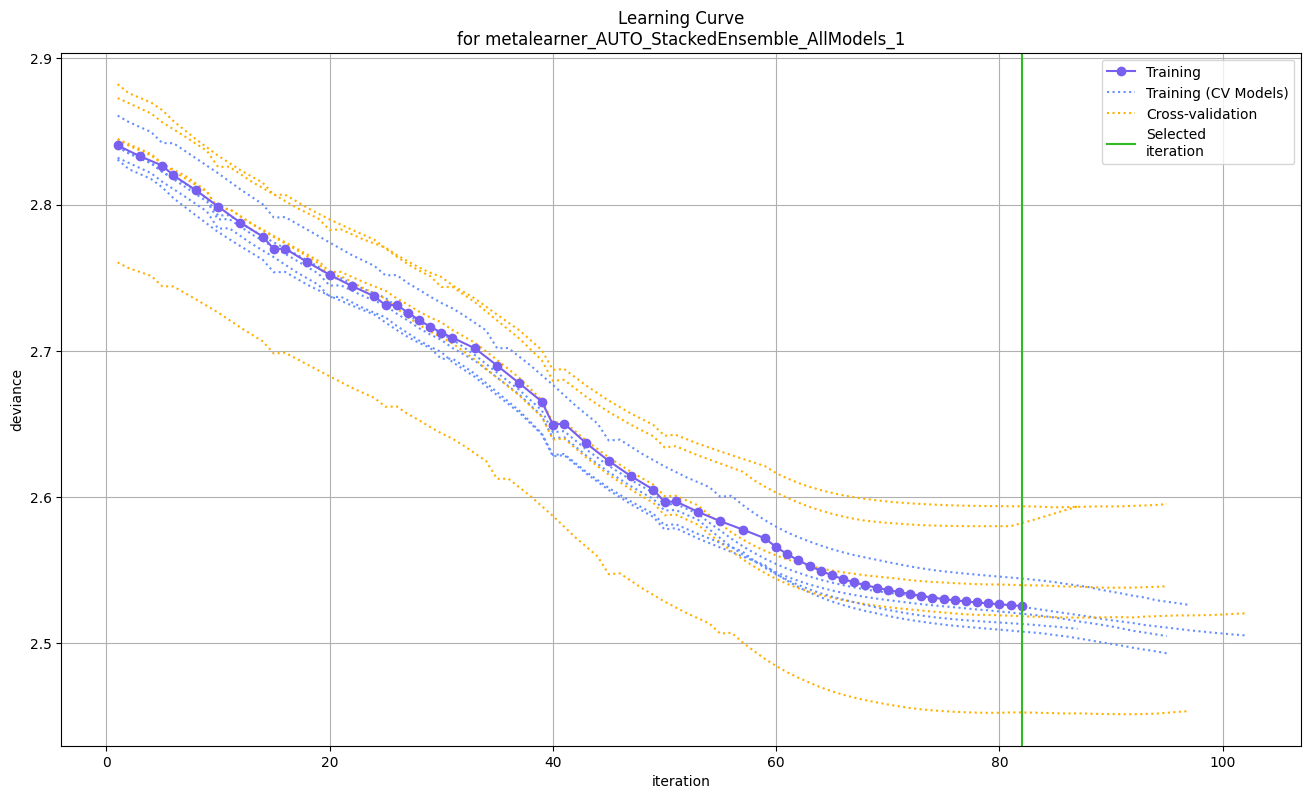

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

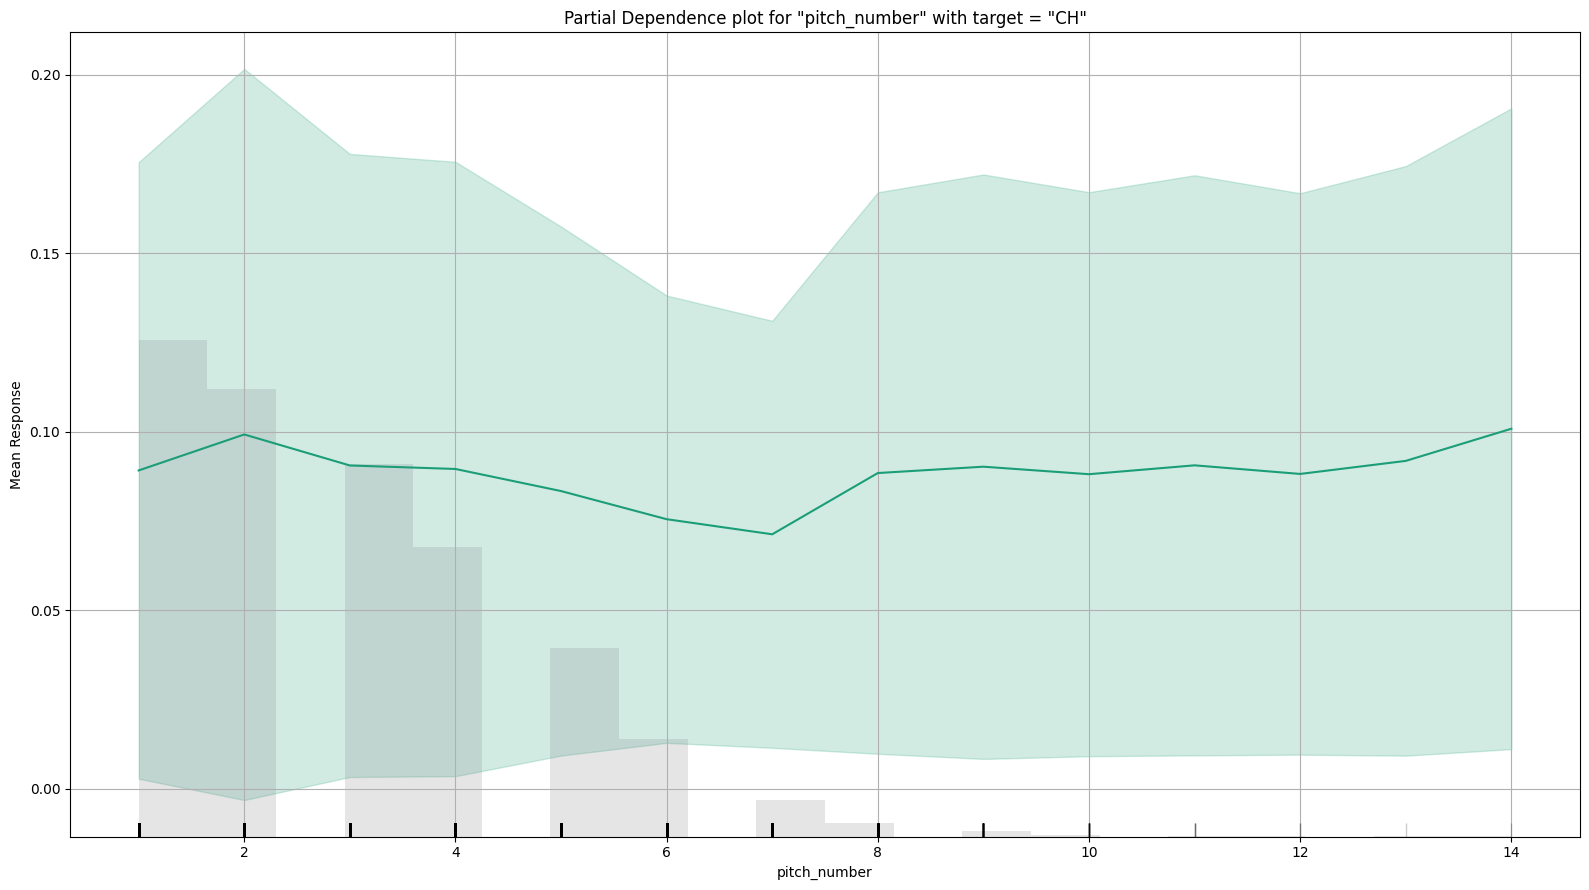

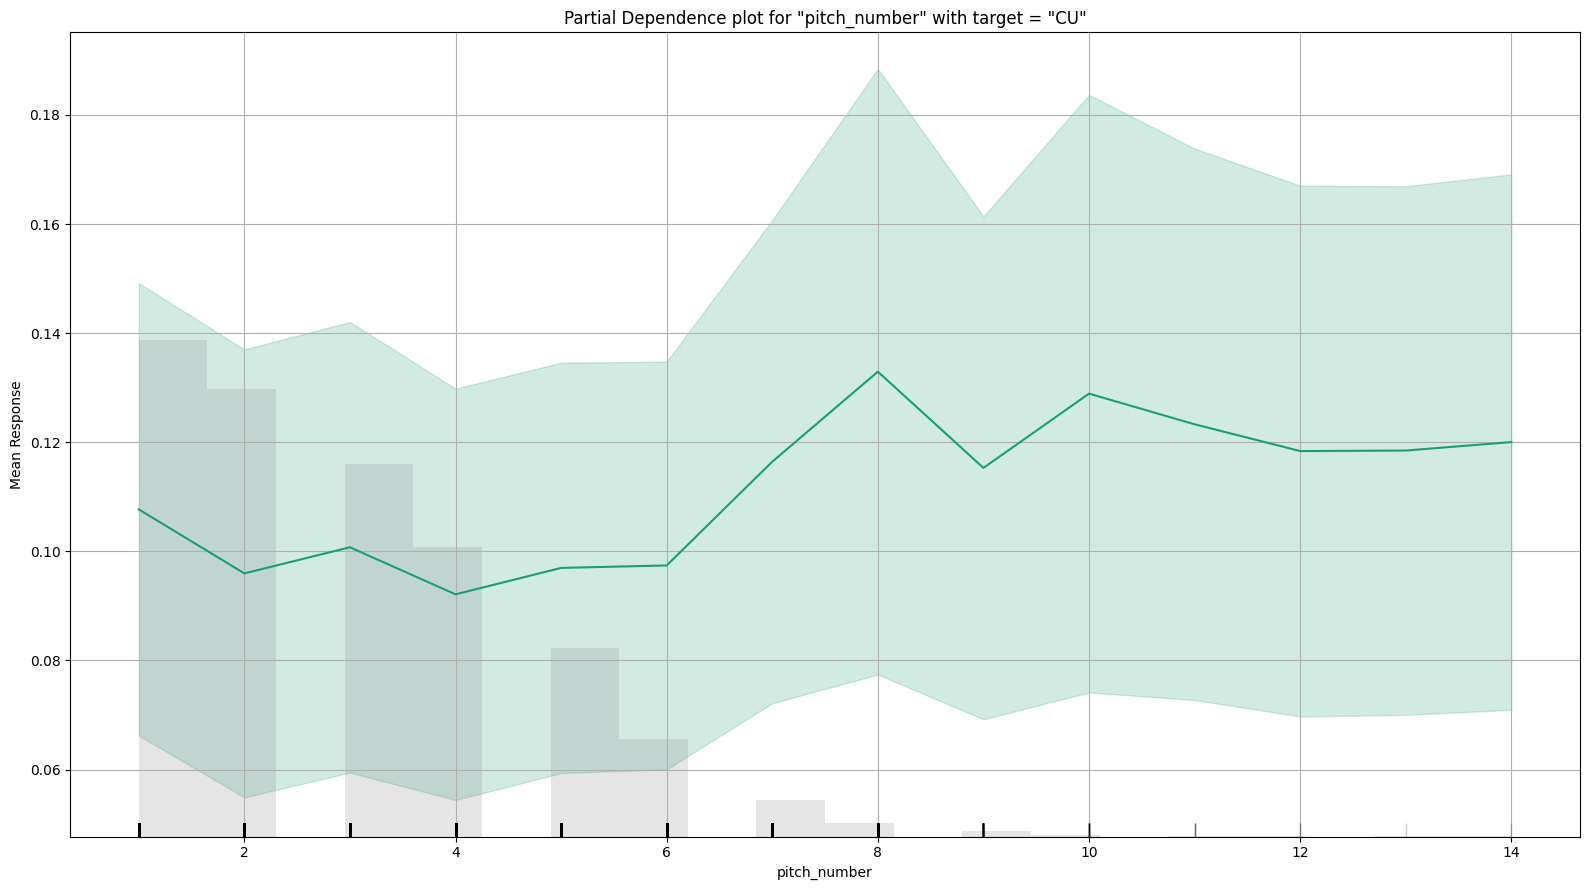

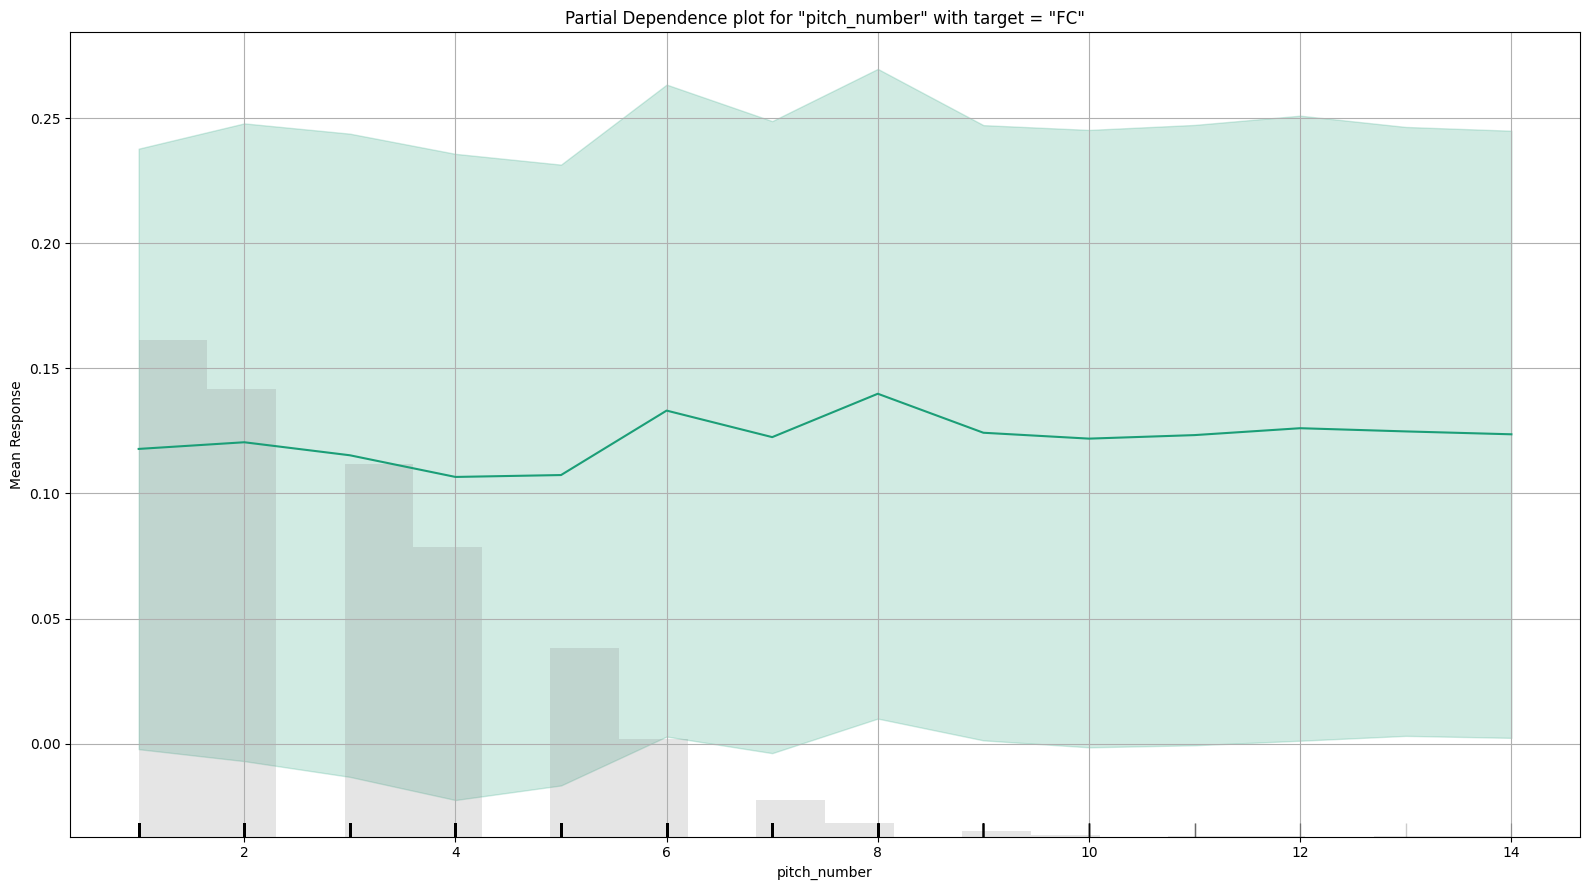

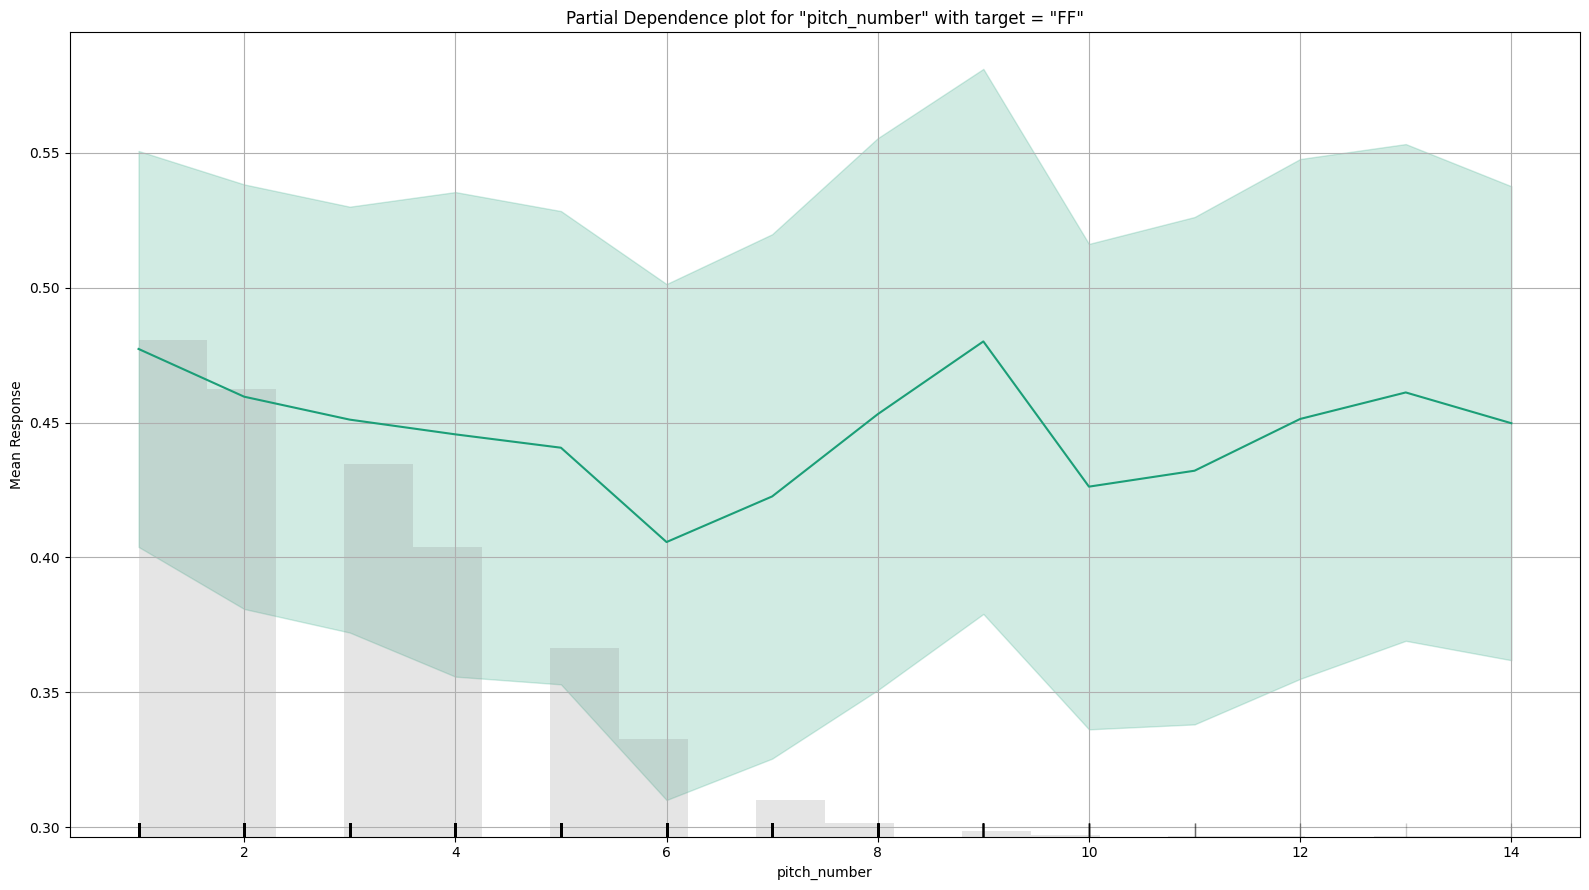

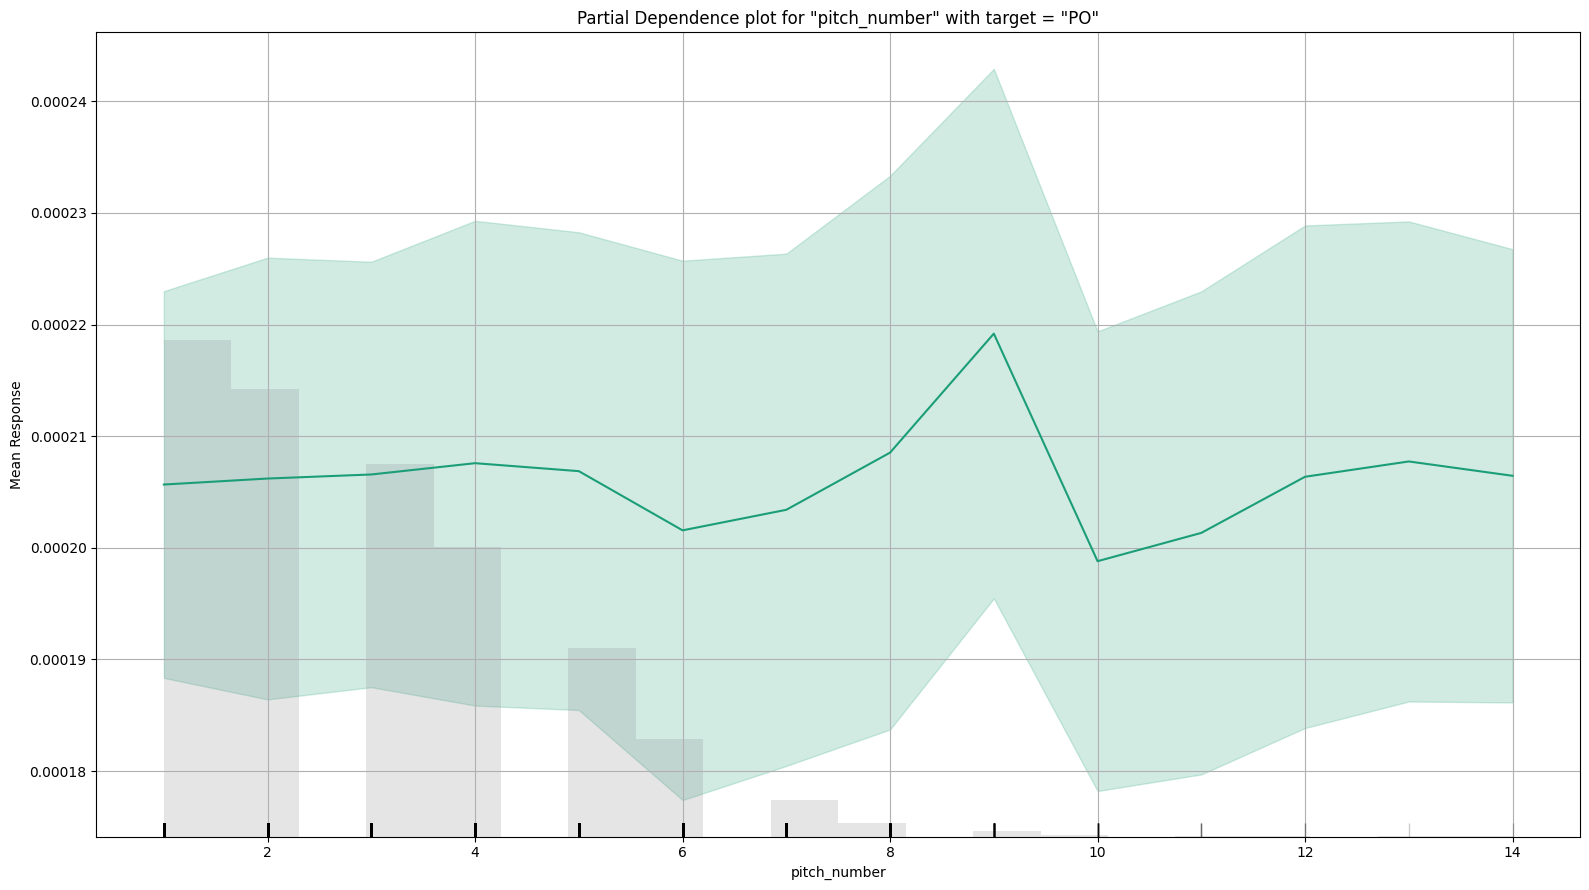

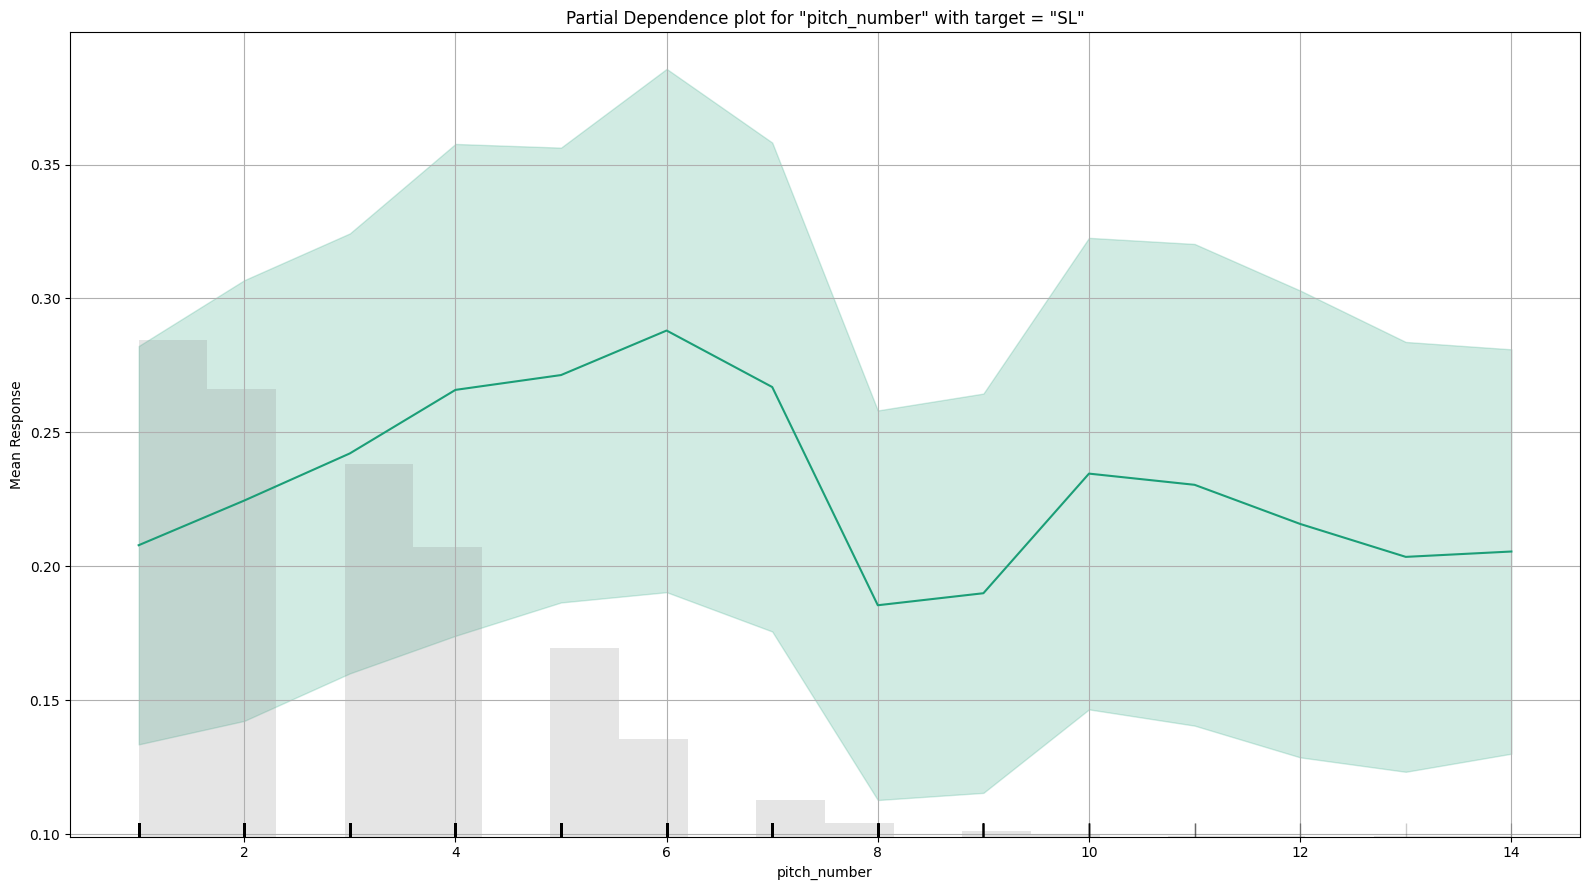

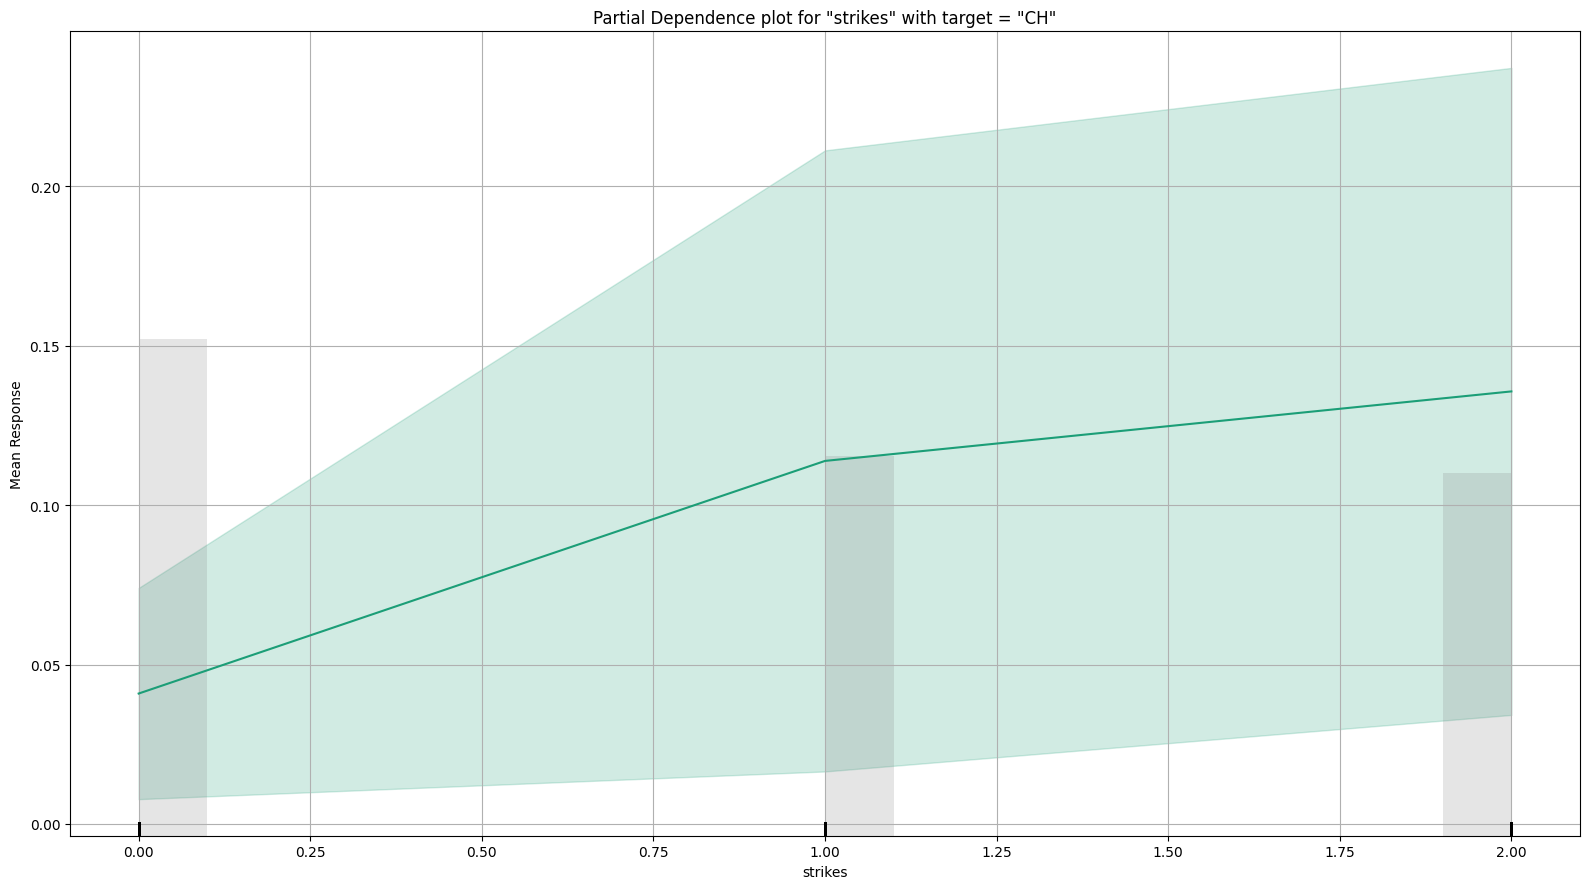

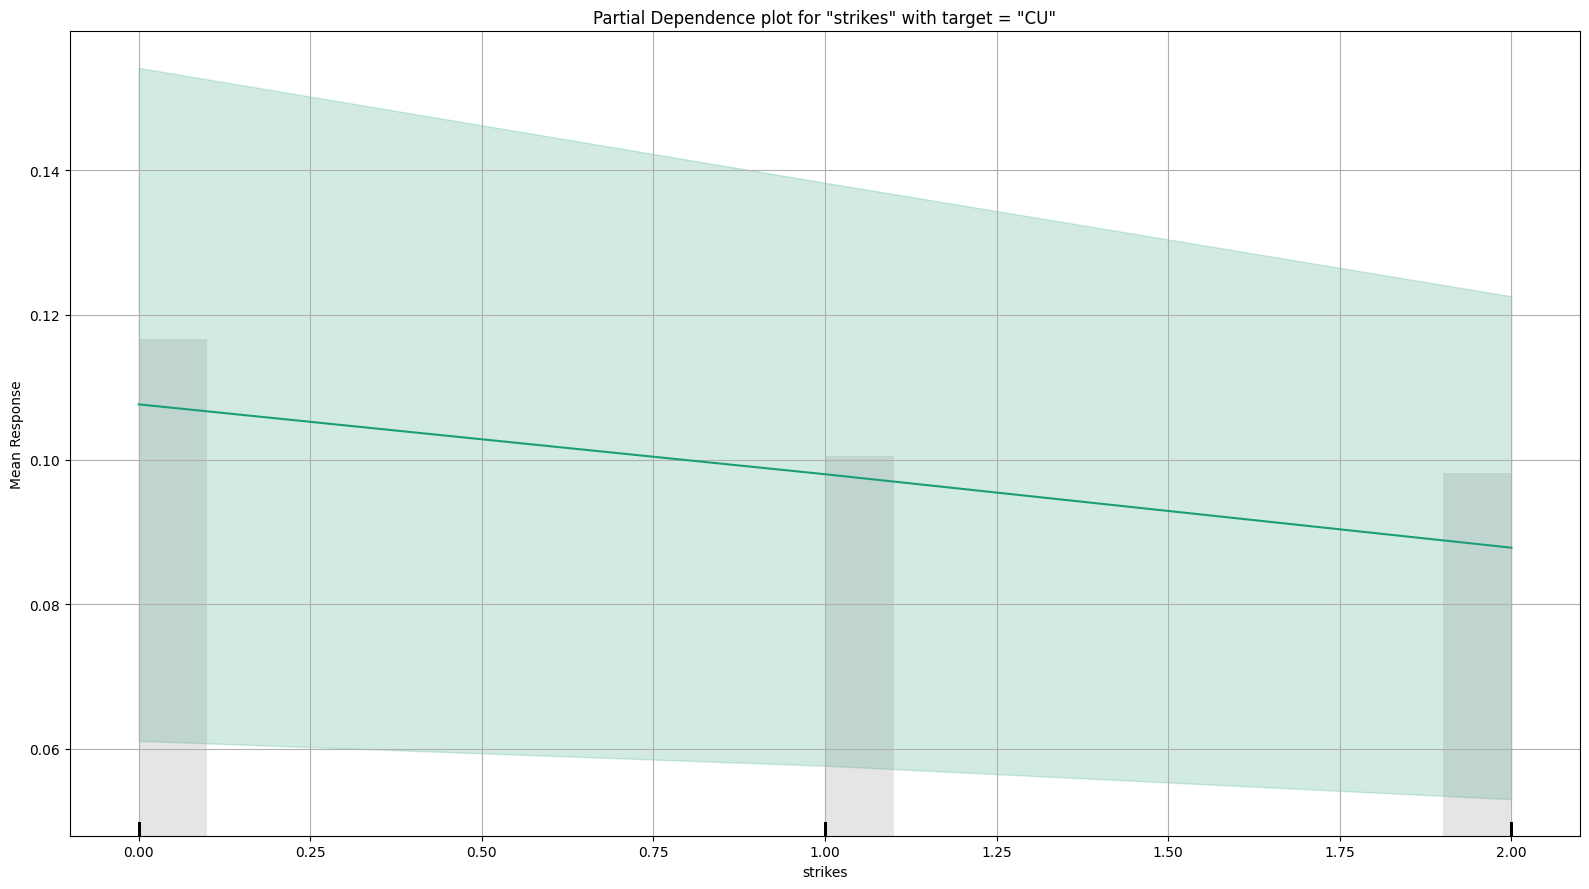

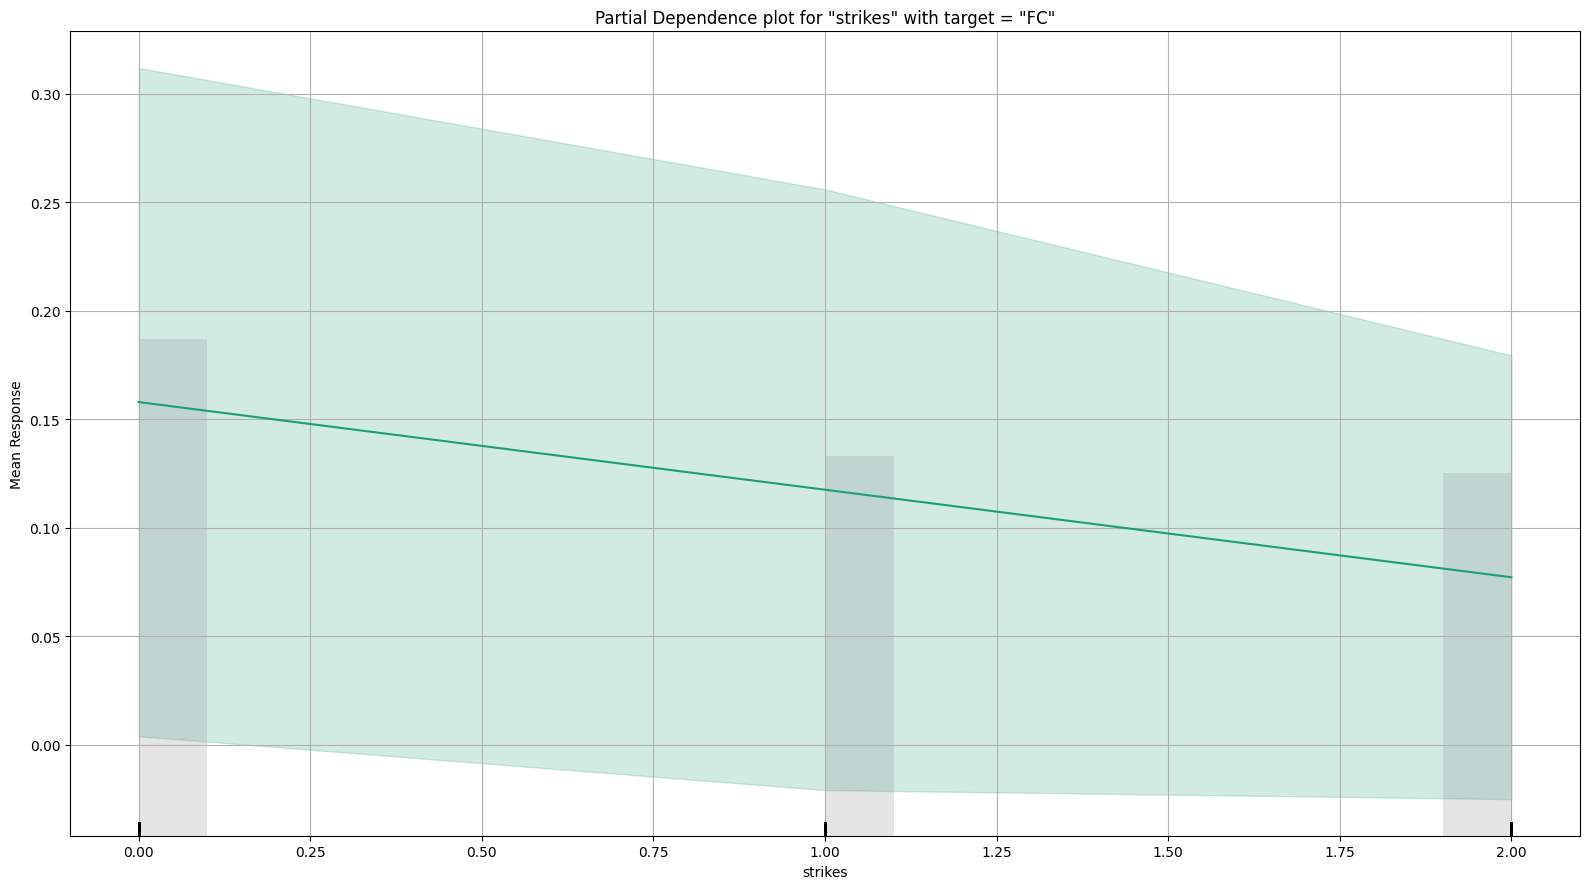

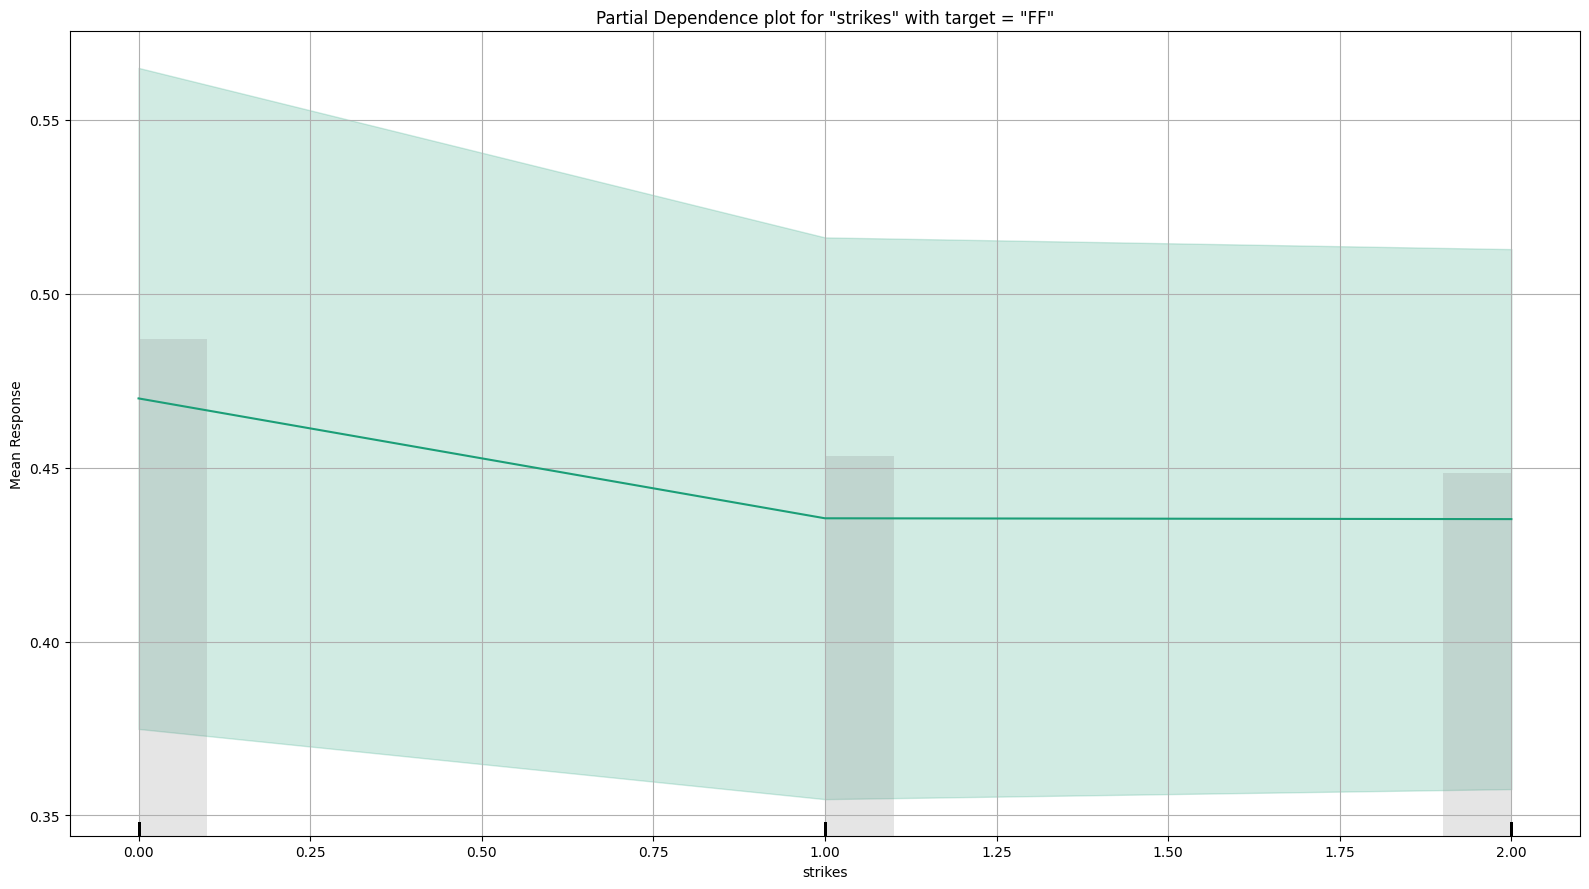

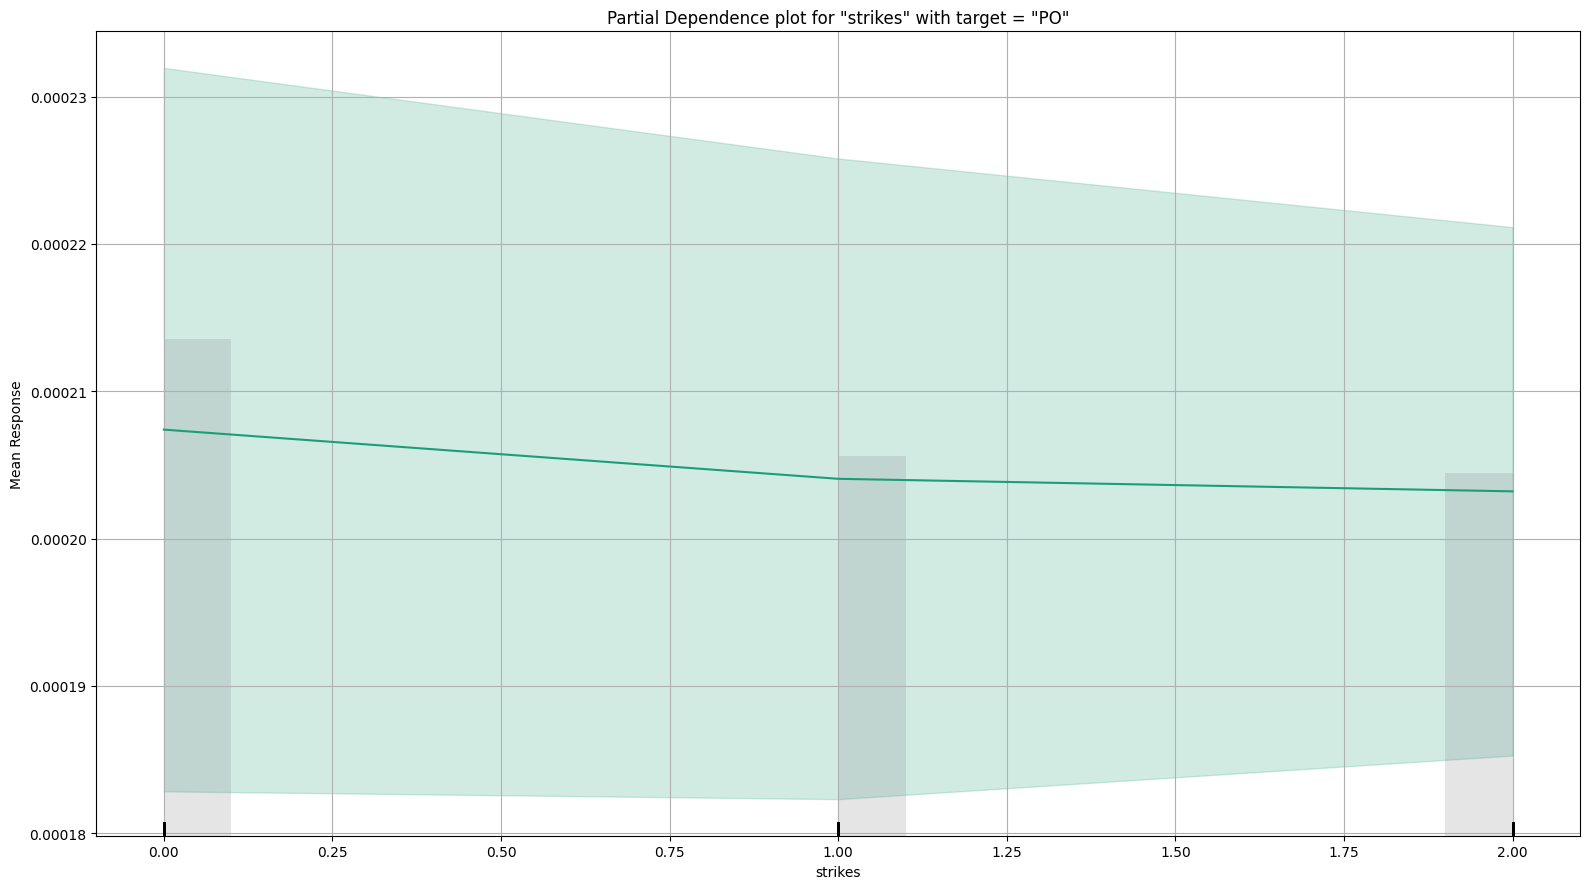

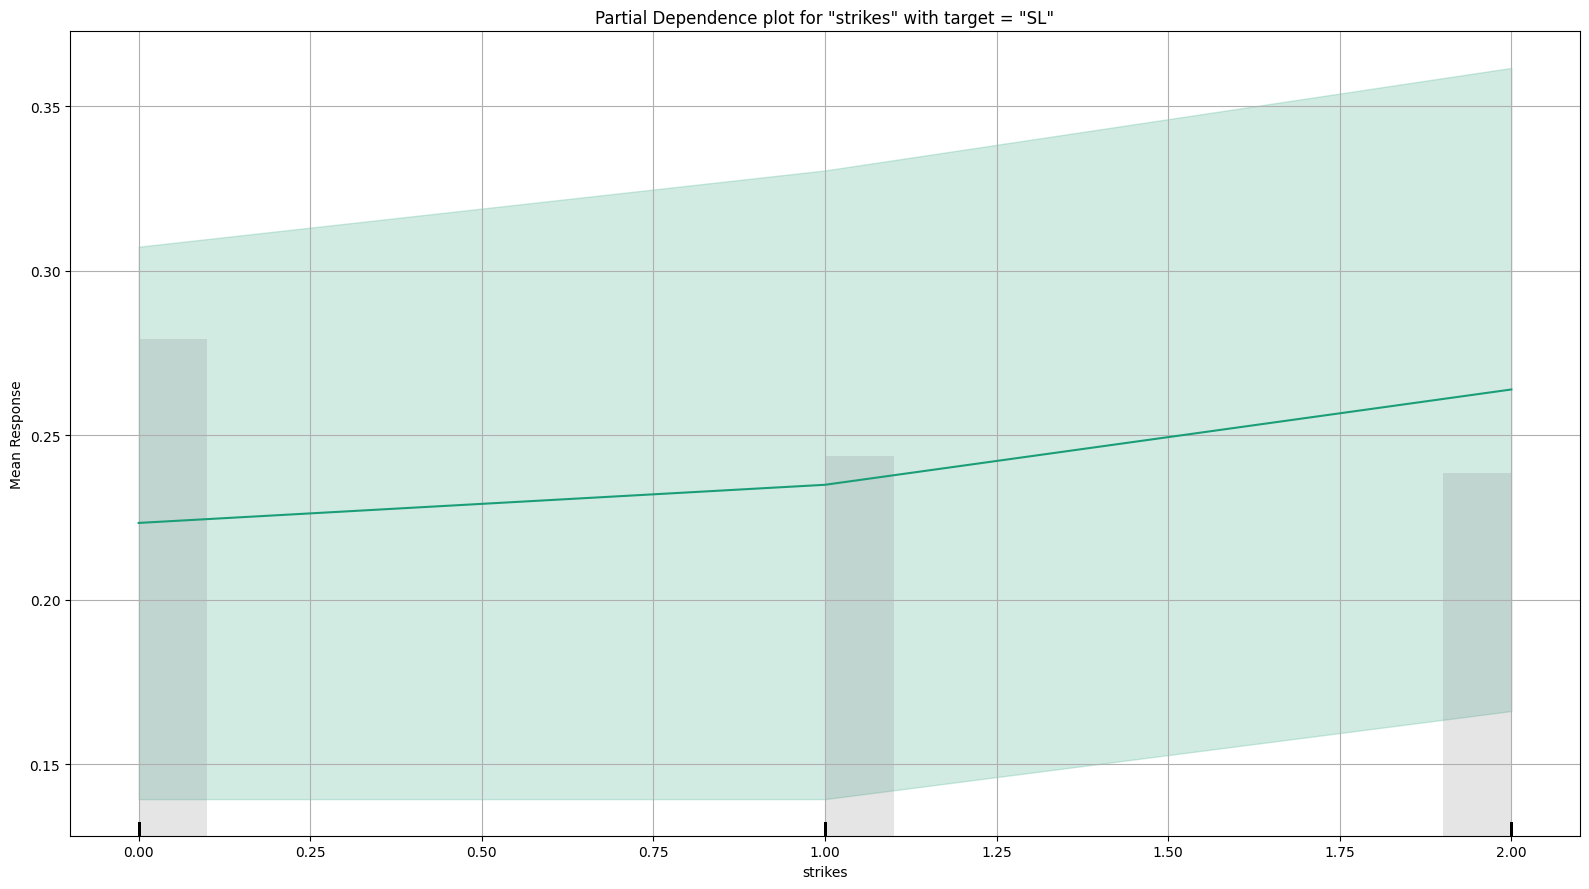

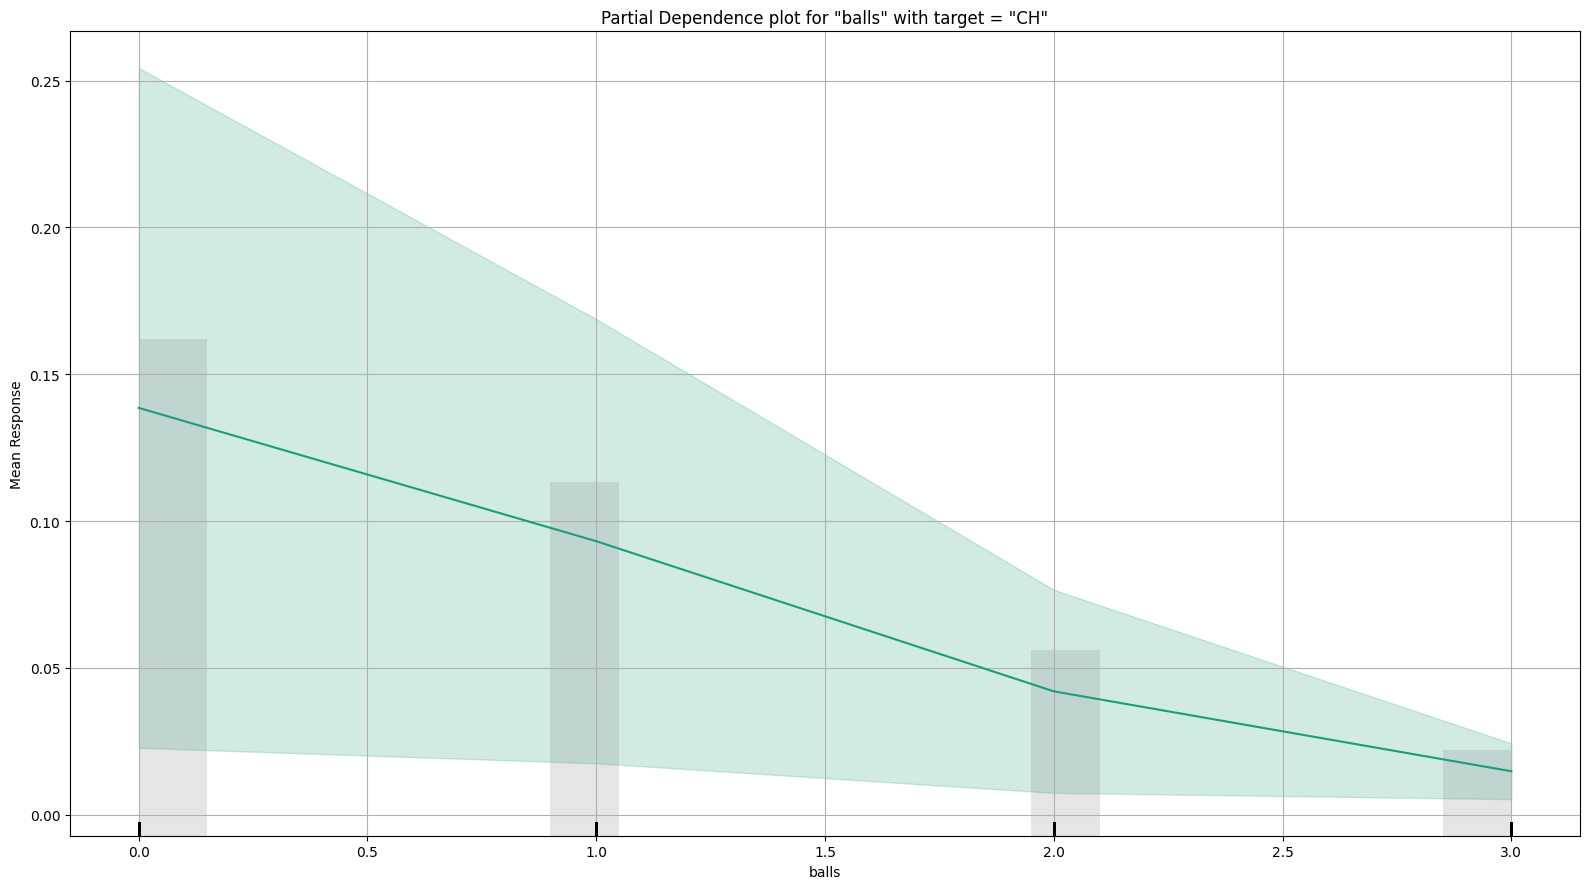

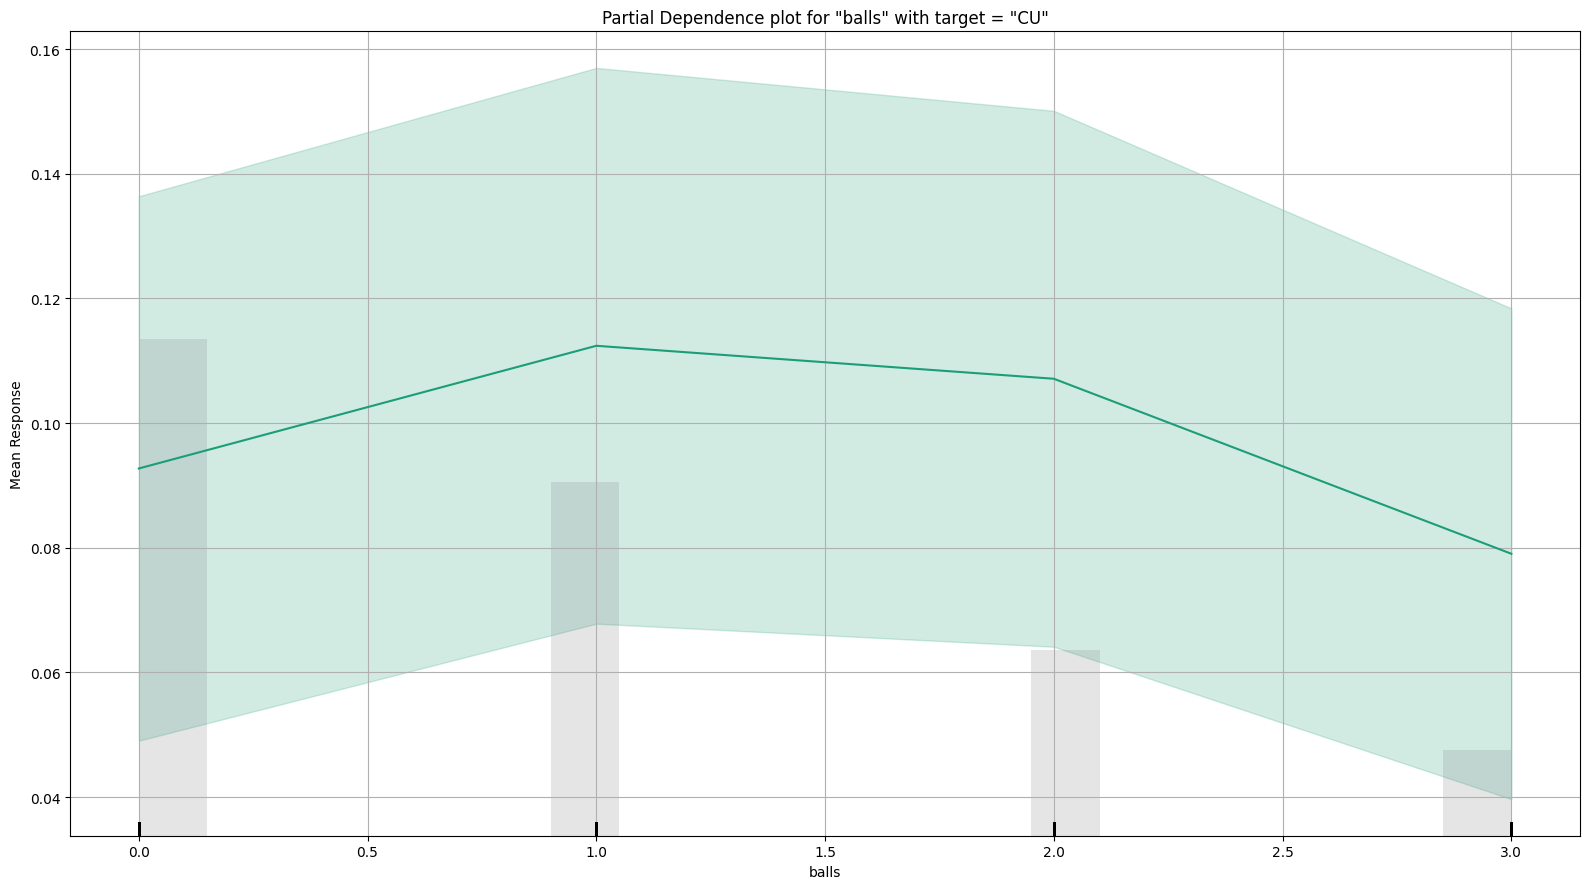

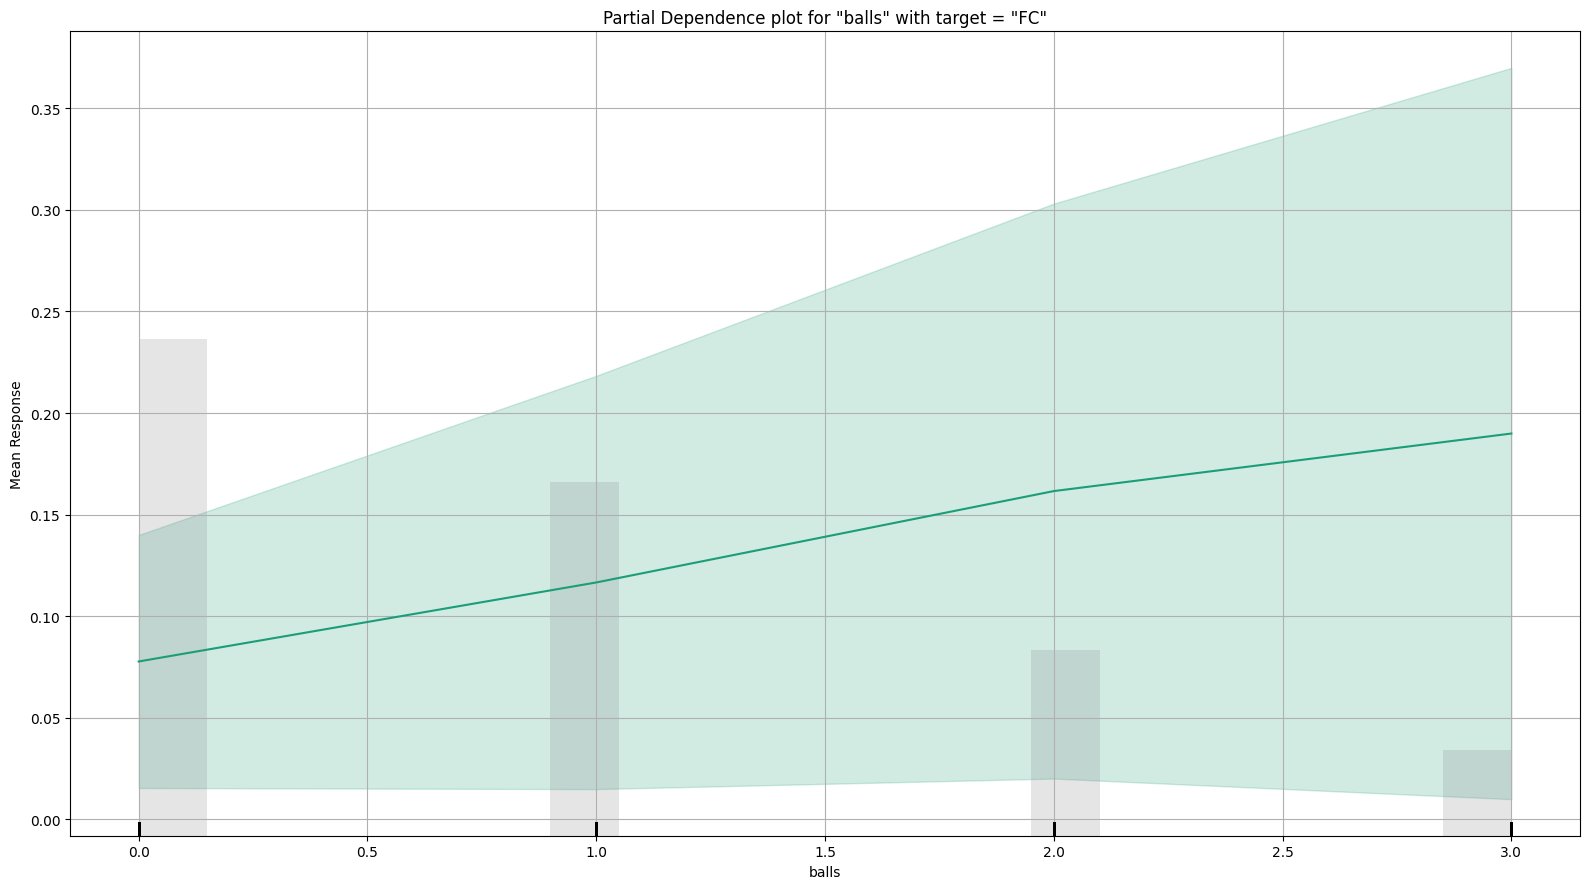

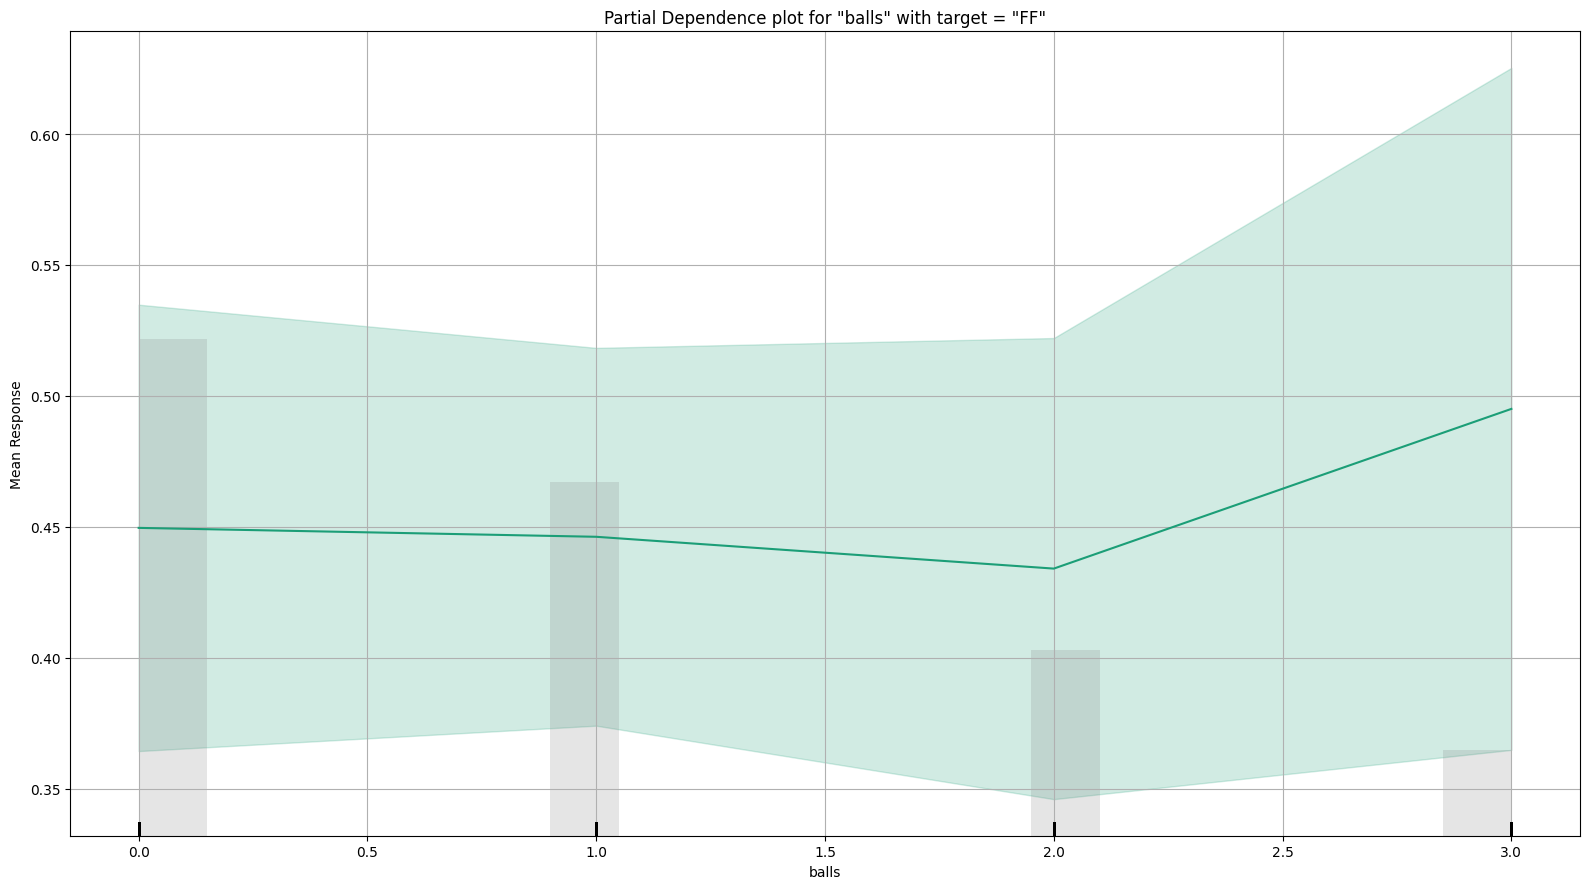

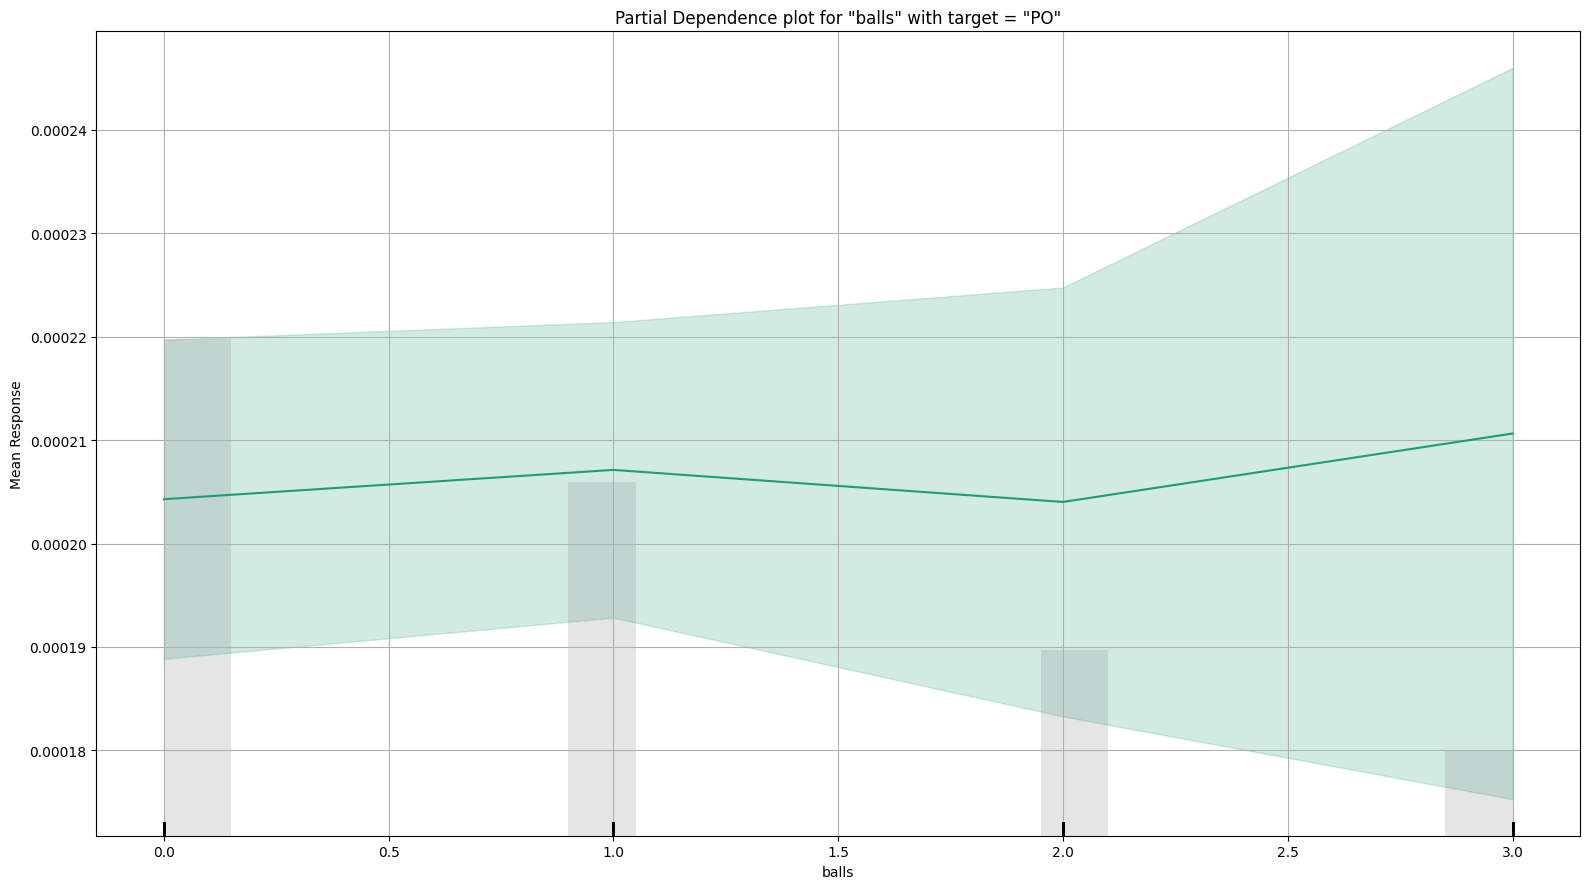

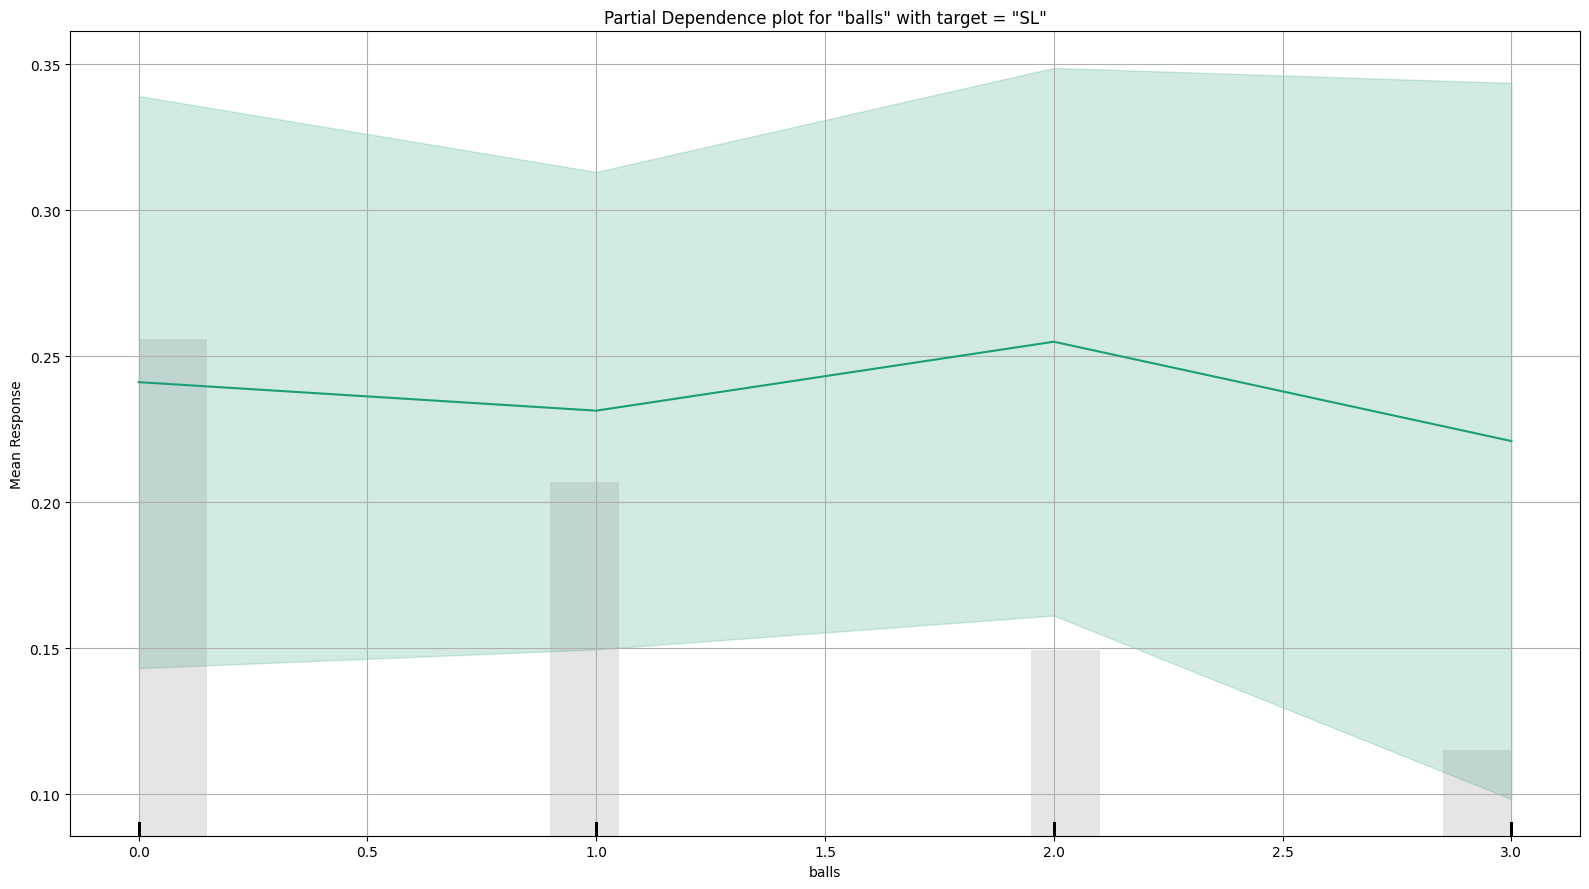

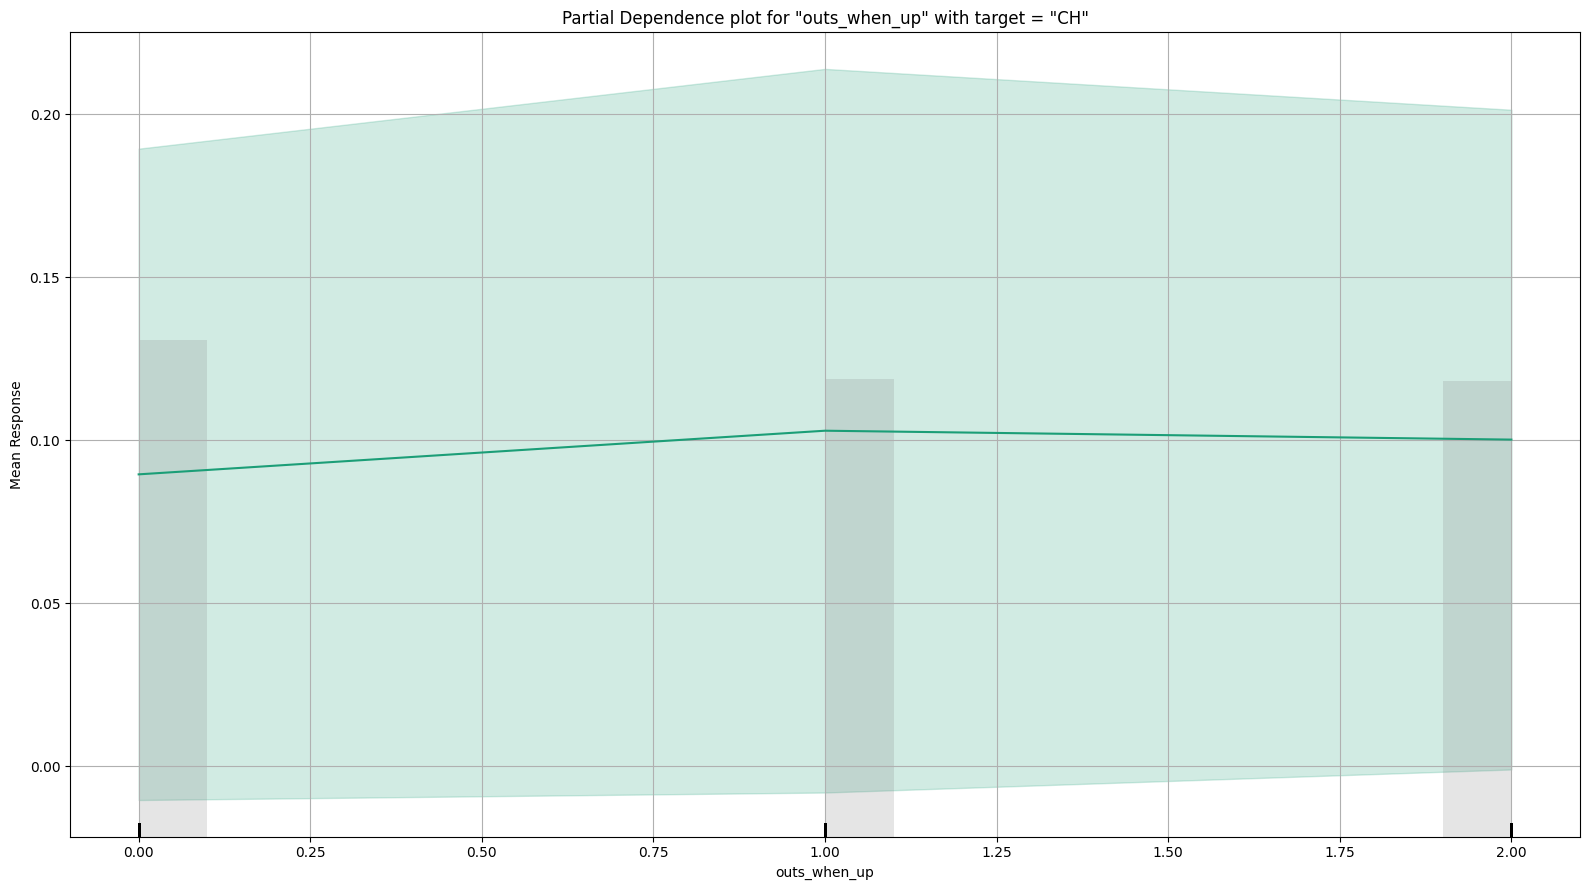

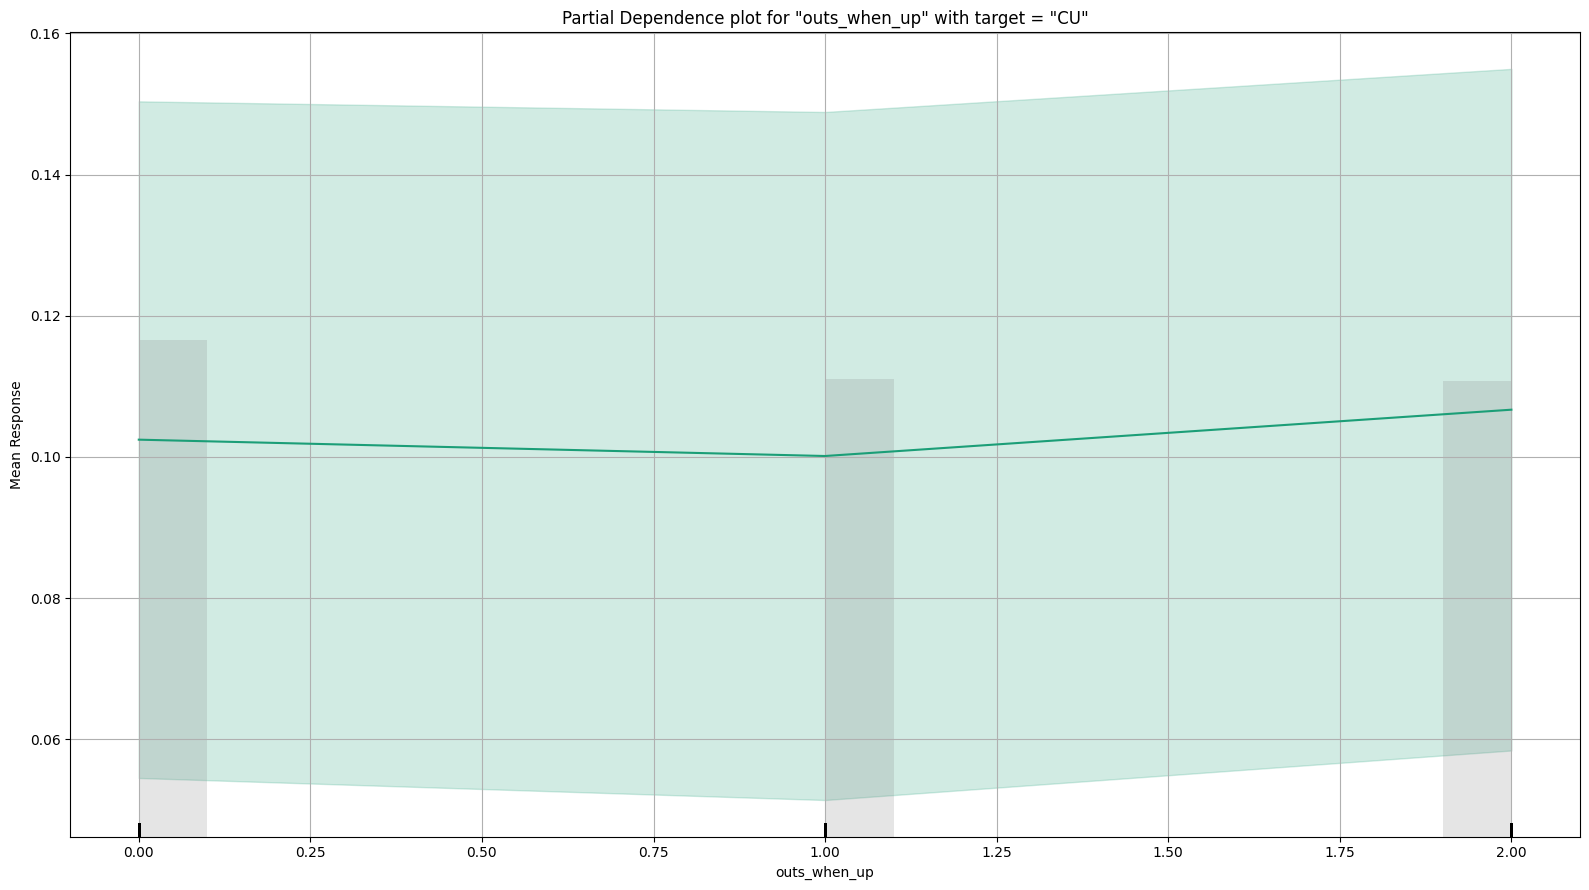

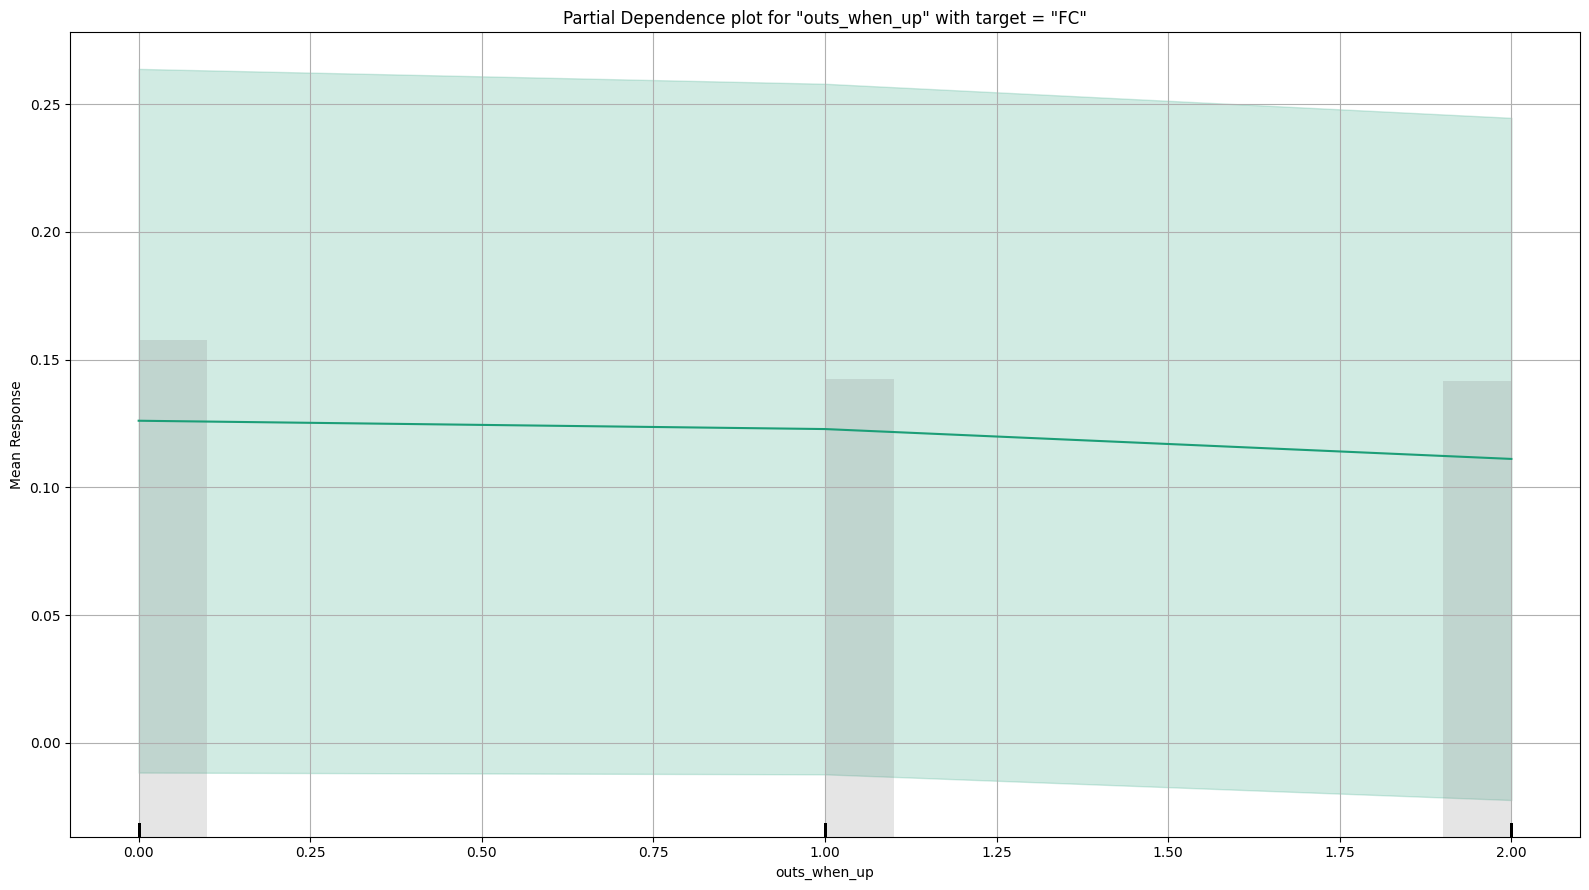

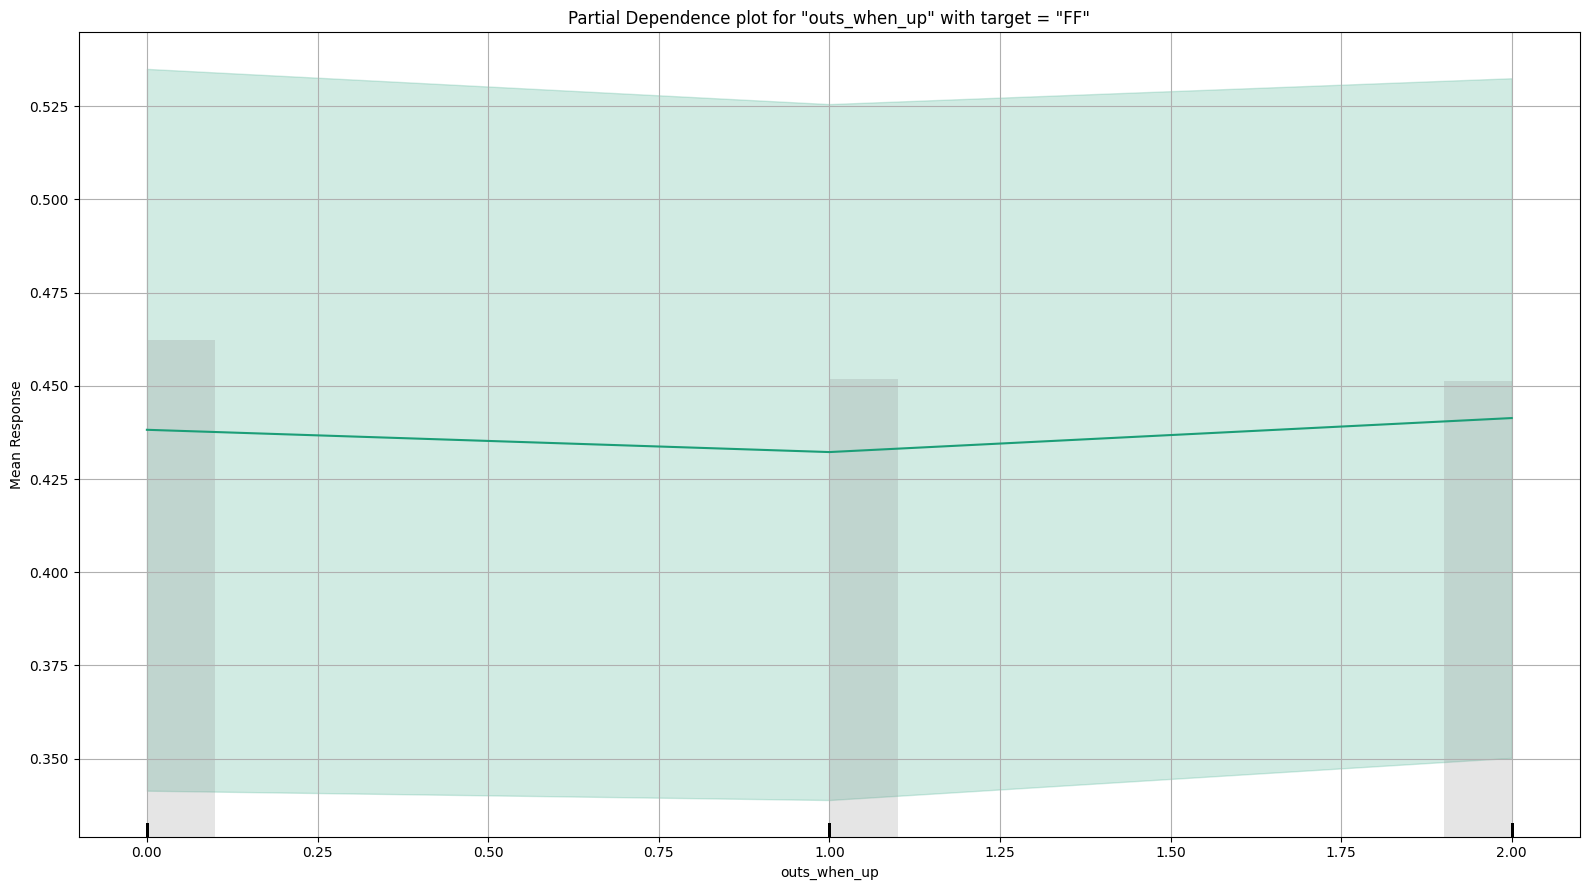

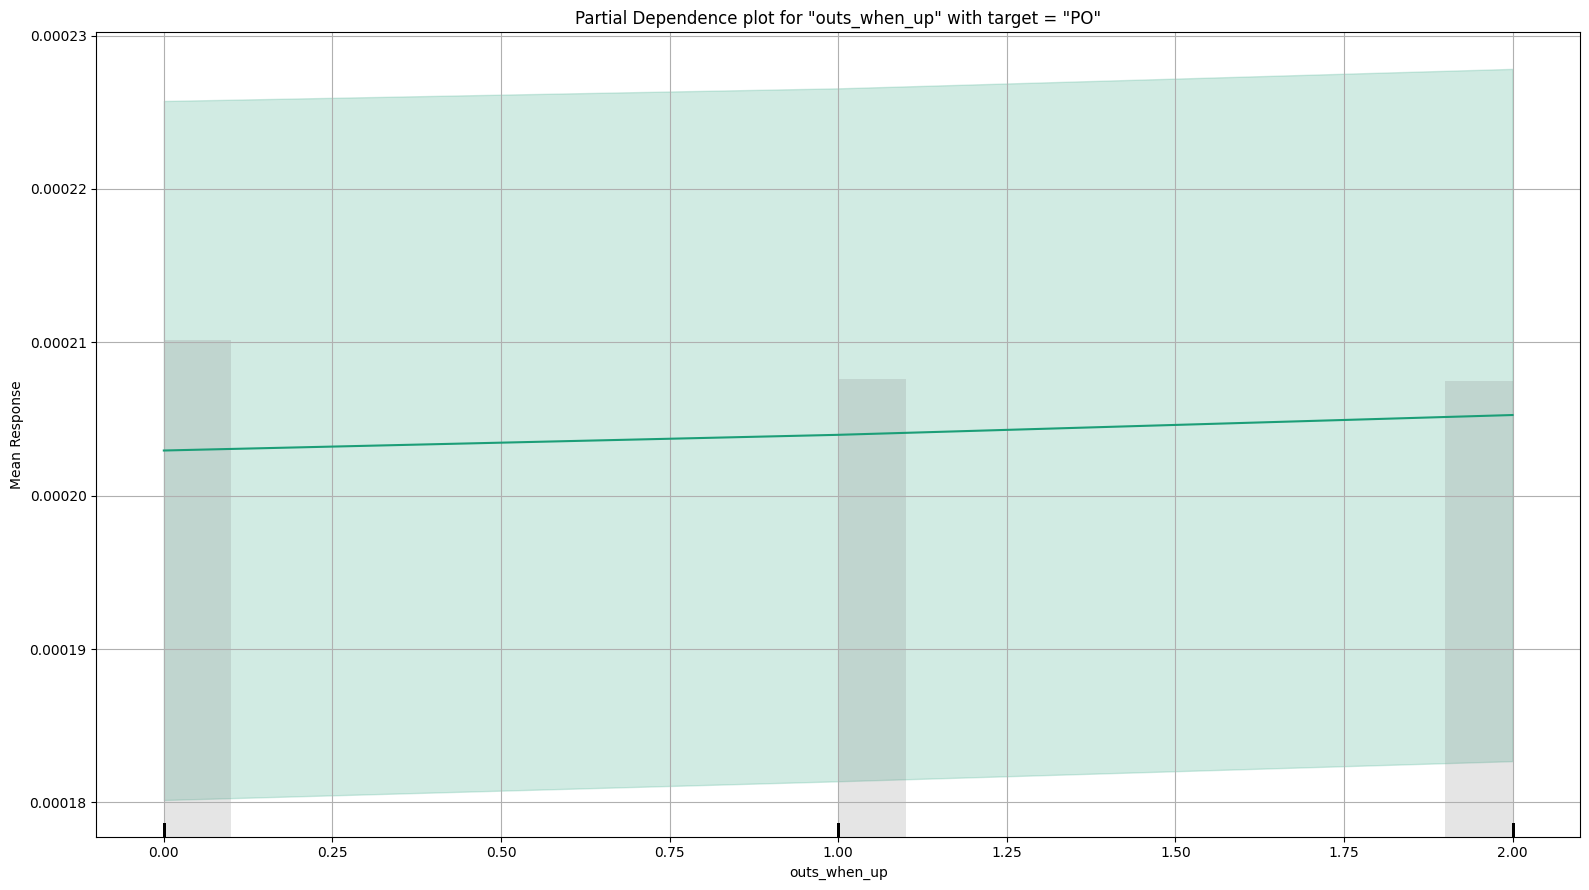

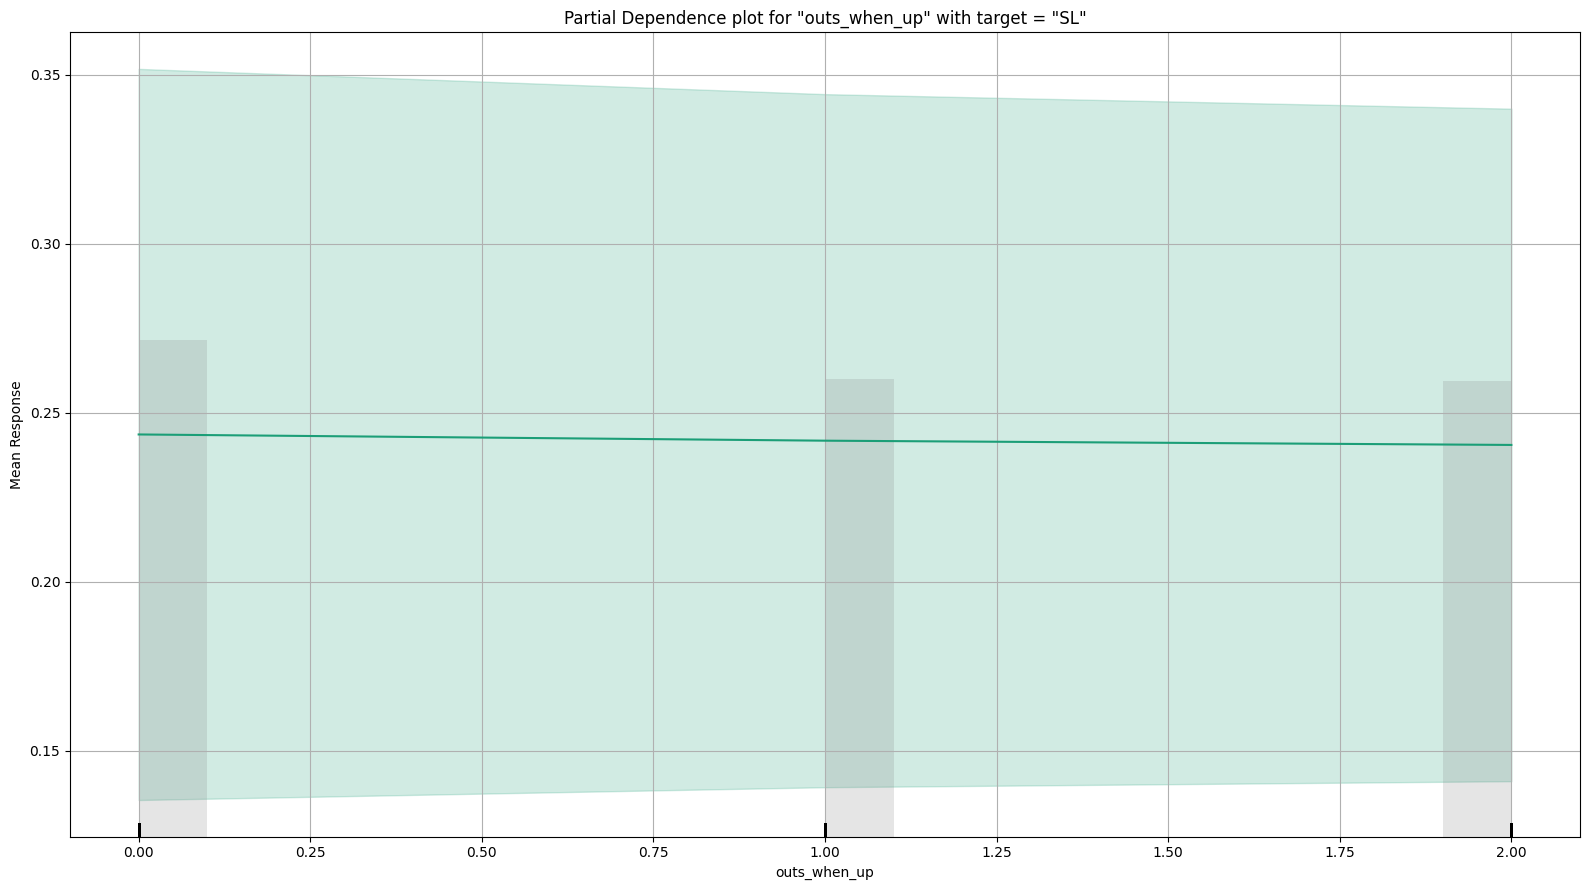

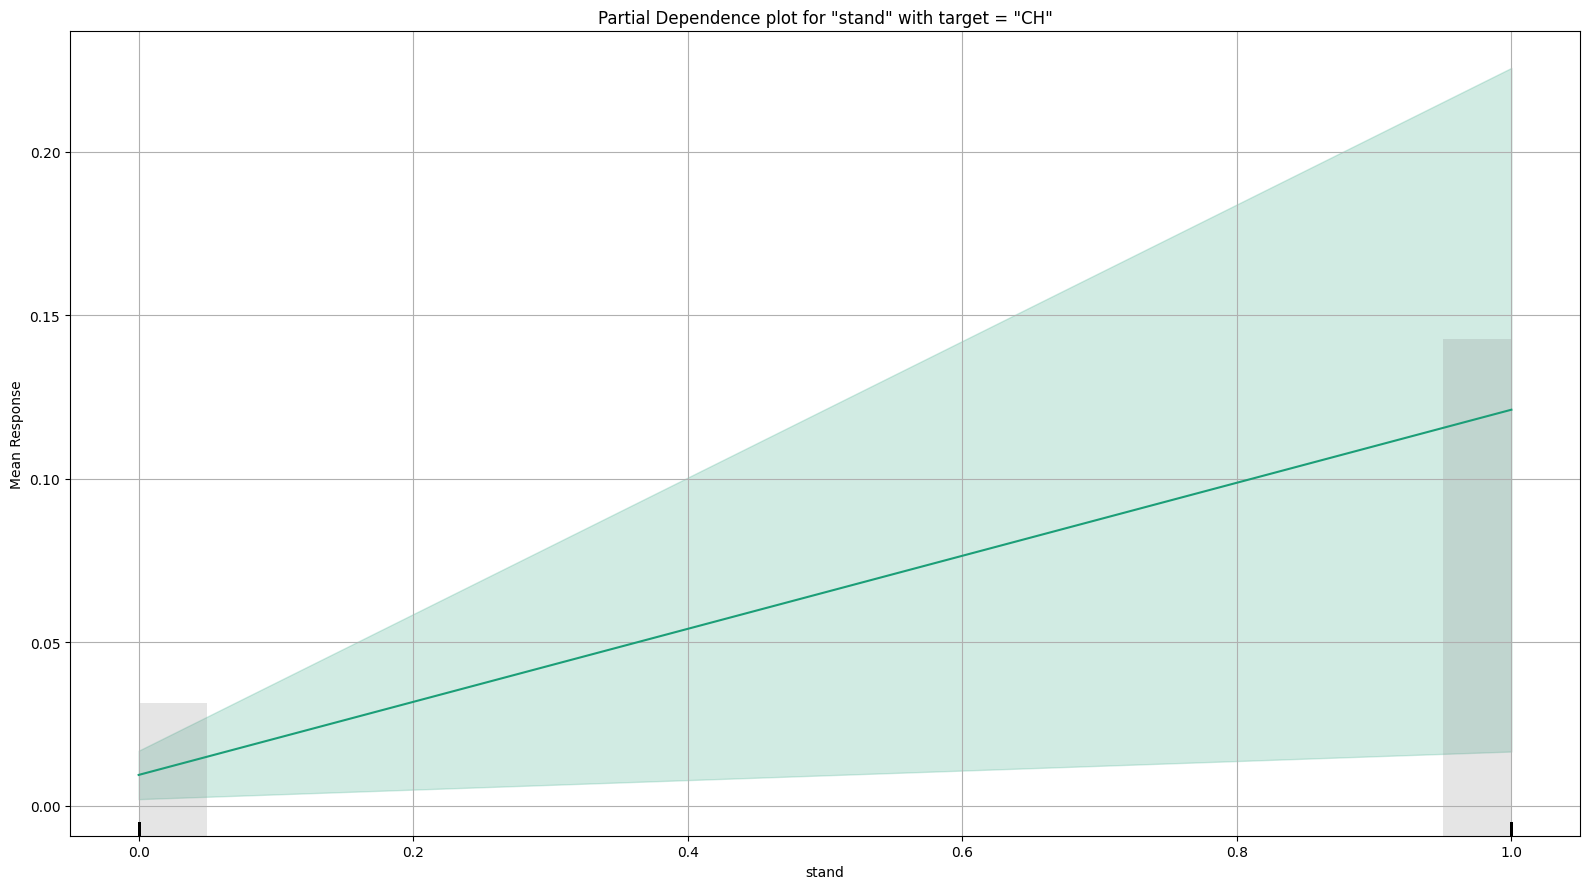

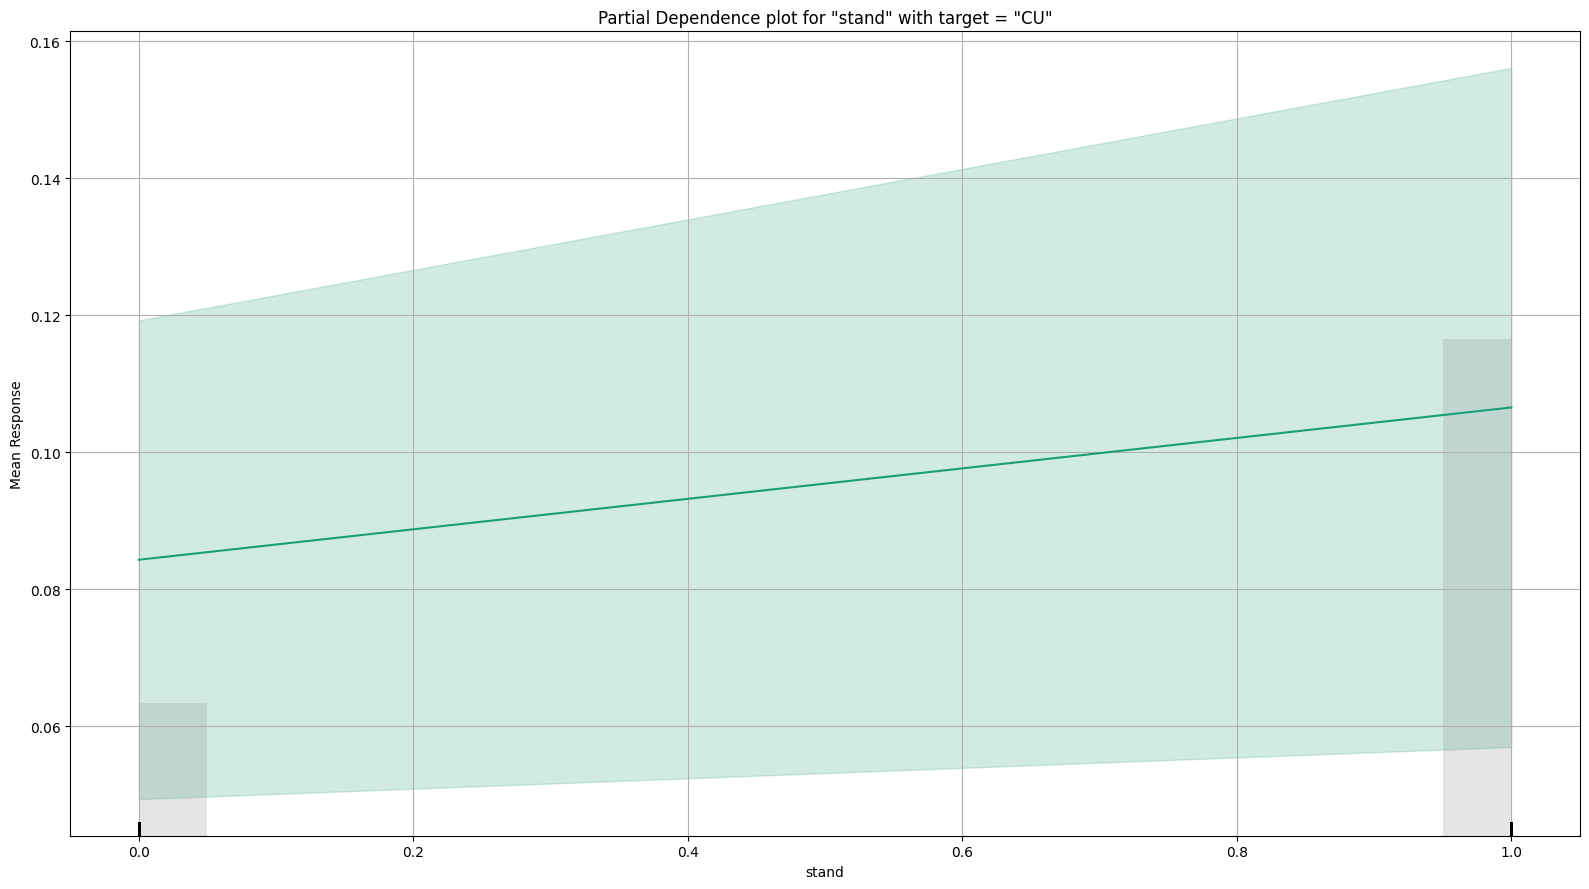

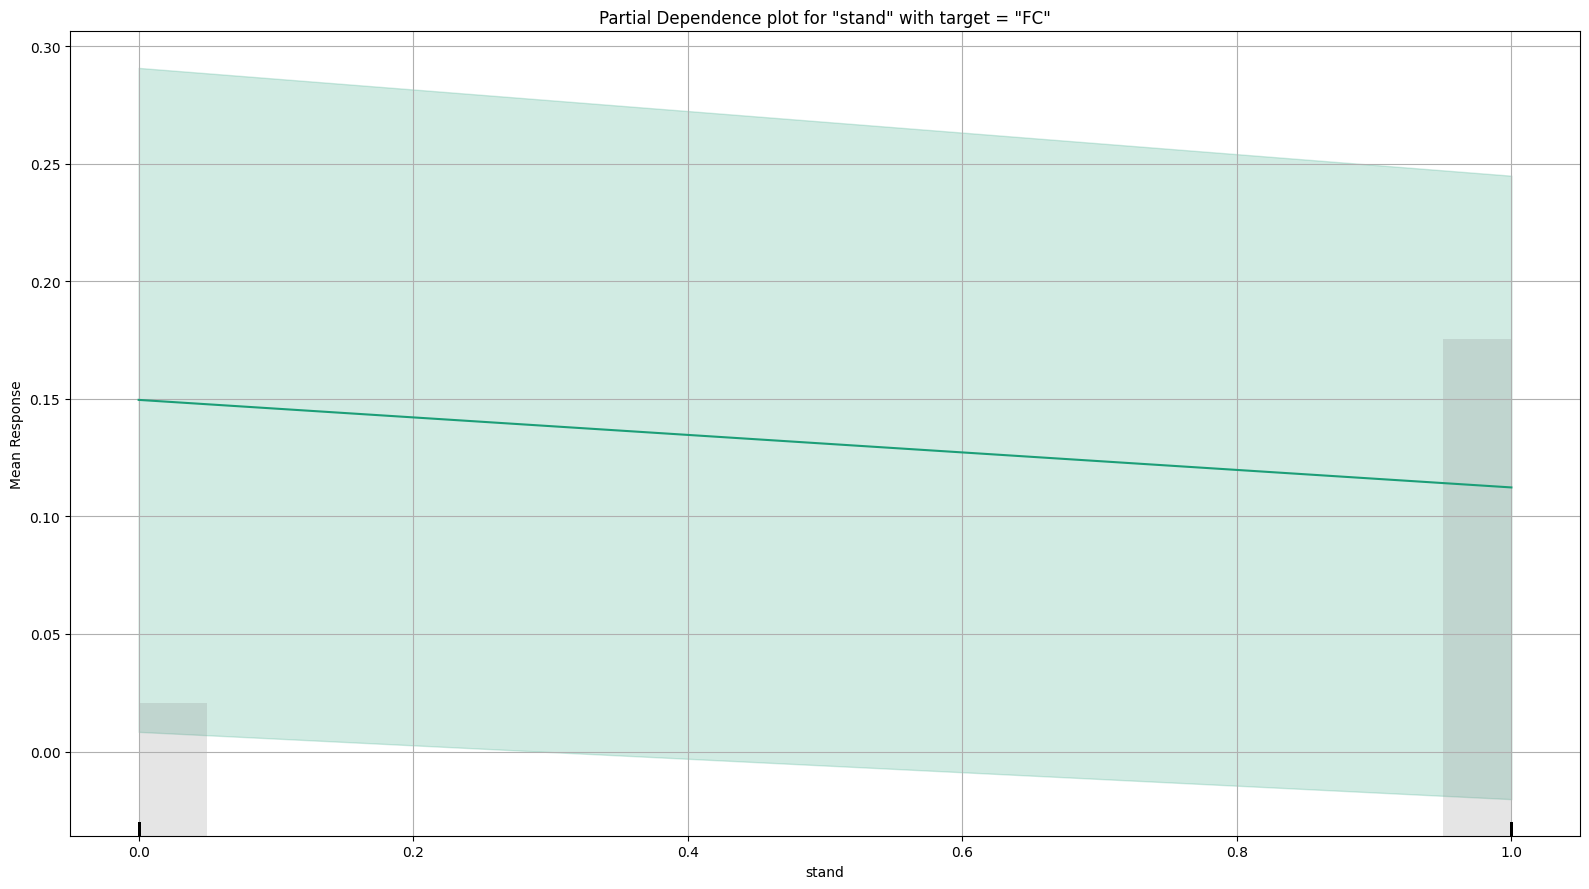

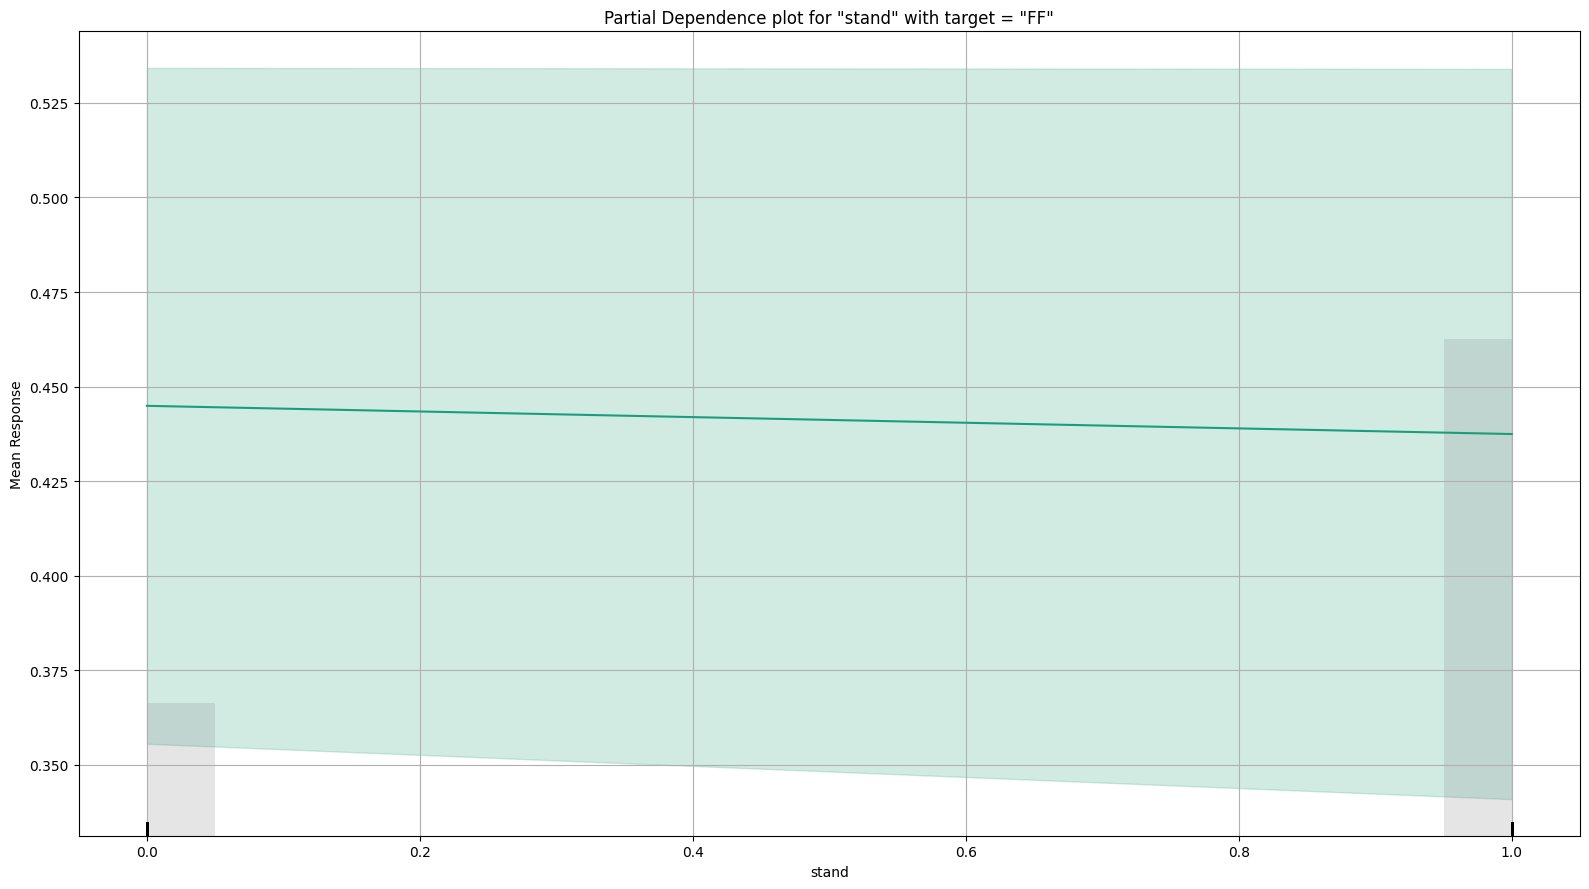

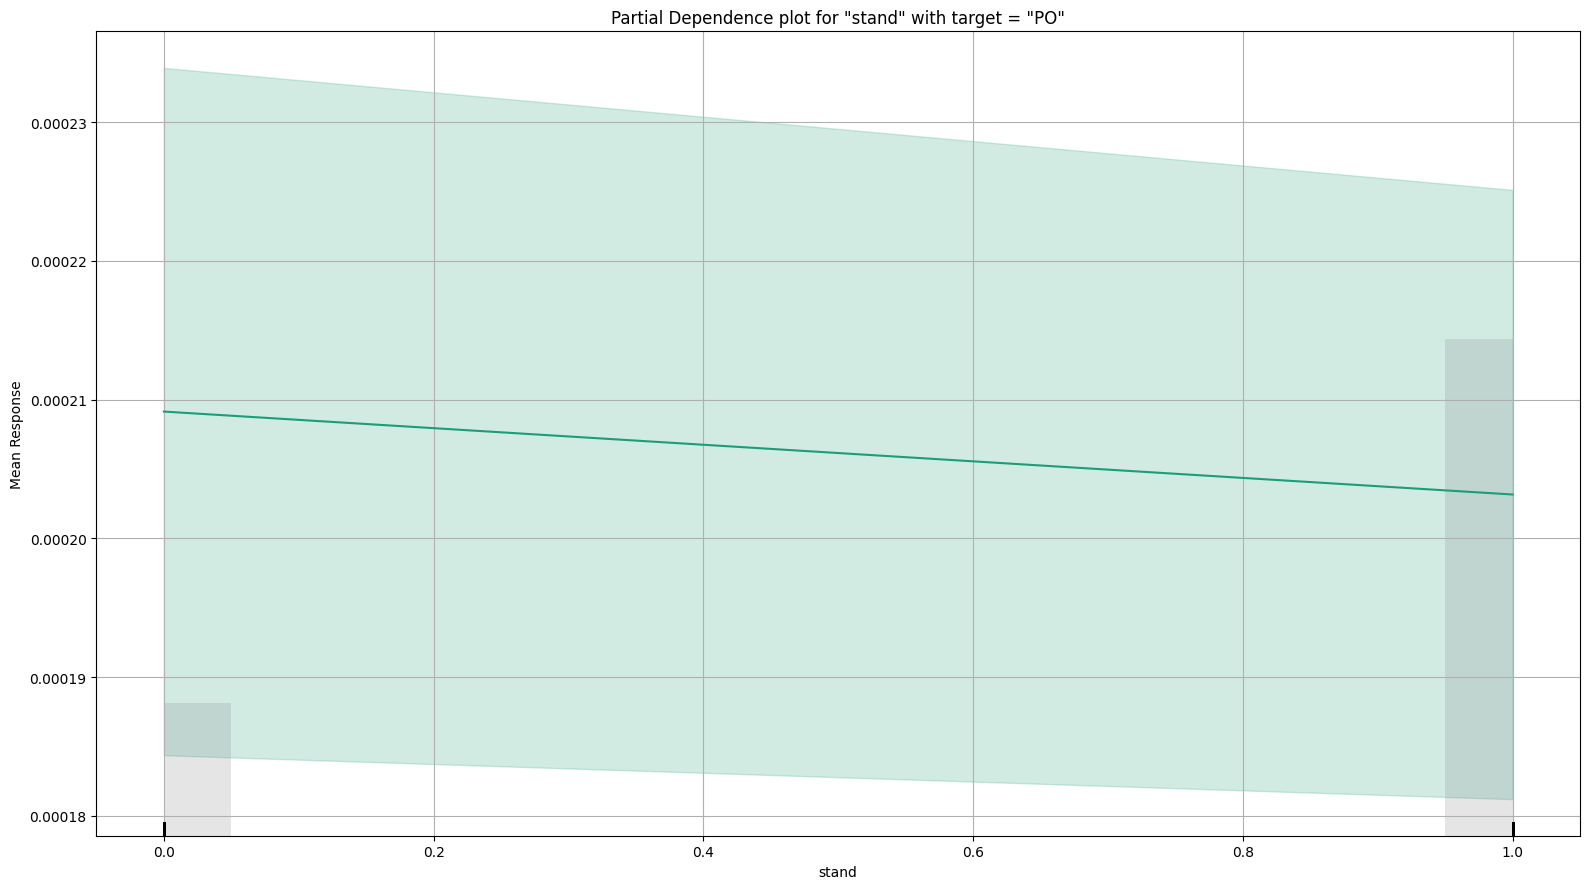

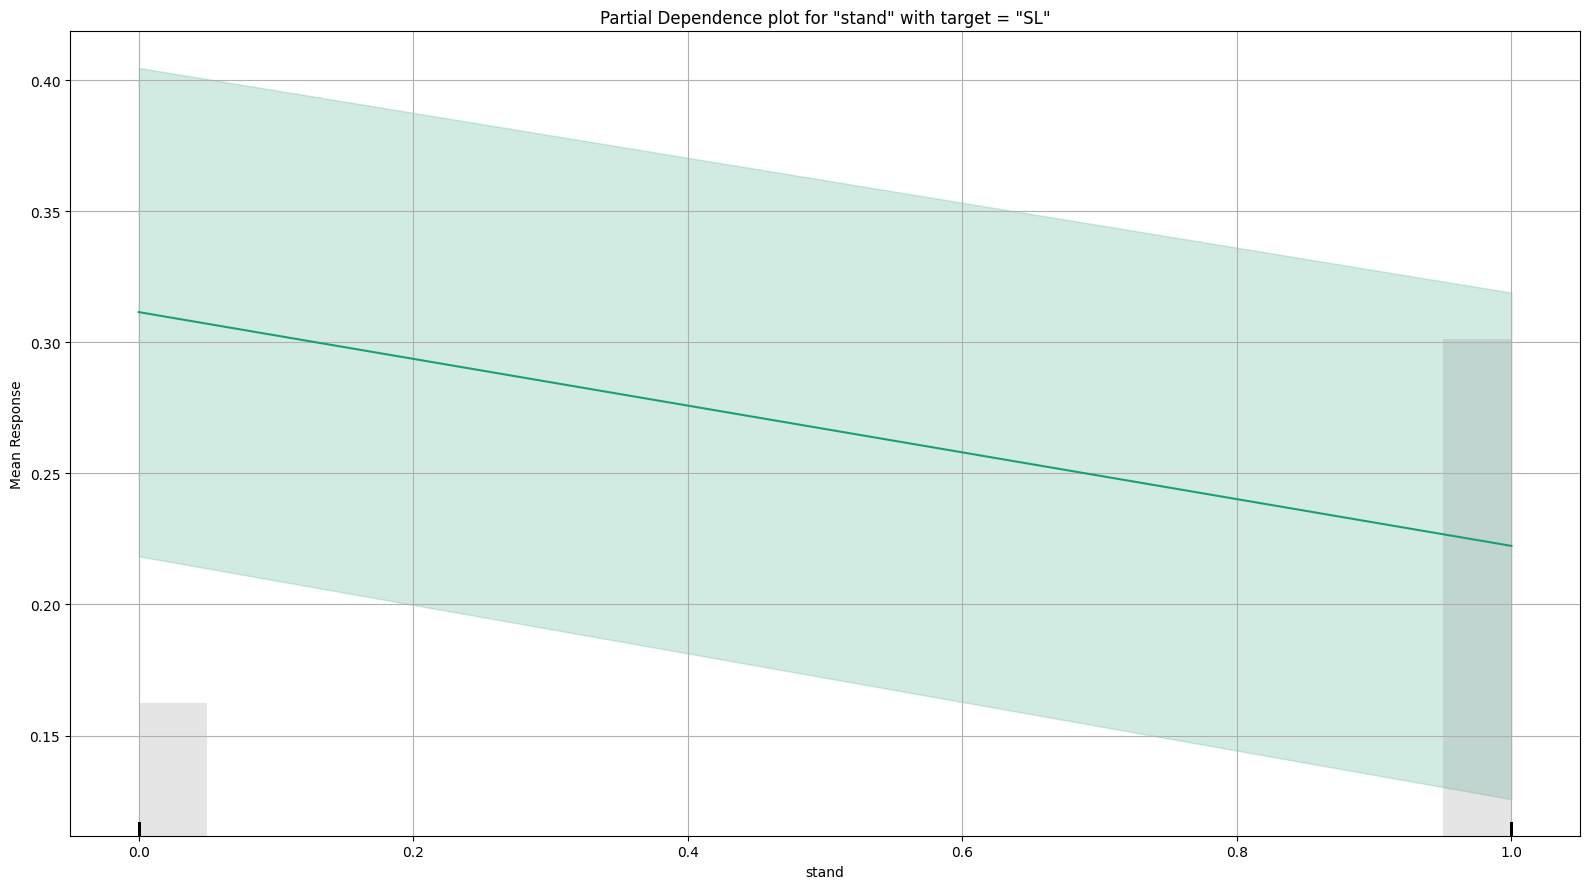

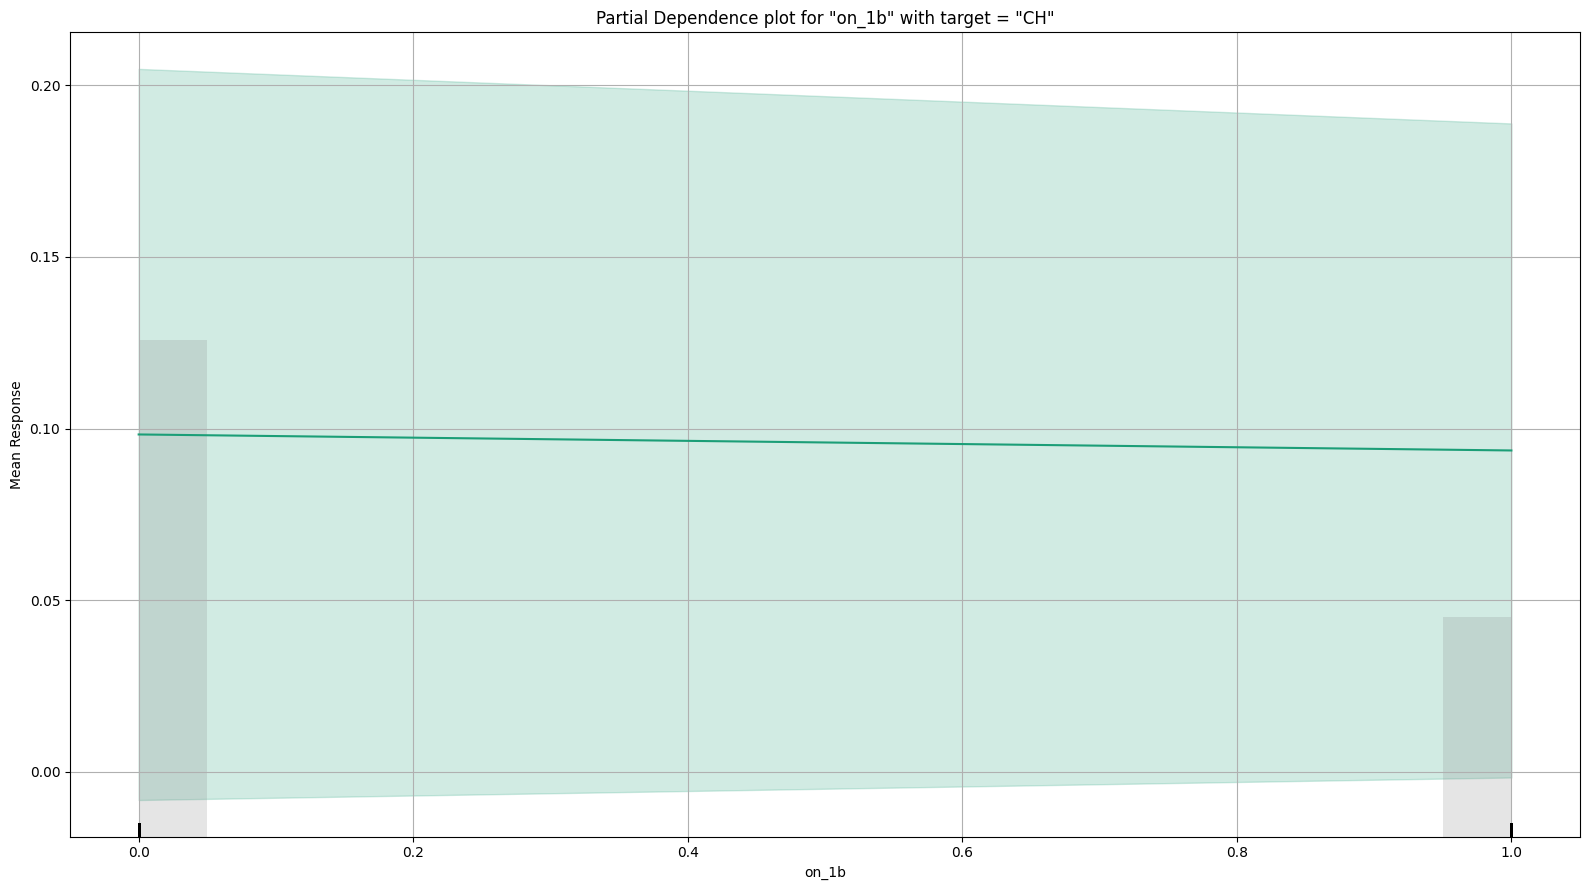

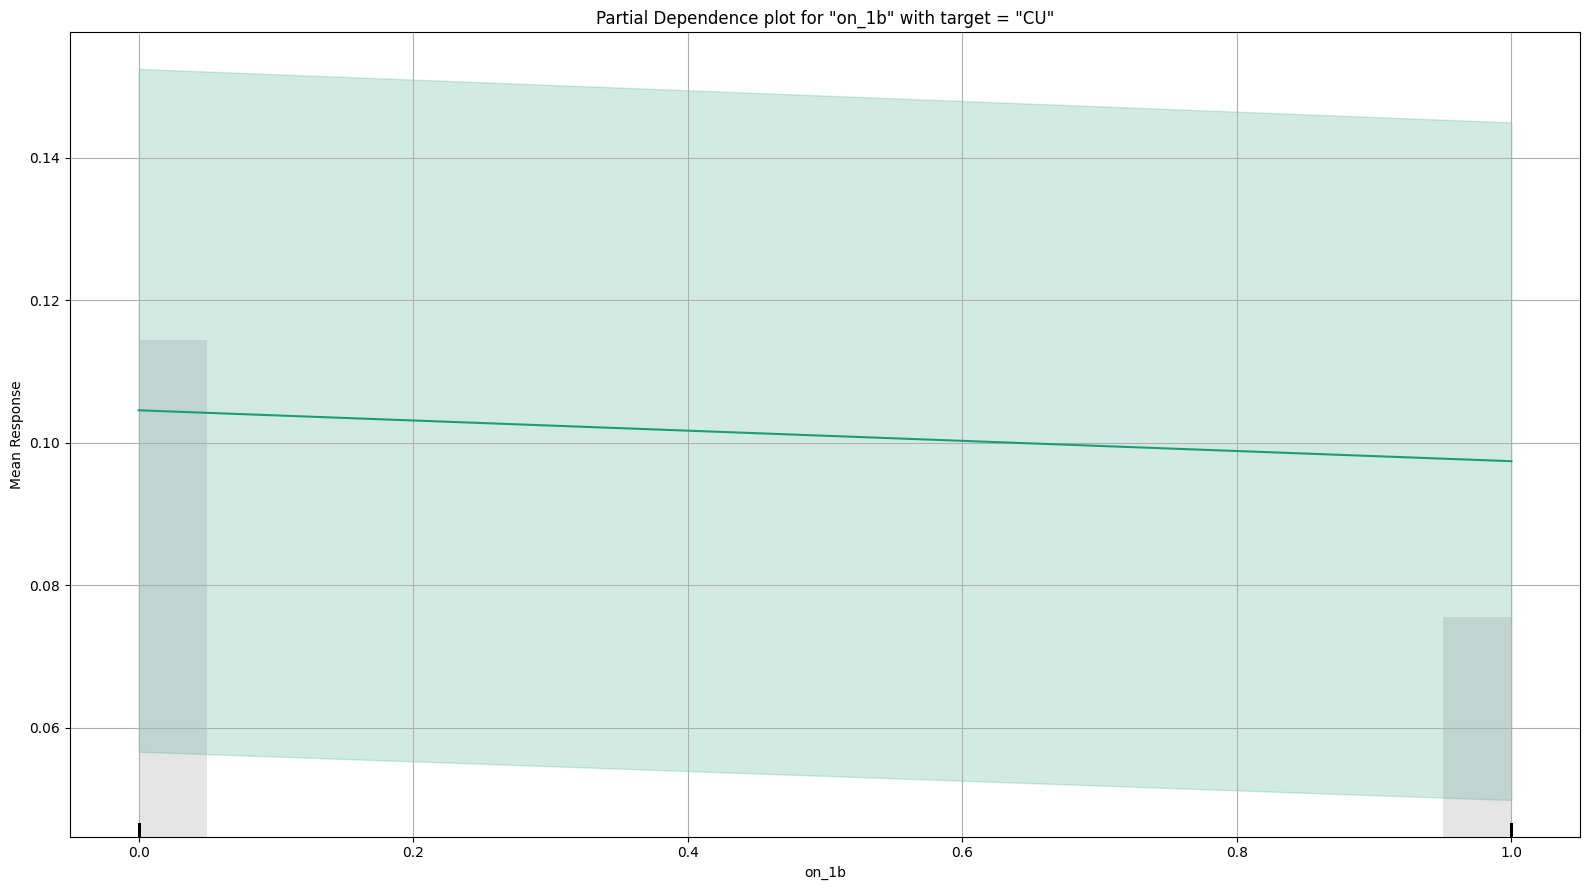

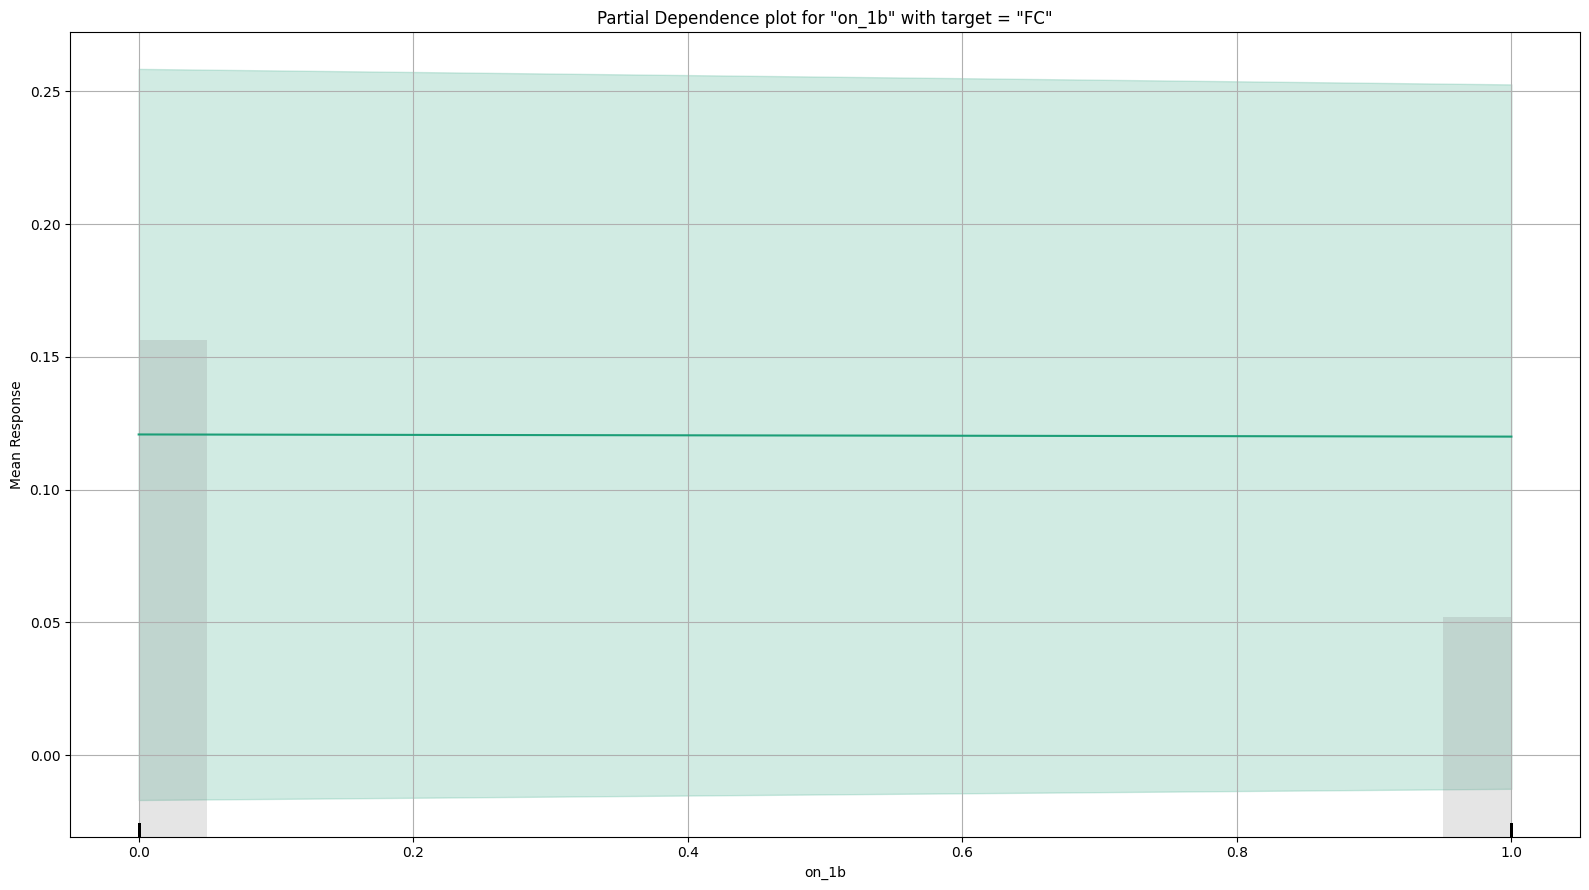

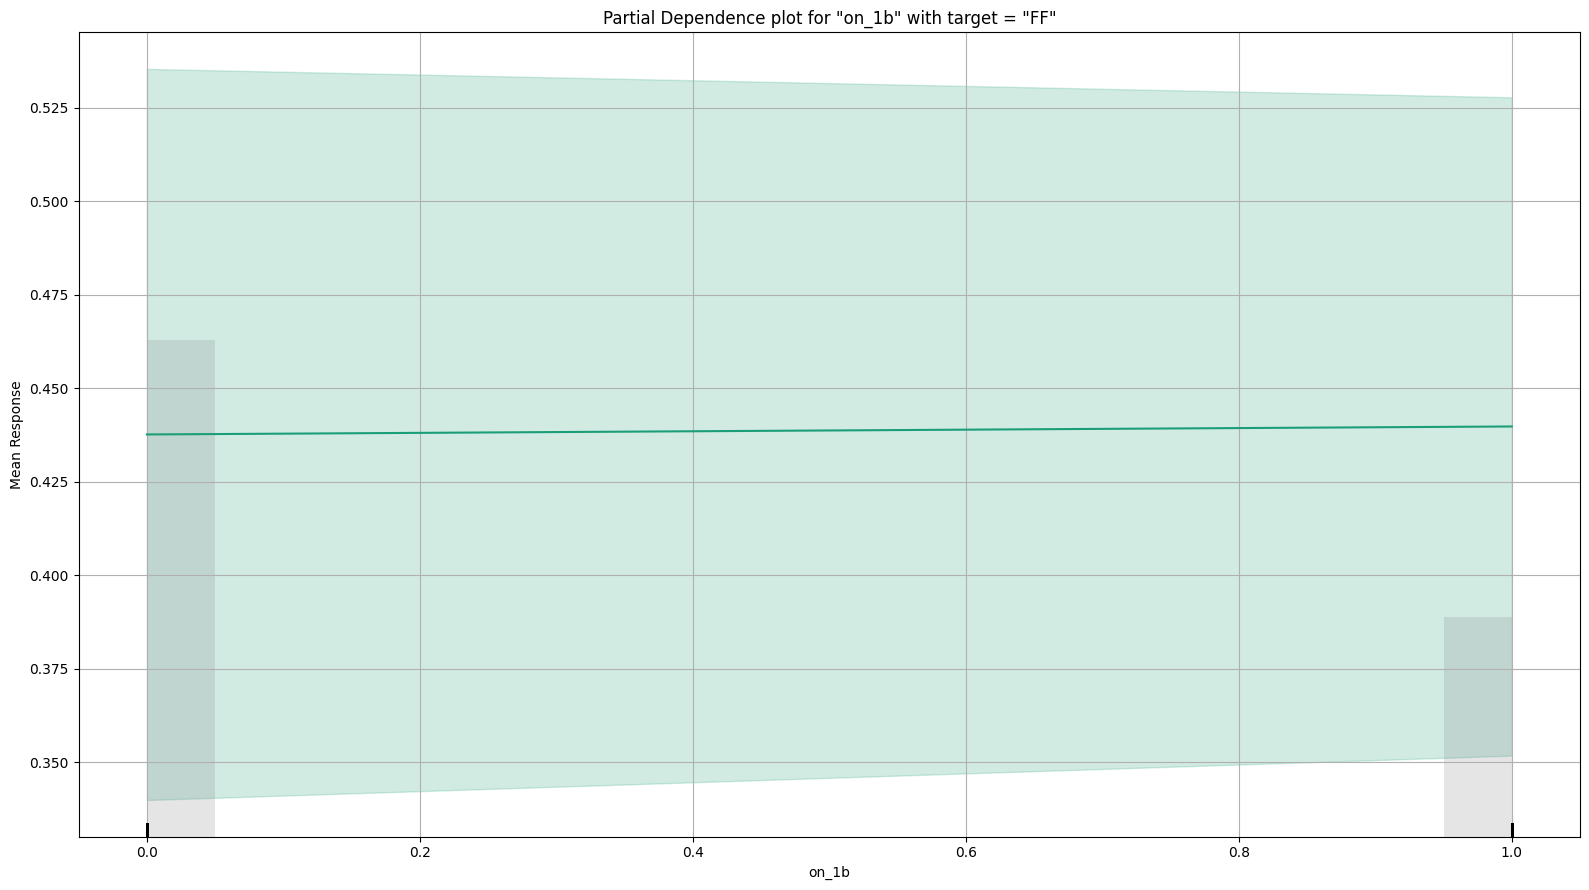

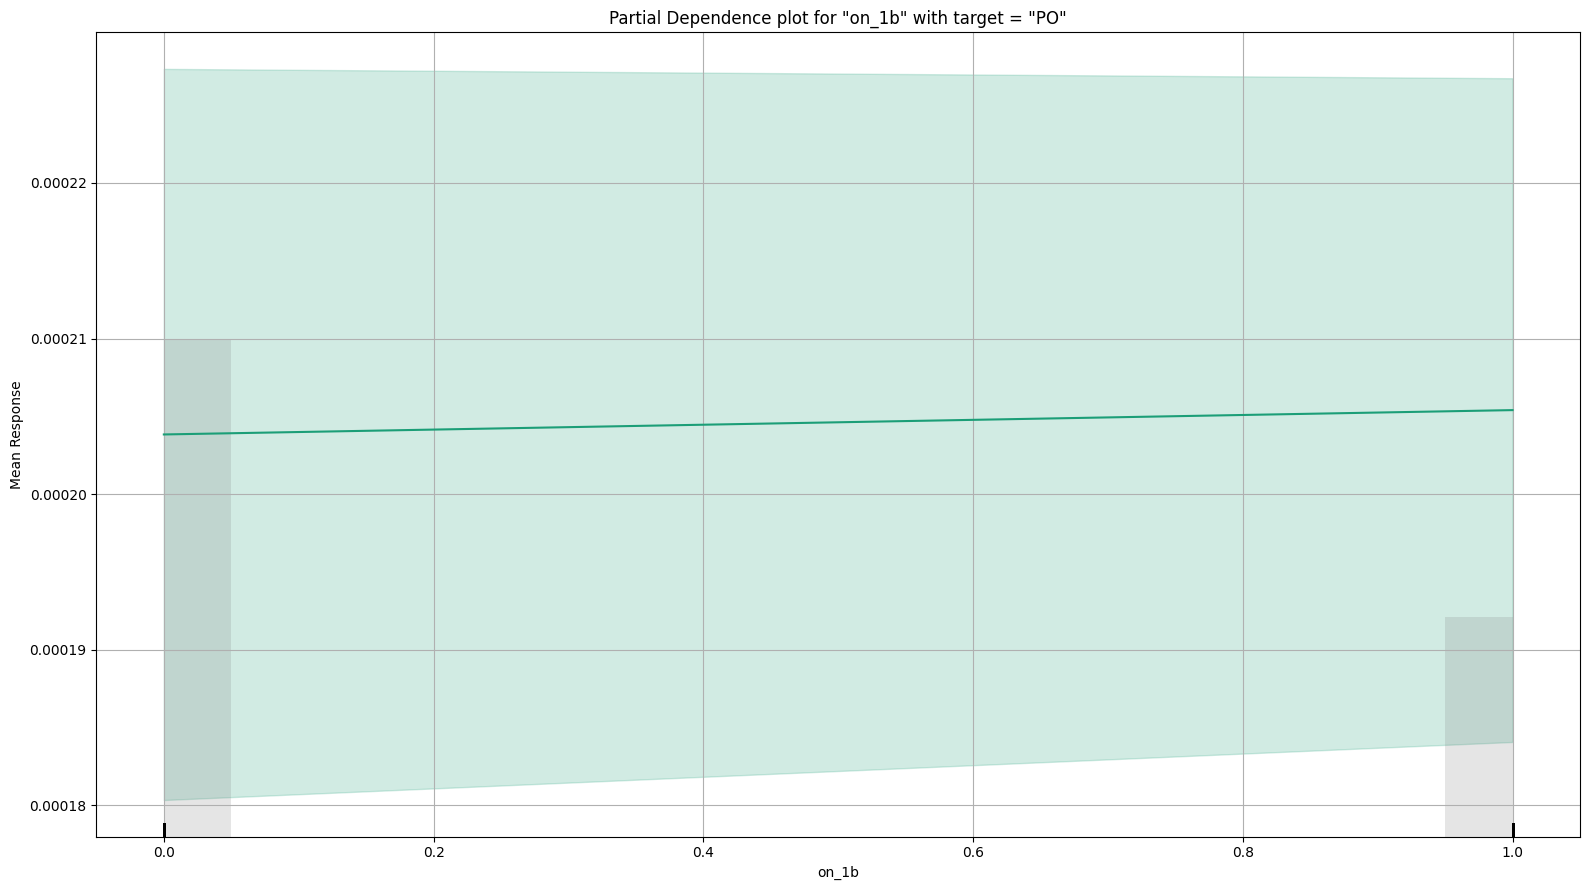

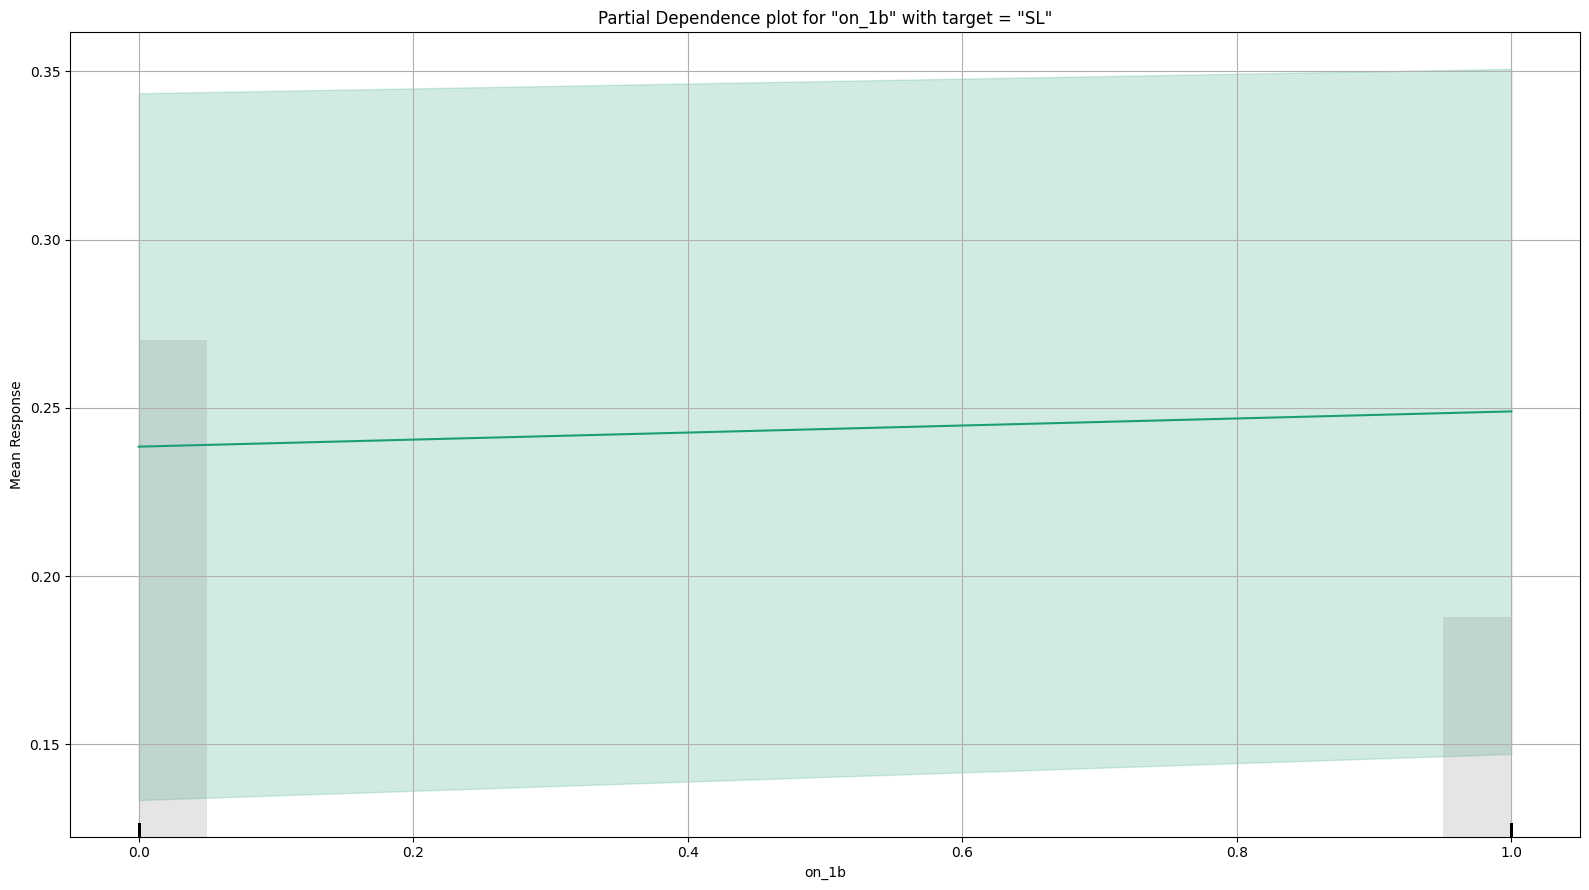

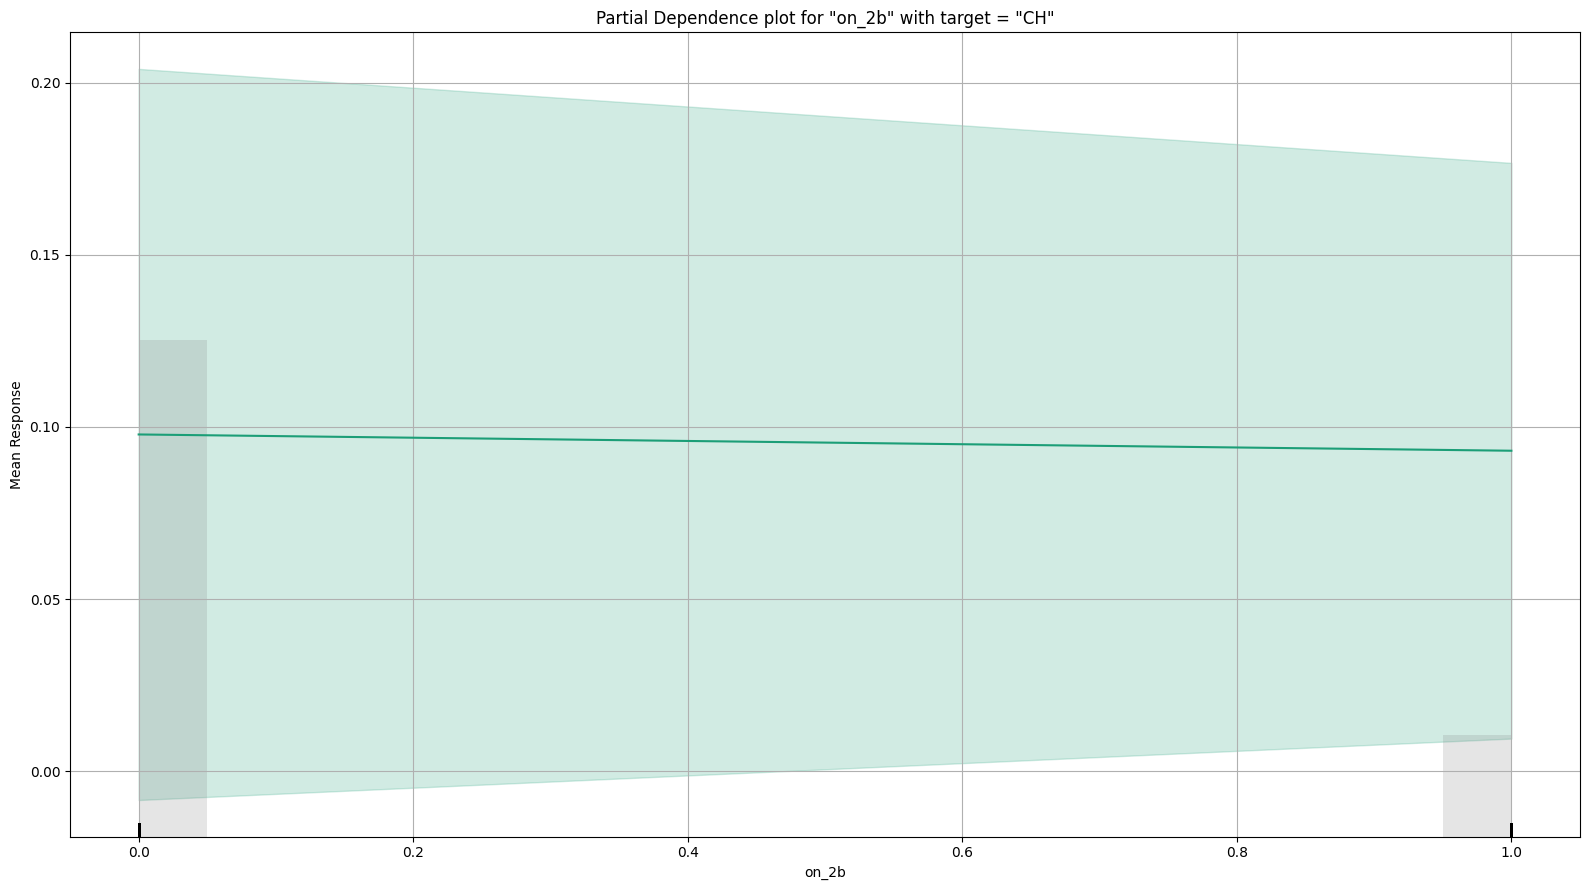

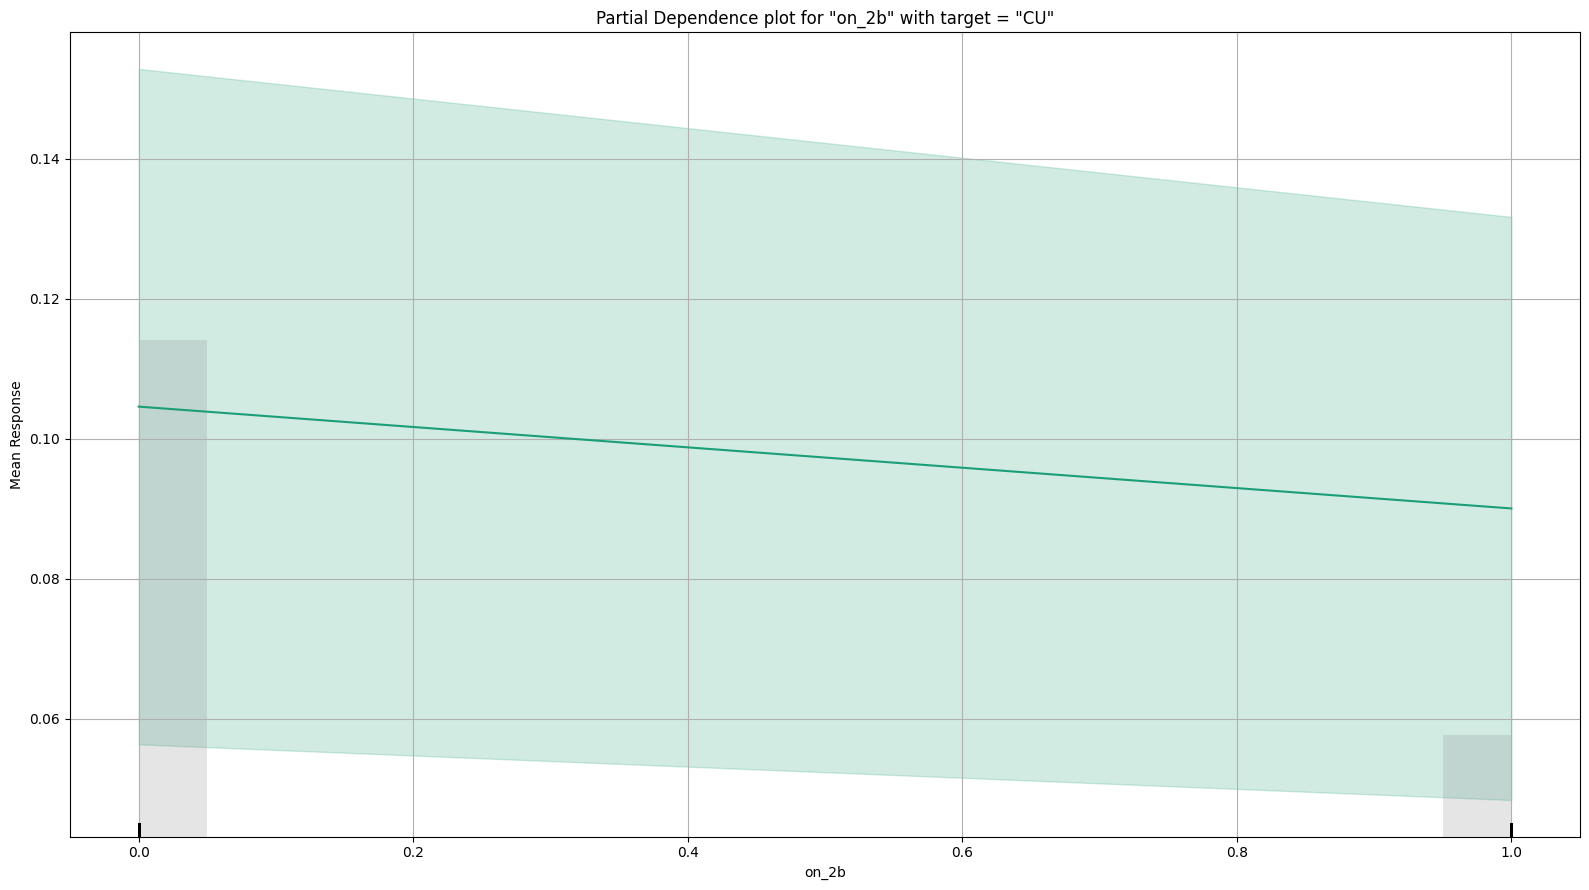

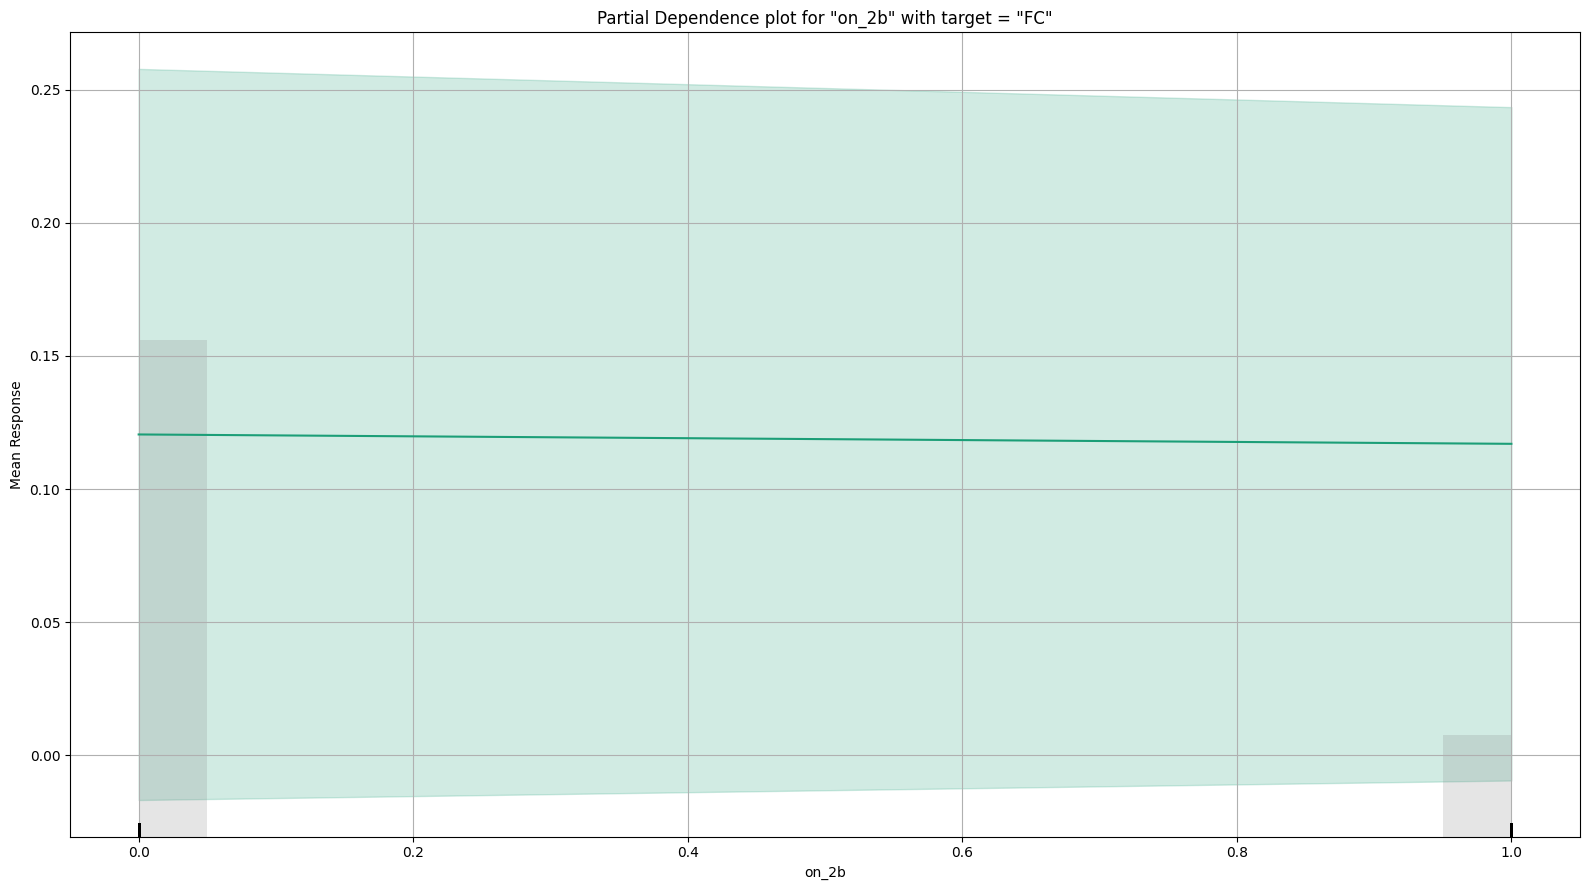

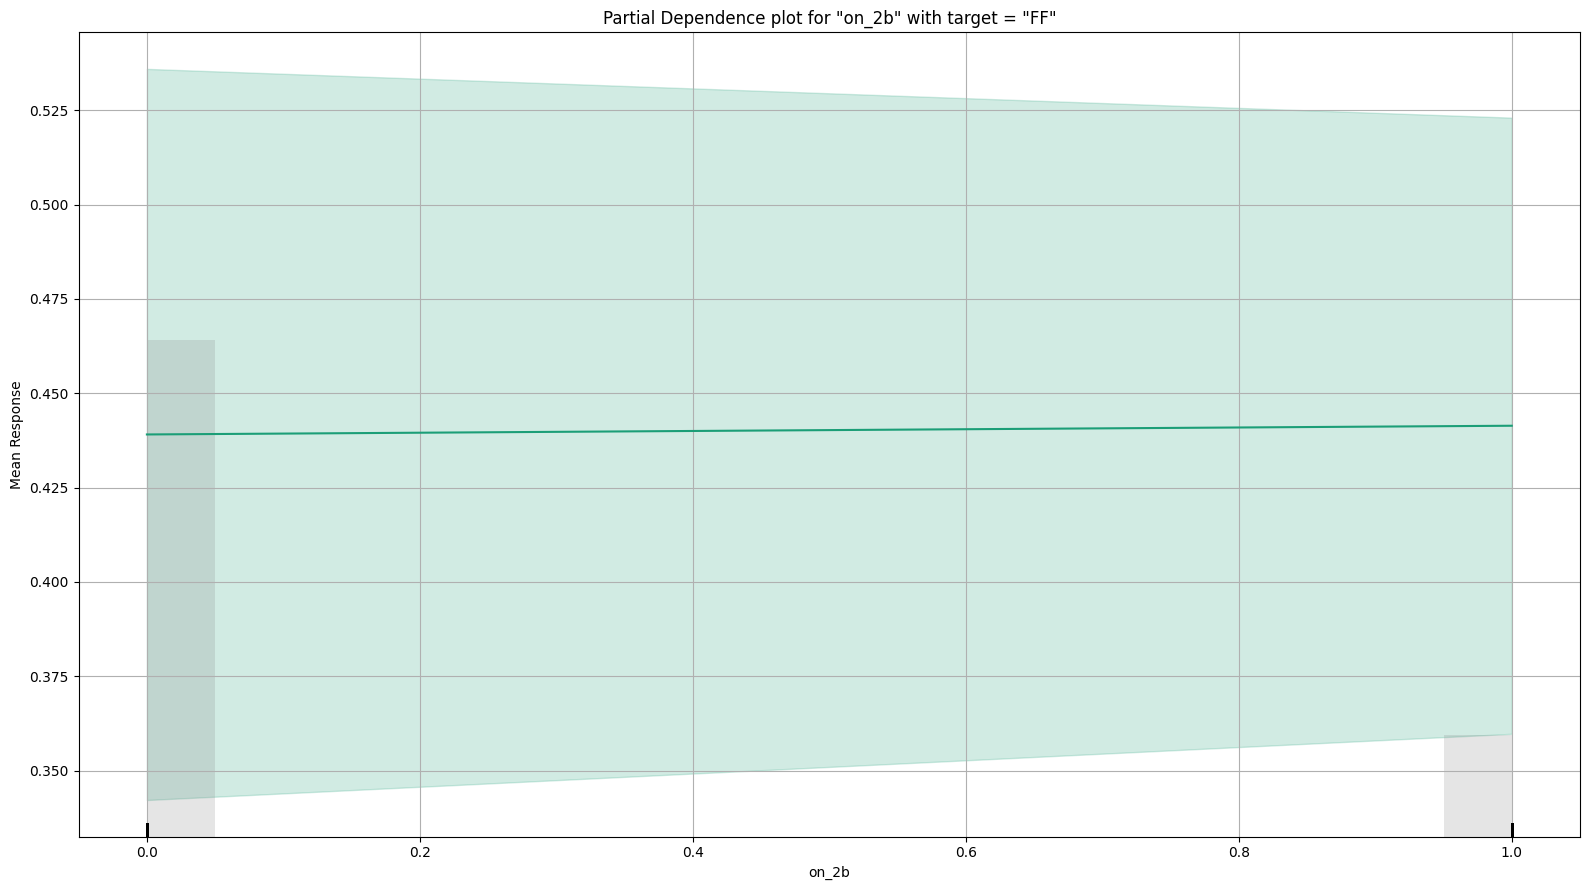

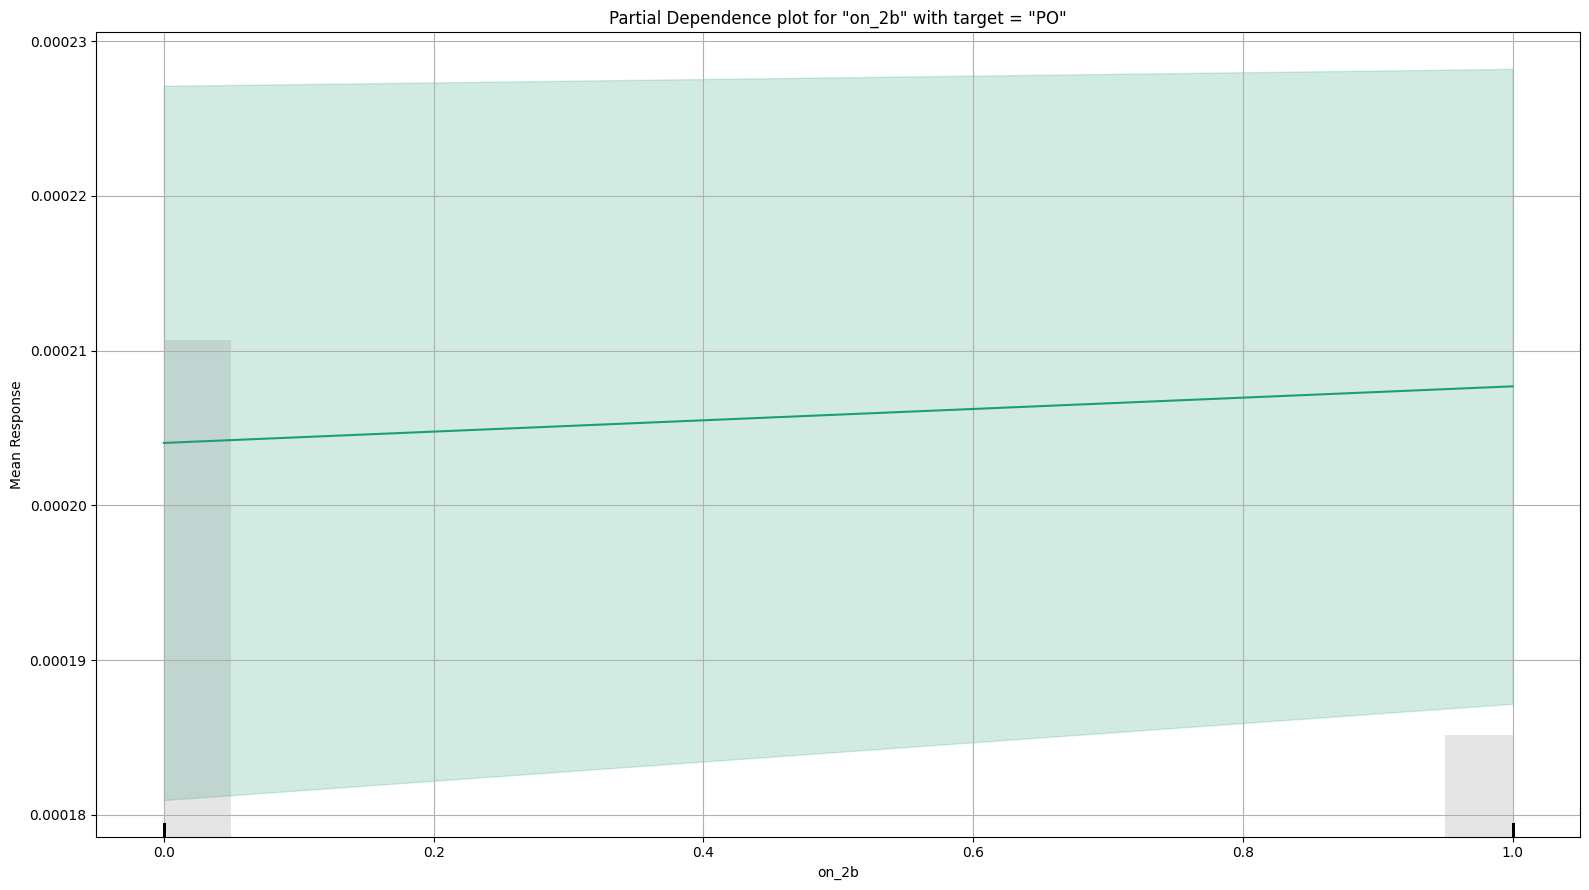

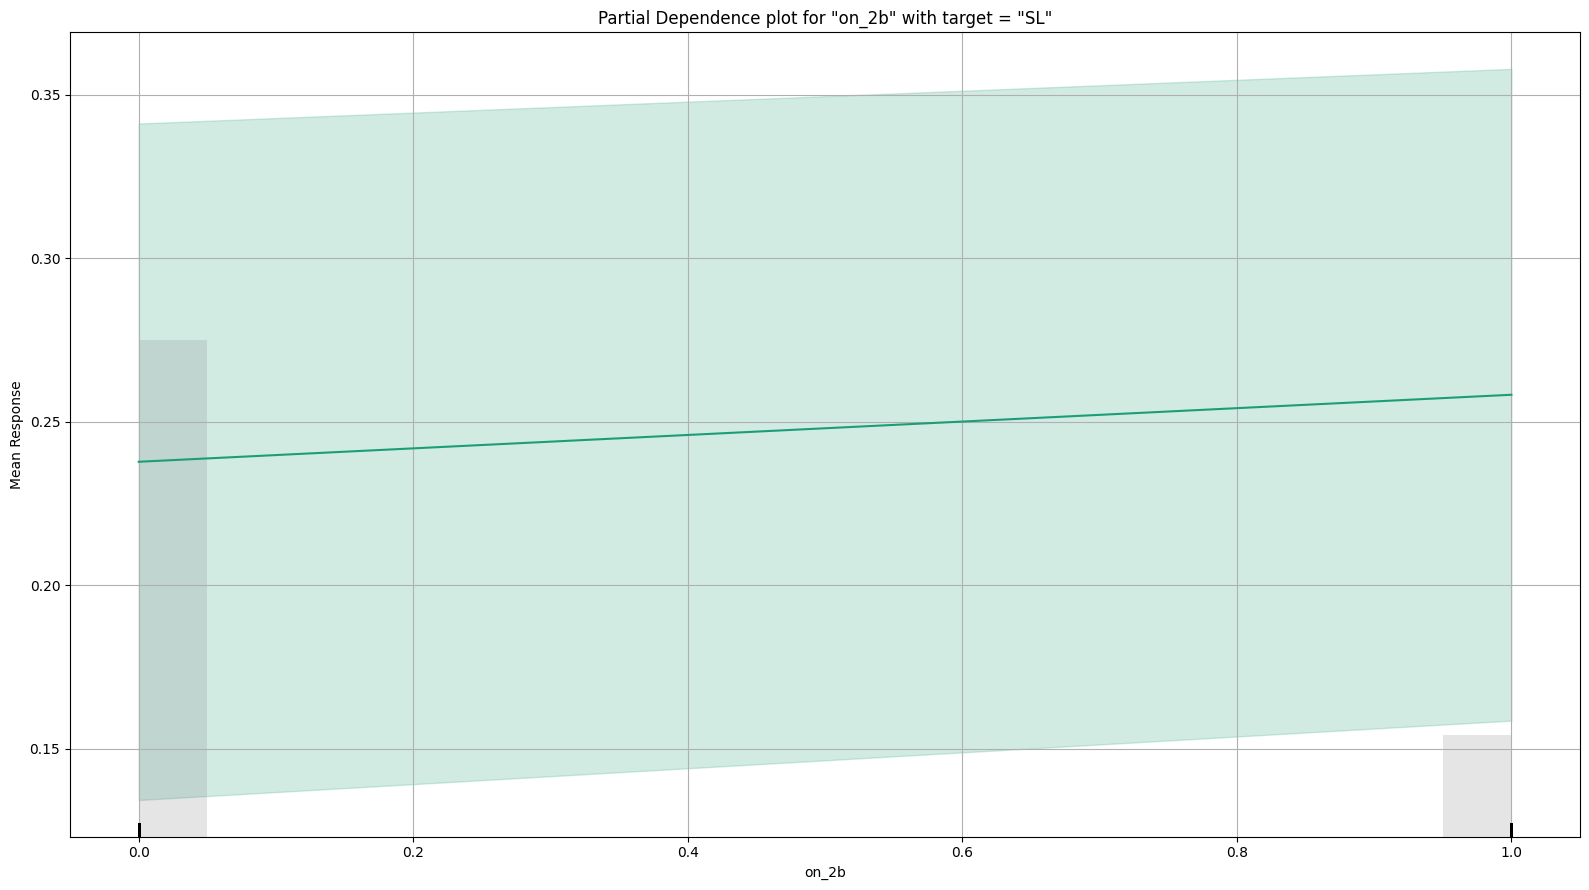

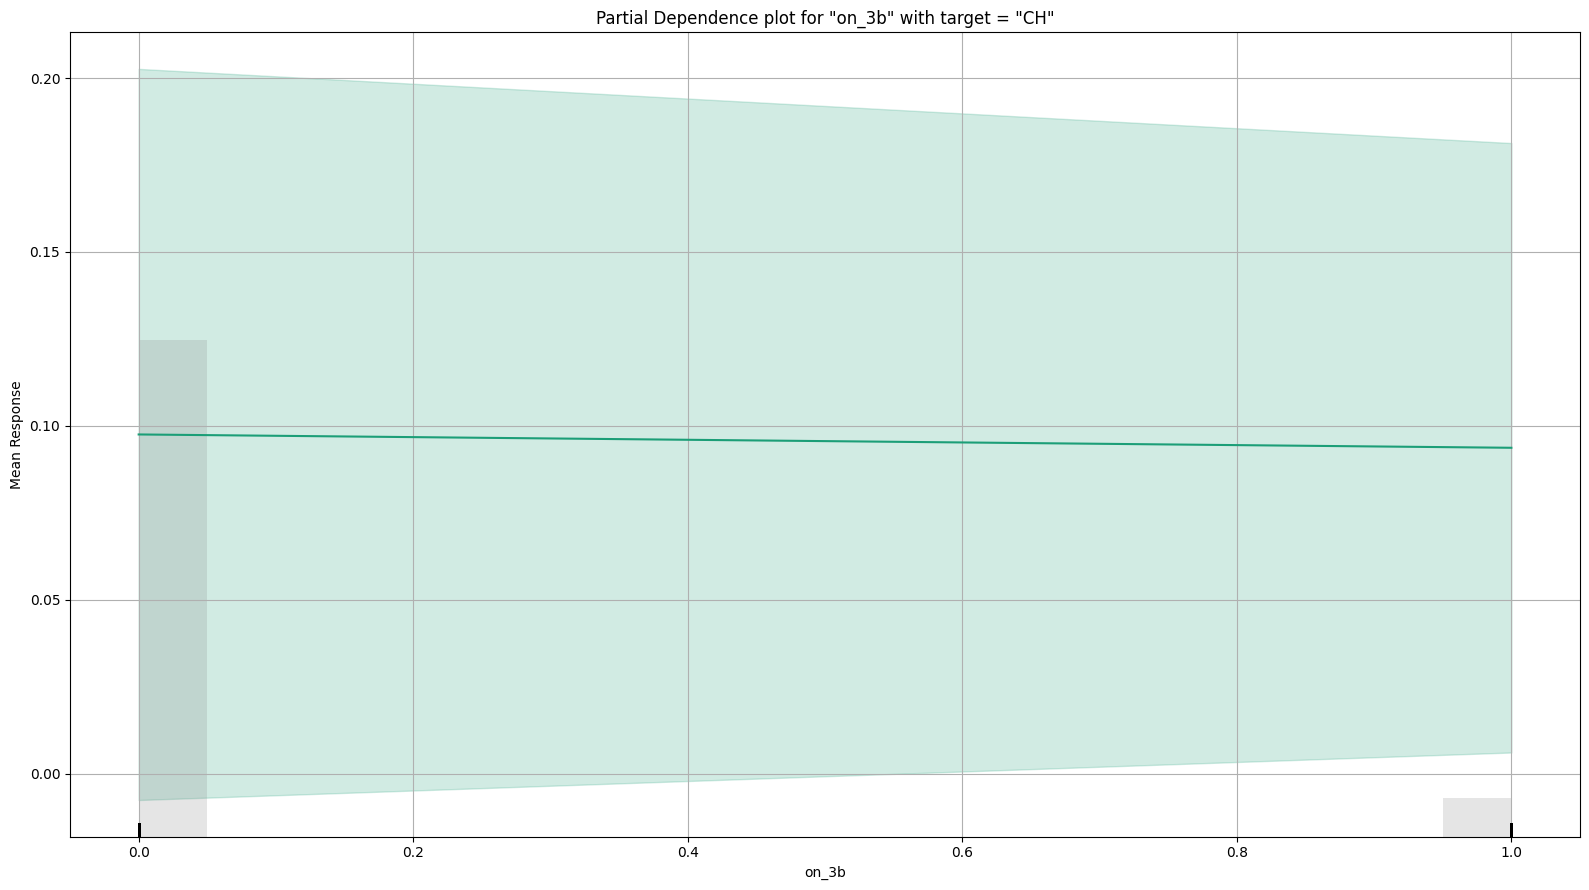

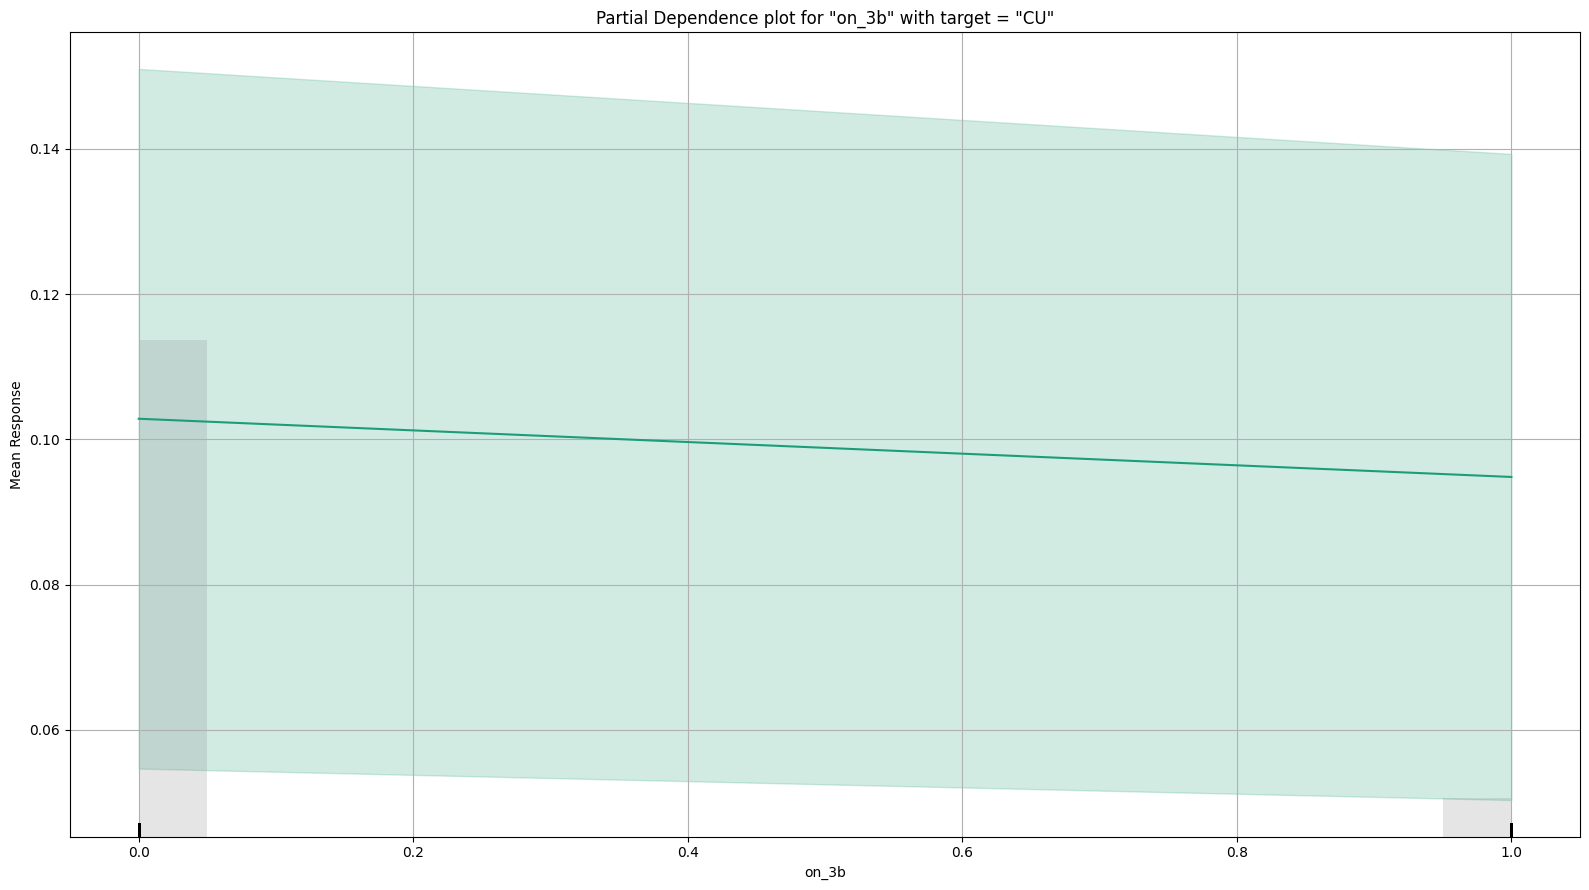

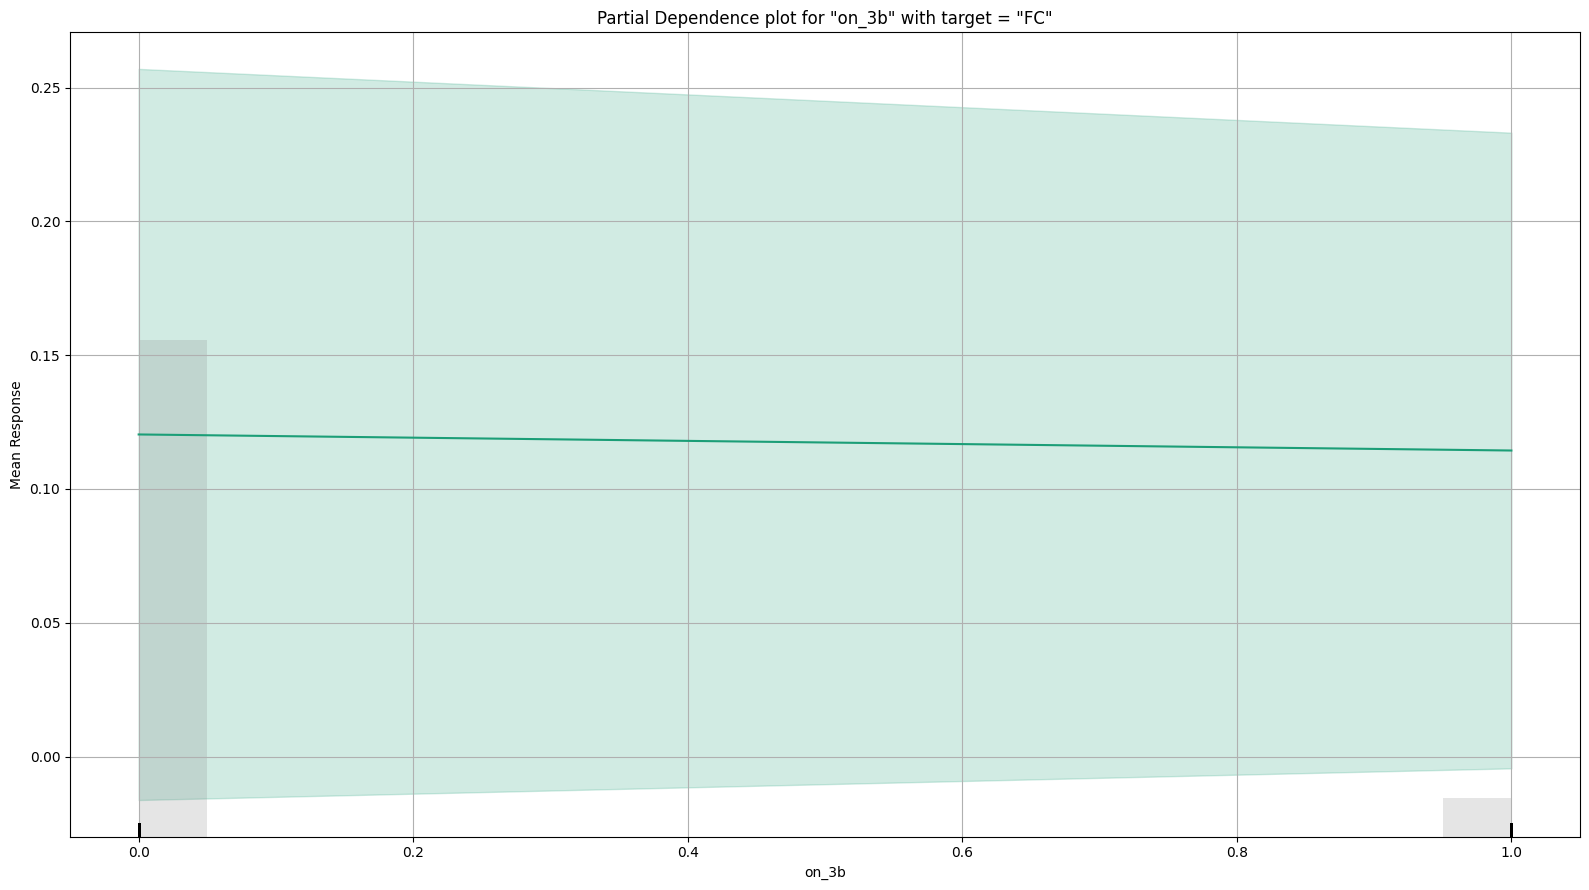

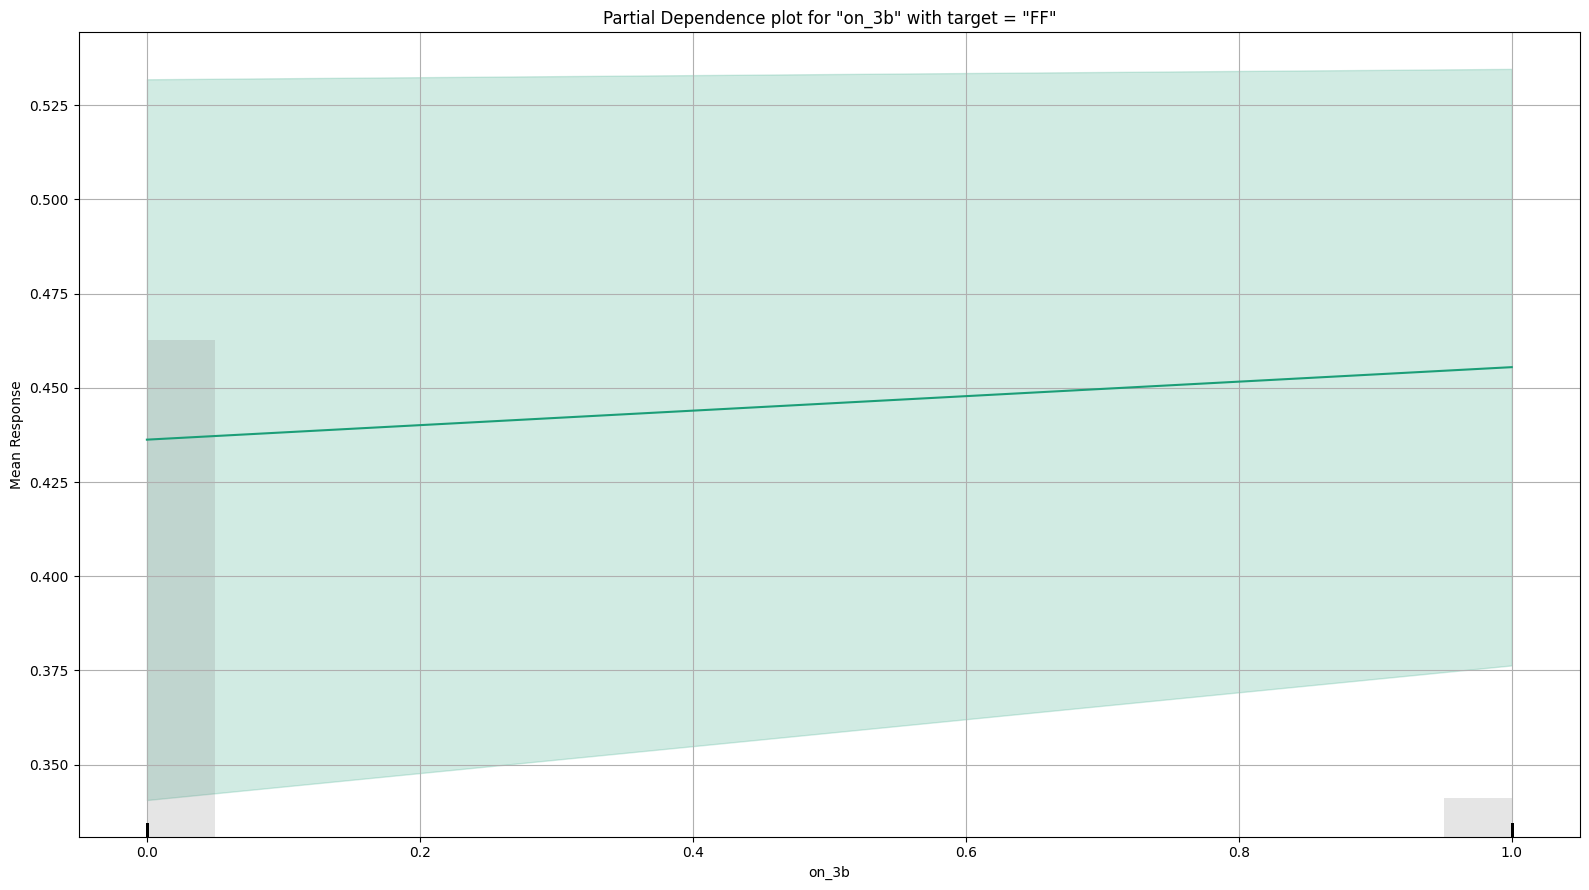

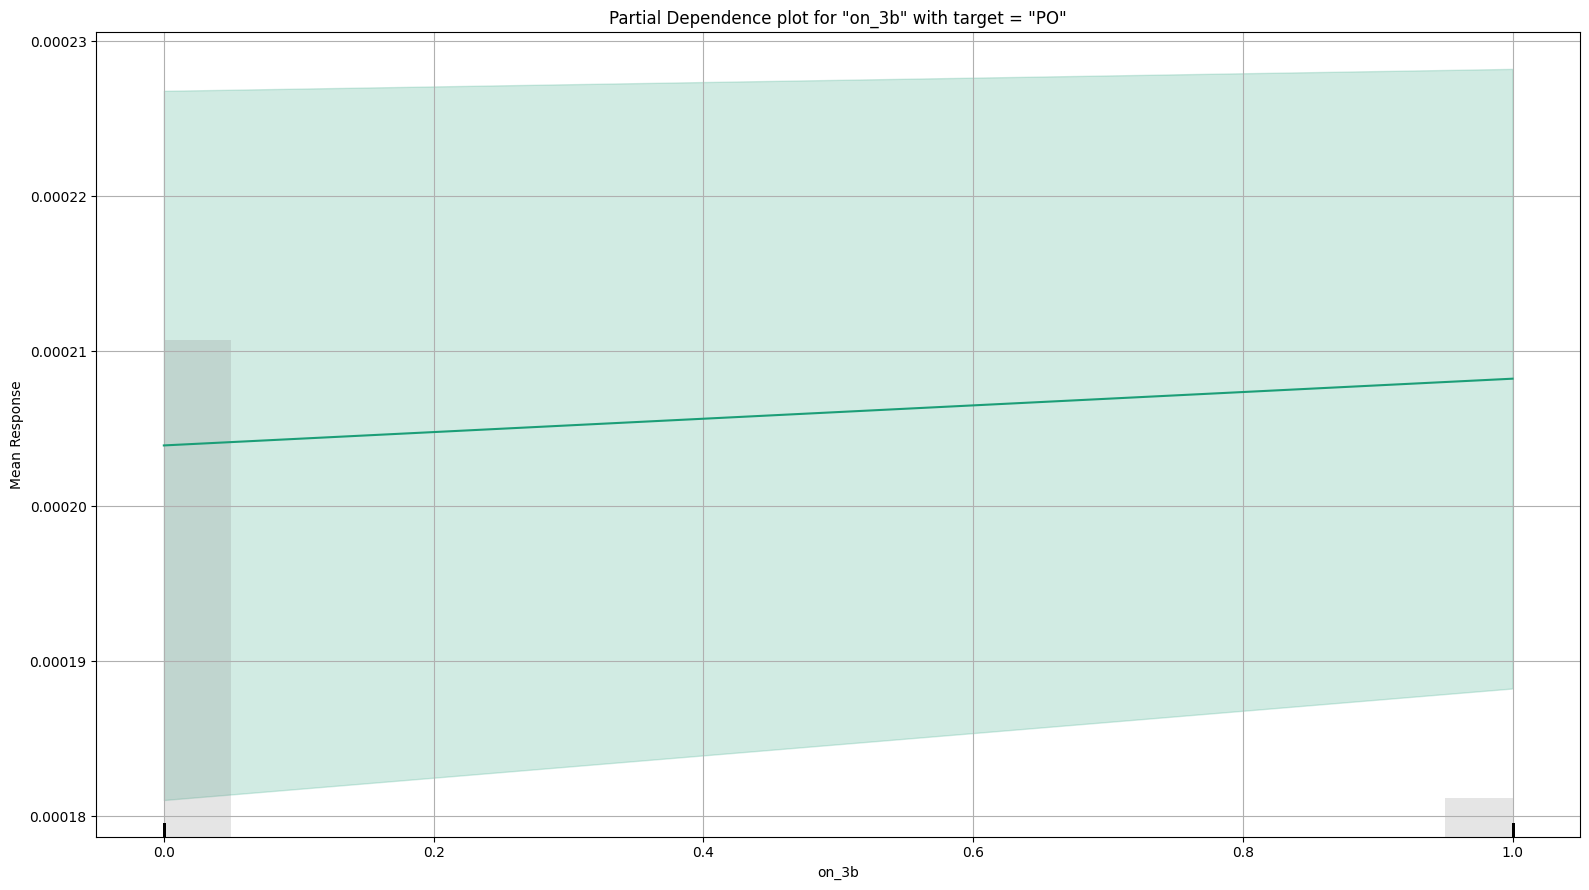

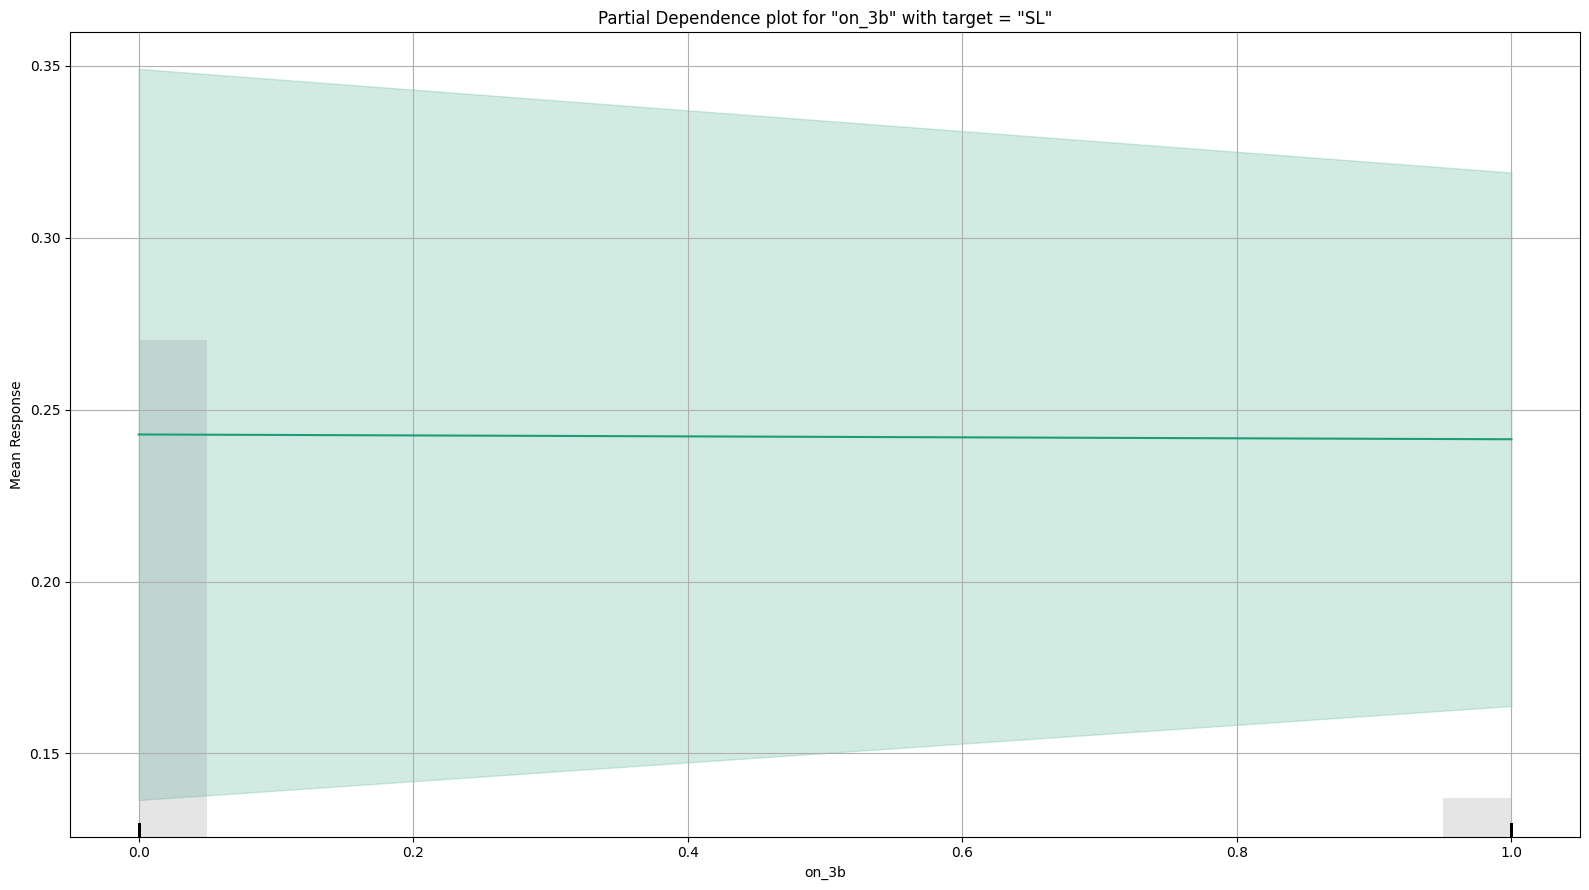

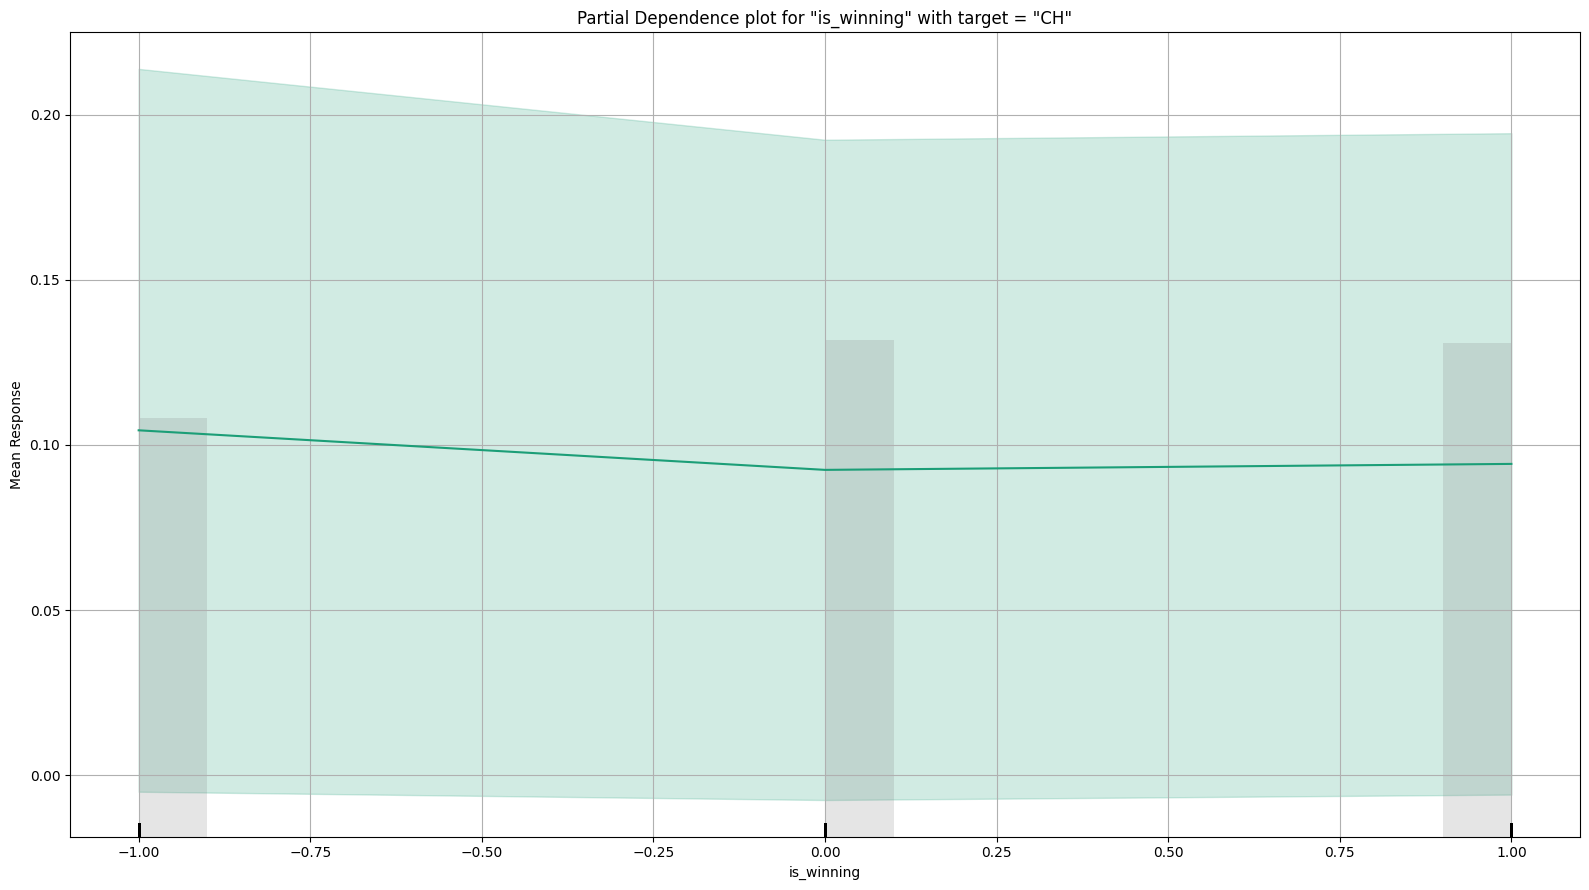

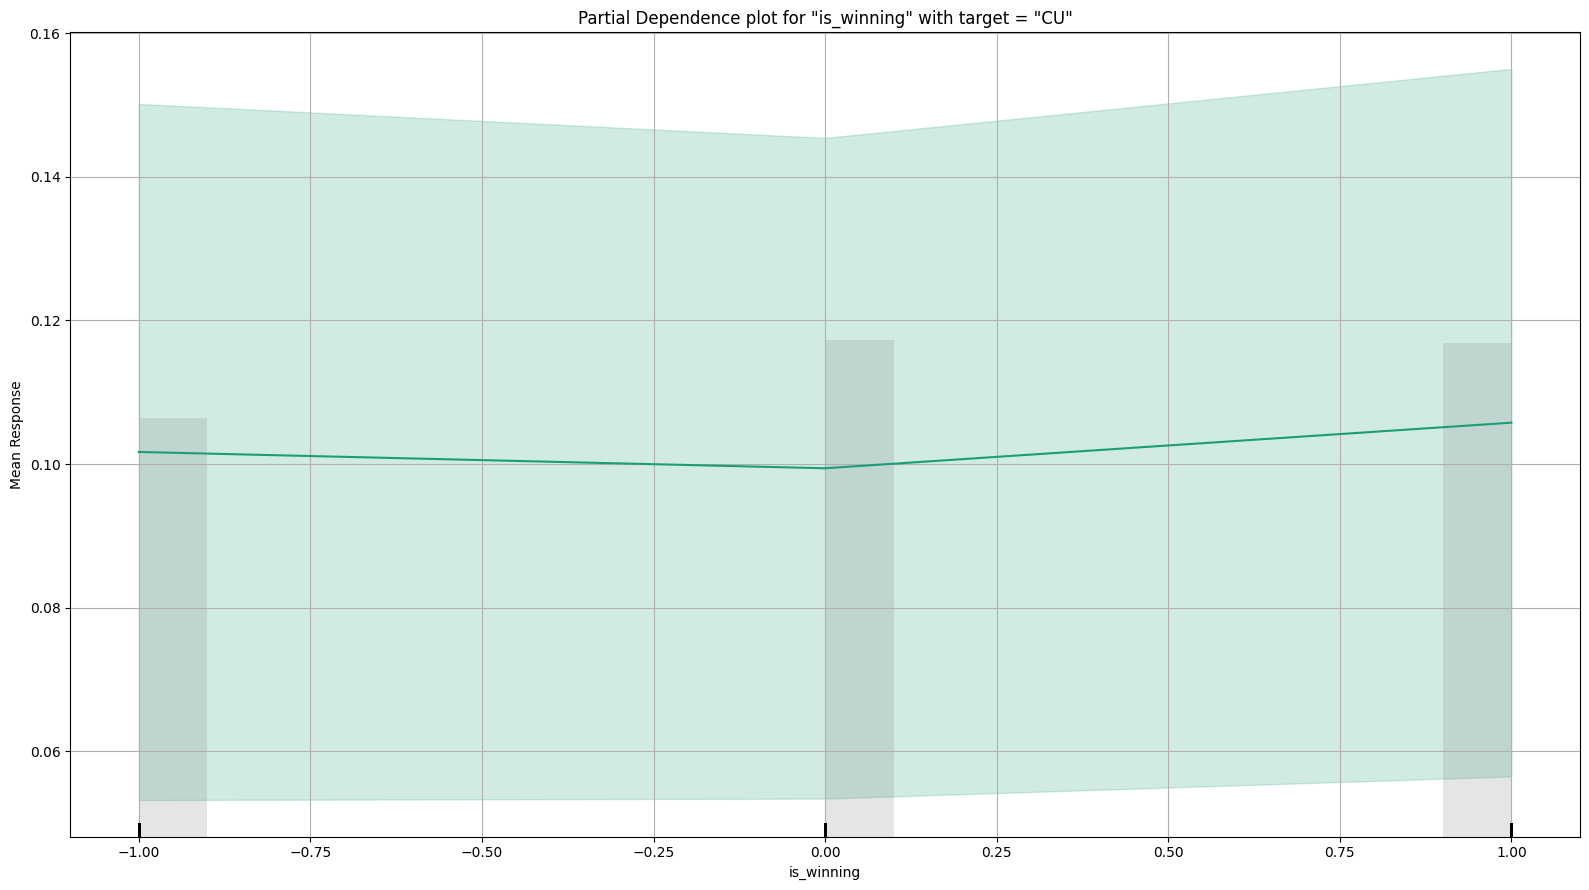

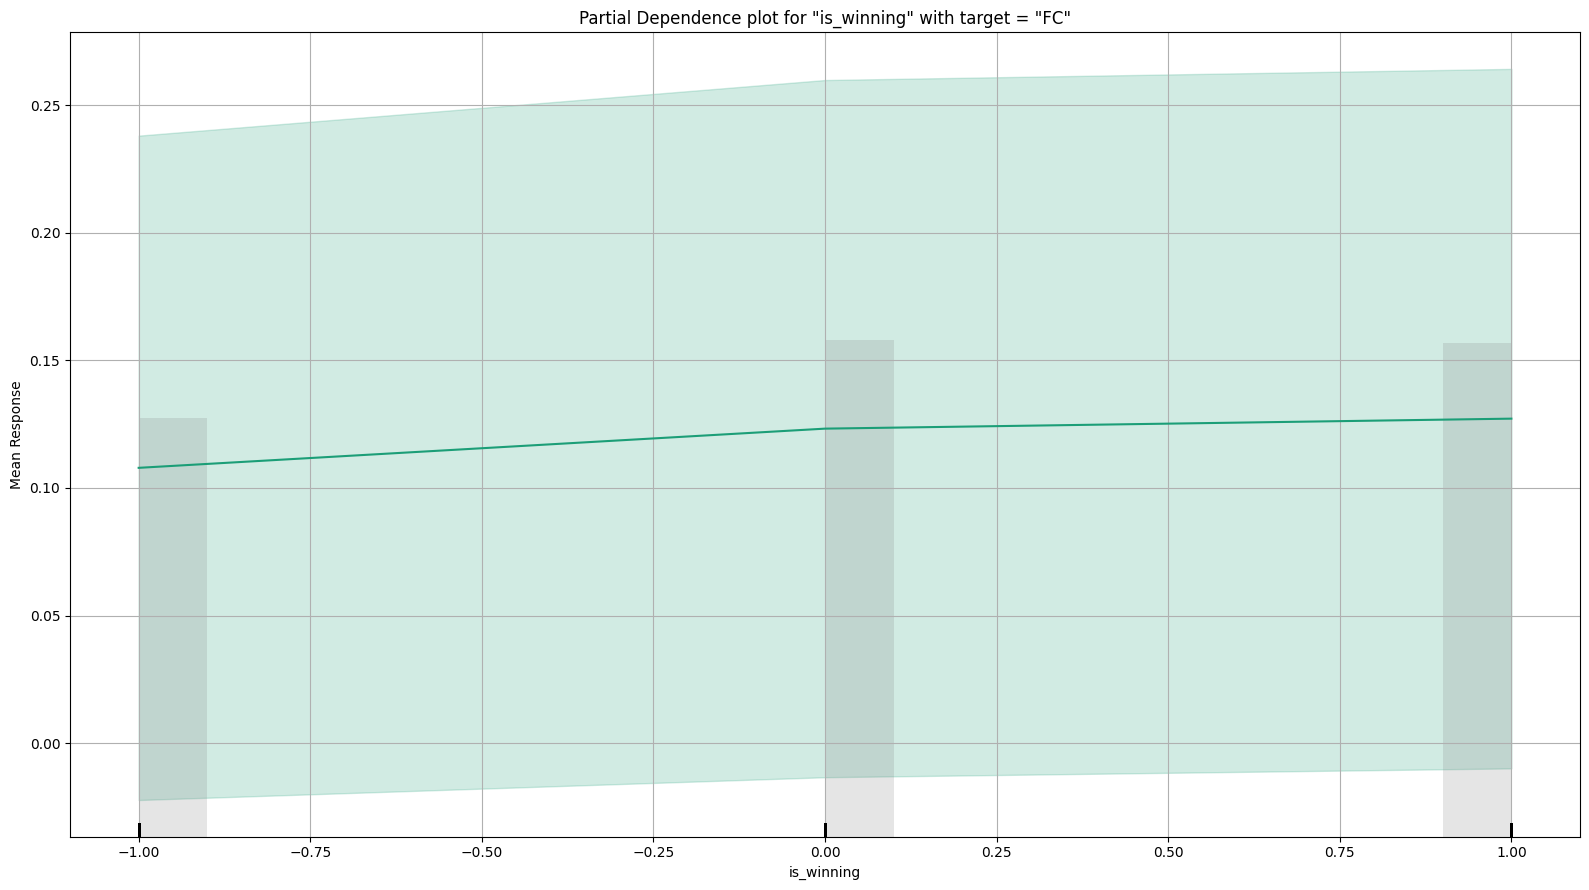

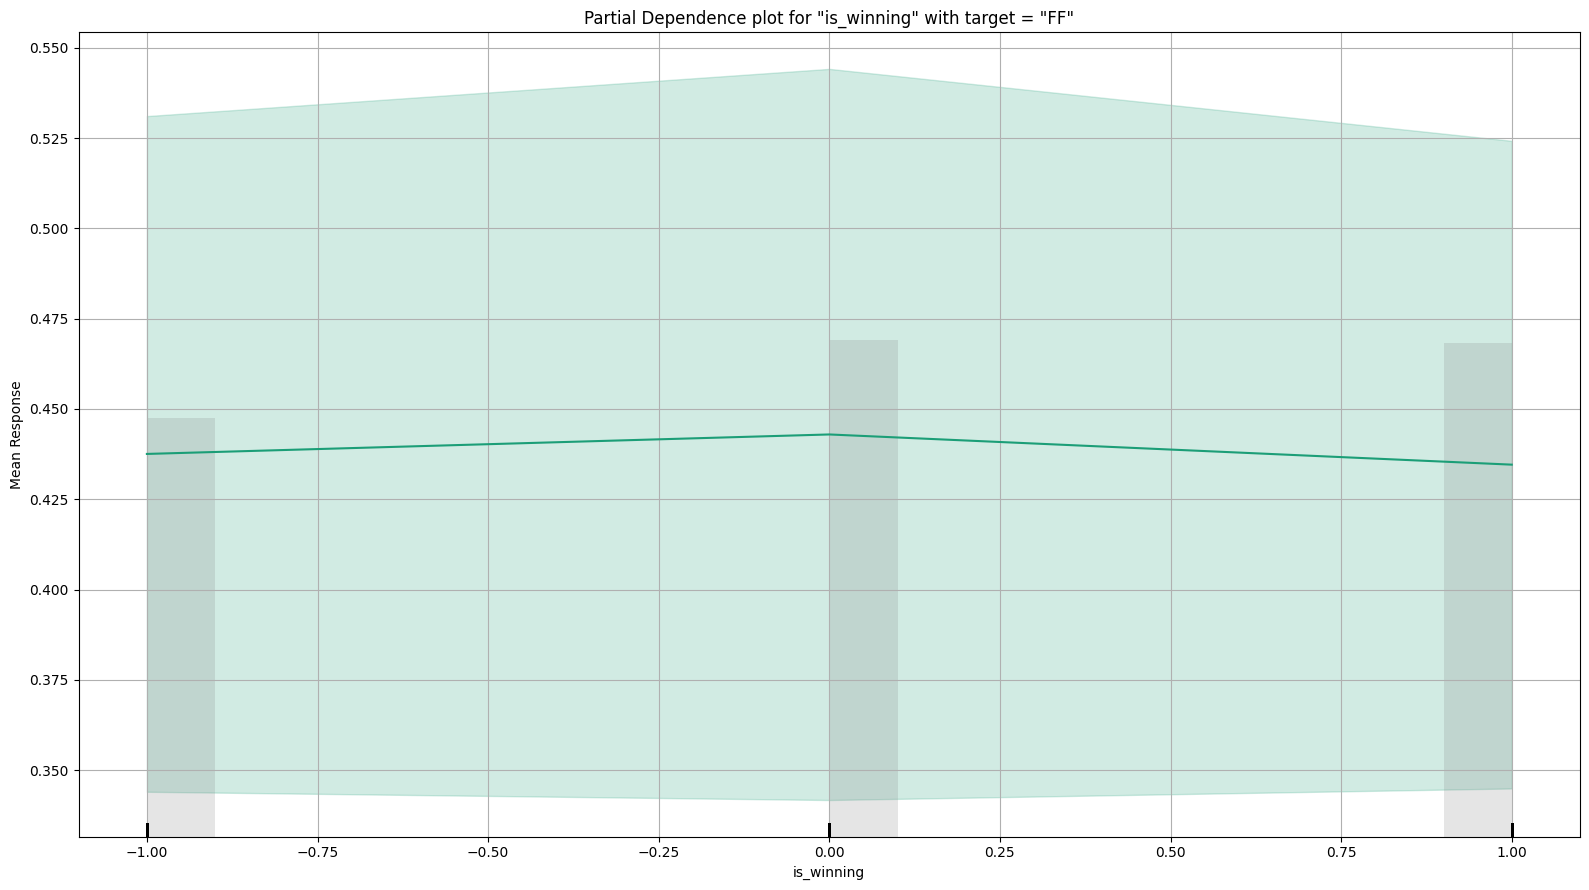

/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/h2o/model/model_base.py:898: SyntaxWarning: invalid escape sequence '\s'
  """


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_8077deaa0c13b839906215f3d42749e2> was cancelled by the user.

<Figure size 1600x900 with 0 Axes>

In [53]:
model.explain(h2o_df)